In [126]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import copy
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier


from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, f1_score, classification_report, make_scorer, log_loss
import xgboost as xgb

In [111]:
def classification_rate(y, y_pred):
    return np.sum(y==y_pred)/len(y)

In [ ]:

# from google.colab import drive
# drive.mount('/content/drive')
# train = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/train.csv', sep = ',', index_col='id')
# target = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/train labels.csv', sep = ',', index_col='id')
# test = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/test.csv', sep = ',', index_col='id')


Mounted at /content/drive


In [16]:
from google.colab import drive
drive.mount('/content/drive')
train = pd.read_csv('/content/drive/MyDrive/DS/train.csv', index_col='id')
target = pd.read_csv('/content/drive/MyDrive/DS/train labels.csv', index_col='id')
test = pd.read_csv('/content/drive/MyDrive/DS/test.csv', index_col='id')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data import

In [17]:
# train = pd.read_csv('train.csv', index_col='id')
# target = pd.read_csv('train labels.csv', index_col='id')
# test = pd.read_csv('test.csv', index_col='id')

In [18]:
target['labels'] = target['status_group'].astype('category').cat.codes
# target['status_group'] = target['status_group'].astype('category')

## Describe the problem you want to solve using data science techniques

A smart understanding of which waterpoints will fail can help to: 

1)  provide the access to clean water for the half of Tanzania's population, ensure that potable water is available to communities across Tanzania

2) improve sanitation and fight the distribution of acute diseases among population who live in dry regions

3) reduce the amount of foreign aid fundations to Tanzania, as now the country's government can not solve the problem of water distribution.


<br>
<br>
The labels in this dataset are simple. There are three possible values:

**functional** - the waterpoint is operational and there are no repairs needed

**functional needs repair** - the waterpoint is operational, but needs repairs

**non functional** - the waterpoint is not operational

**Goal** is to predict the operating condition of a waterpoint for each record in the dataset.


# EDA

In [19]:
print(f'Shape of Train data: {train.shape}')
print(f'Shape of Test data: {test.shape}')
print(f'Shape of Target data: {target.shape}')

Shape of Train data: (59400, 39)
Shape of Test data: (14850, 39)
Shape of Target data: (59400, 2)



## Feature description
amount_tsh - Total static head (amount water available to waterpoint)

date_recorded - The date the row was entered

funder - Who funded the well

gps_height - Altitude of the well

installer - Organization that installed the well

longitude - GPS coordinate

latitude - GPS coordinate

wpt_name - Name of the waterpoint if there is one

num_private - No information provided

basin - Geographic water basin

subvillage - Geographic location

region - Geographic location

region_code - Geographic location (coded)

district_code - Geographic location (coded)

lga - Geographic location

ward - Geographic location

population - Population around the well

public_meeting - True/False

recorded_by - Group entering this row of data

scheme_management - Who operates the waterpoint

scheme_name - Who operates the waterpoint

permit - If the waterpoint is permitted

construction_year - Year the waterpoint was constructed

extraction_type - The kind of extraction the waterpoint uses

extraction_type_group - The kind of extraction the waterpoint 
uses

extraction_type_class - The kind of extraction the waterpoint 
uses

management - How the waterpoint is managed

management_group - How the waterpoint is managed

payment - What the water costs

payment_type - What the water costs

water_quality - The quality of the water

quality_group - The quality of the water

quantity - The quantity of water

quantity_group - The quantity of water

source - The source of the water

source_type - The source of the water

source_class - The source of the water

waterpoint_type - The kind of waterpoint

waterpoint_type_group - The kind of waterpoint



## Target classes

Let's start from the target

In [20]:
labels_vc = target.status_group.value_counts()
labels_vc

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [21]:
palette = {
    'functional': '#13EAC9',
    'non functional': '#E50000',
    'functional needs repair': '#FFFF14'
}

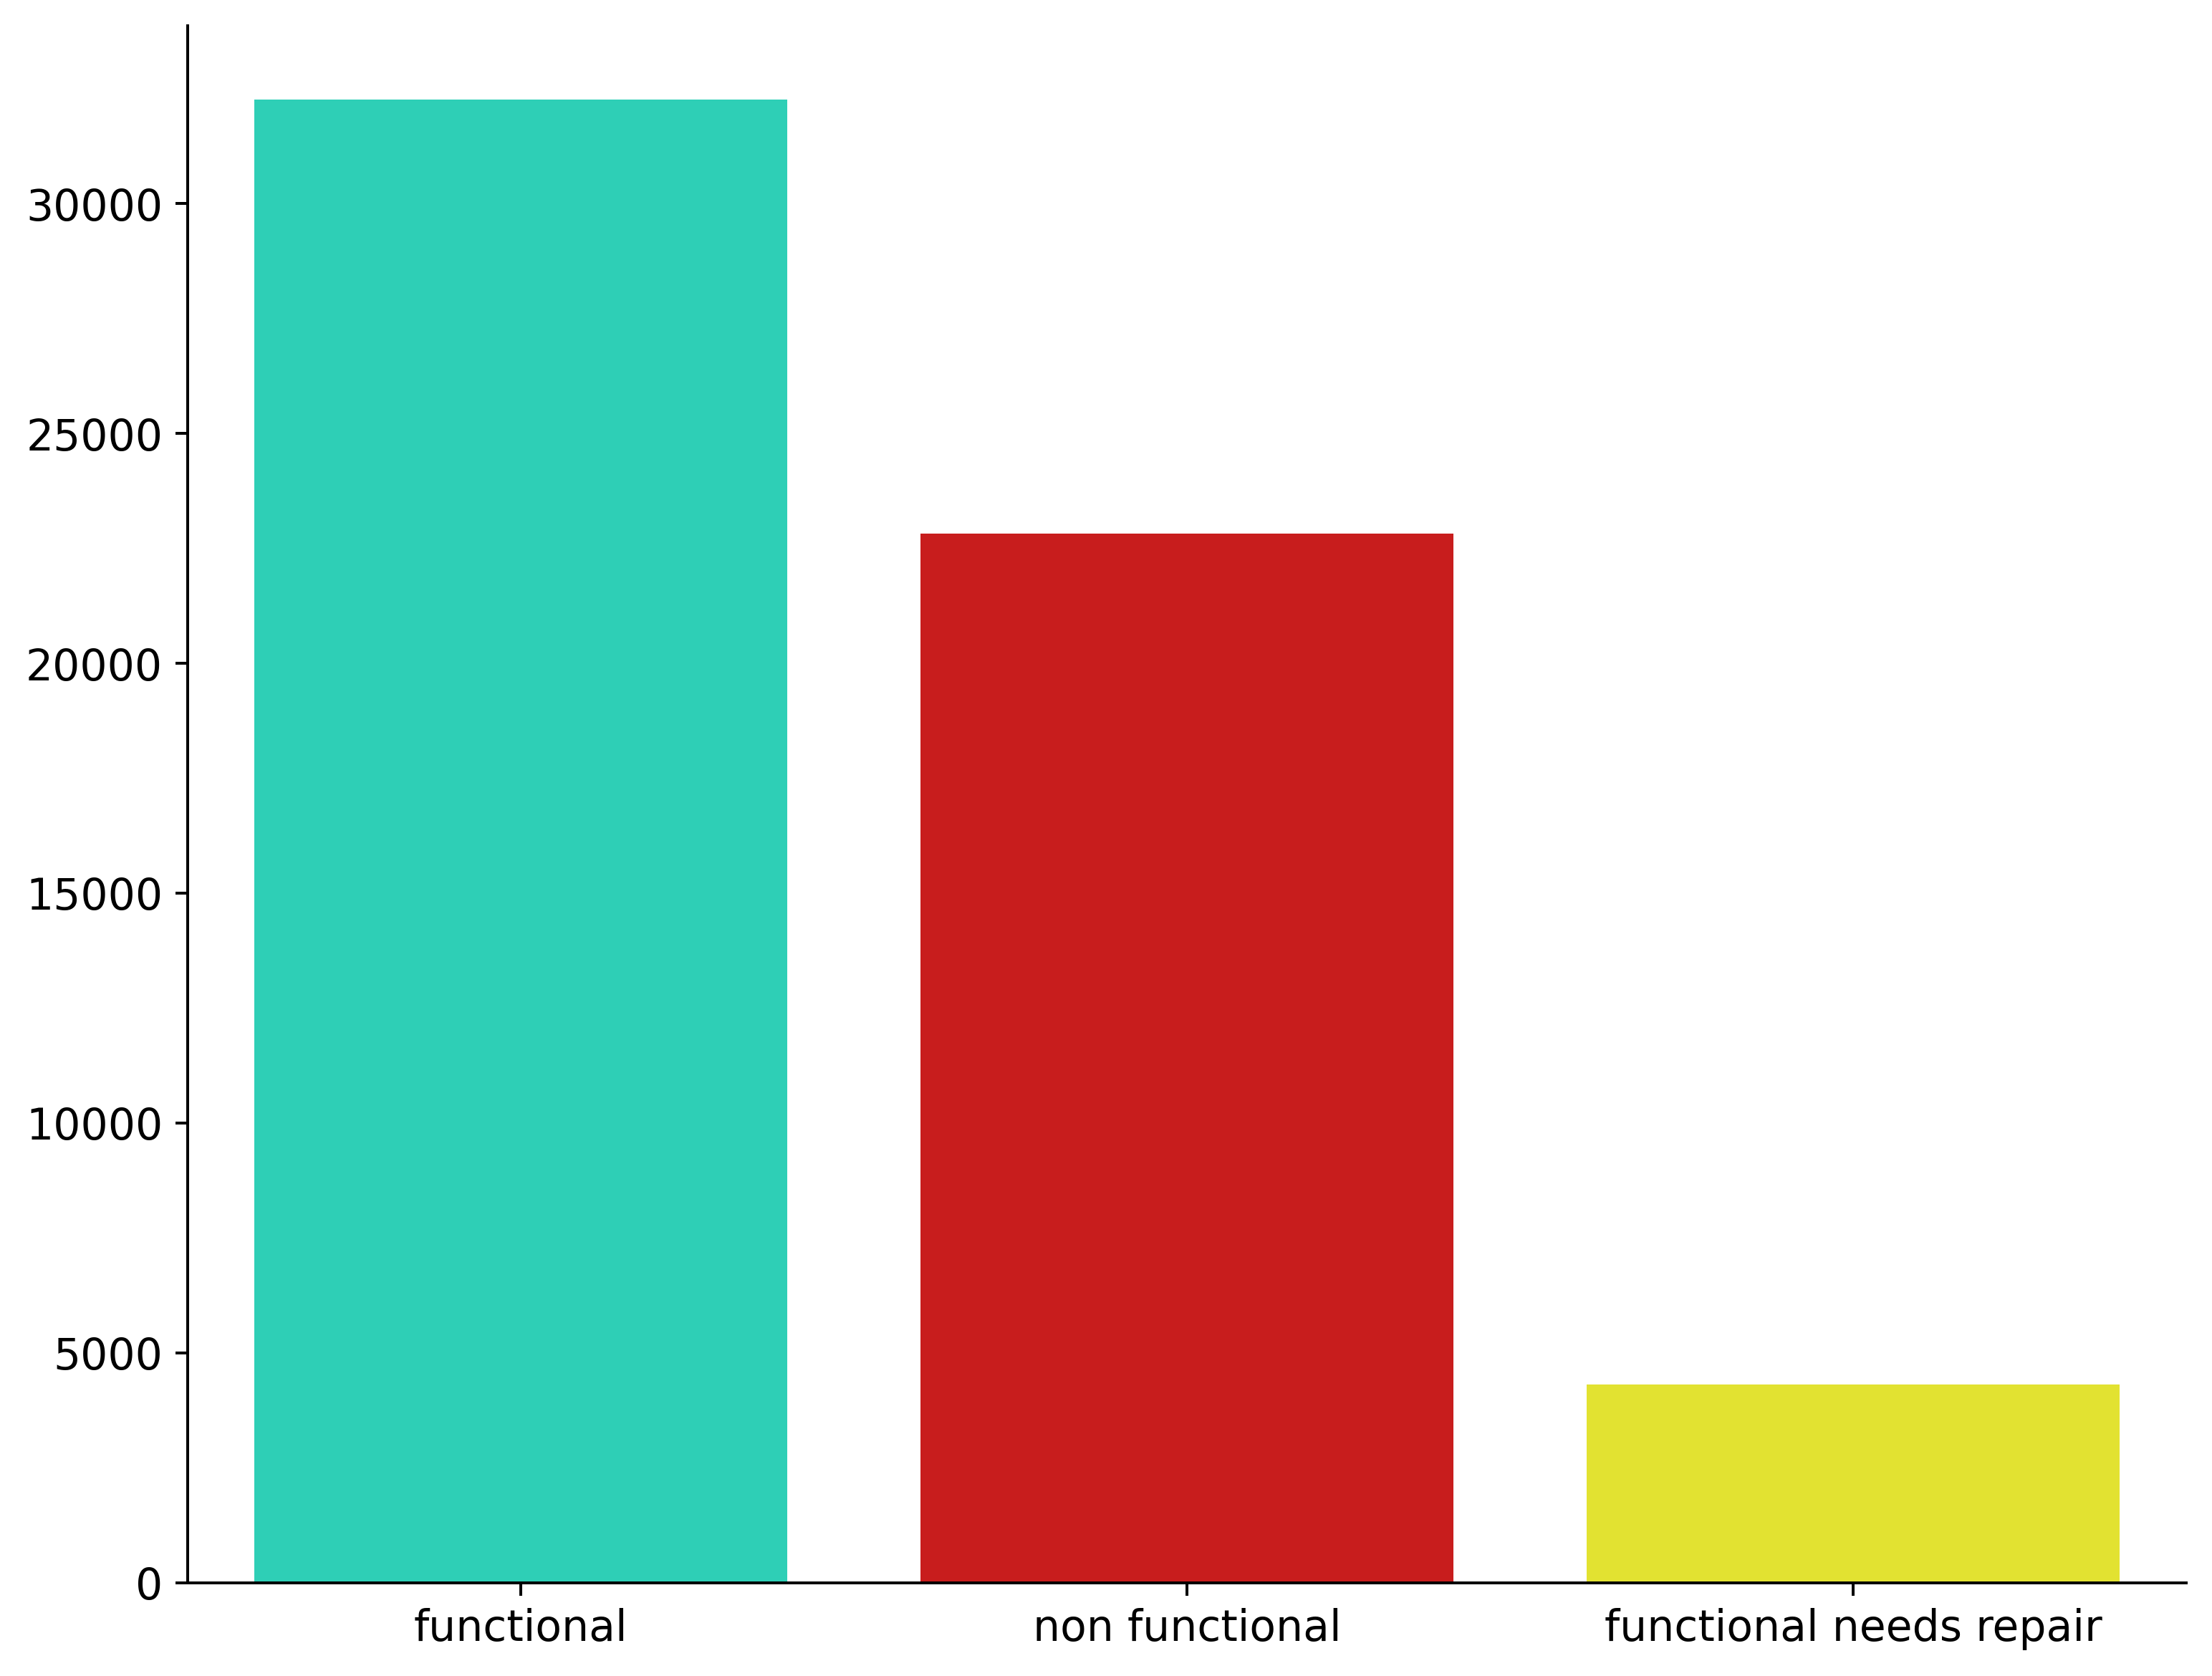

In [22]:
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(x = labels_vc.index, y = labels_vc.values, palette=palette, ax=ax)
plt.rcParams['figure.dpi'] = 360
# sns.set(style="whitegrid")
plt.xlabel('')
plt.ylabel('')
plt.title('')
plt.xticks(size=12)
plt.yticks(size=12)
sns.despine();

We can clearly see that class 'functional needs repair' has a small number of objects comparing to 'functional' and 'non functional'.
We might consider implying weights in future modeling.

In [23]:
train = train.join(target['status_group'])

## Feature Analysis

In [24]:
train.dtypes

amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_type              object
water_qual

### Missing Data

Fist of all, we will start from looking for missing data

In [25]:
columns_with_nans = train.isnull().sum()[train.isnull().sum() > 0]
columns_with_nans

funder                3635
installer             3655
subvillage             371
public_meeting        3334
scheme_management     3877
scheme_name          28166
permit                3056
dtype: int64

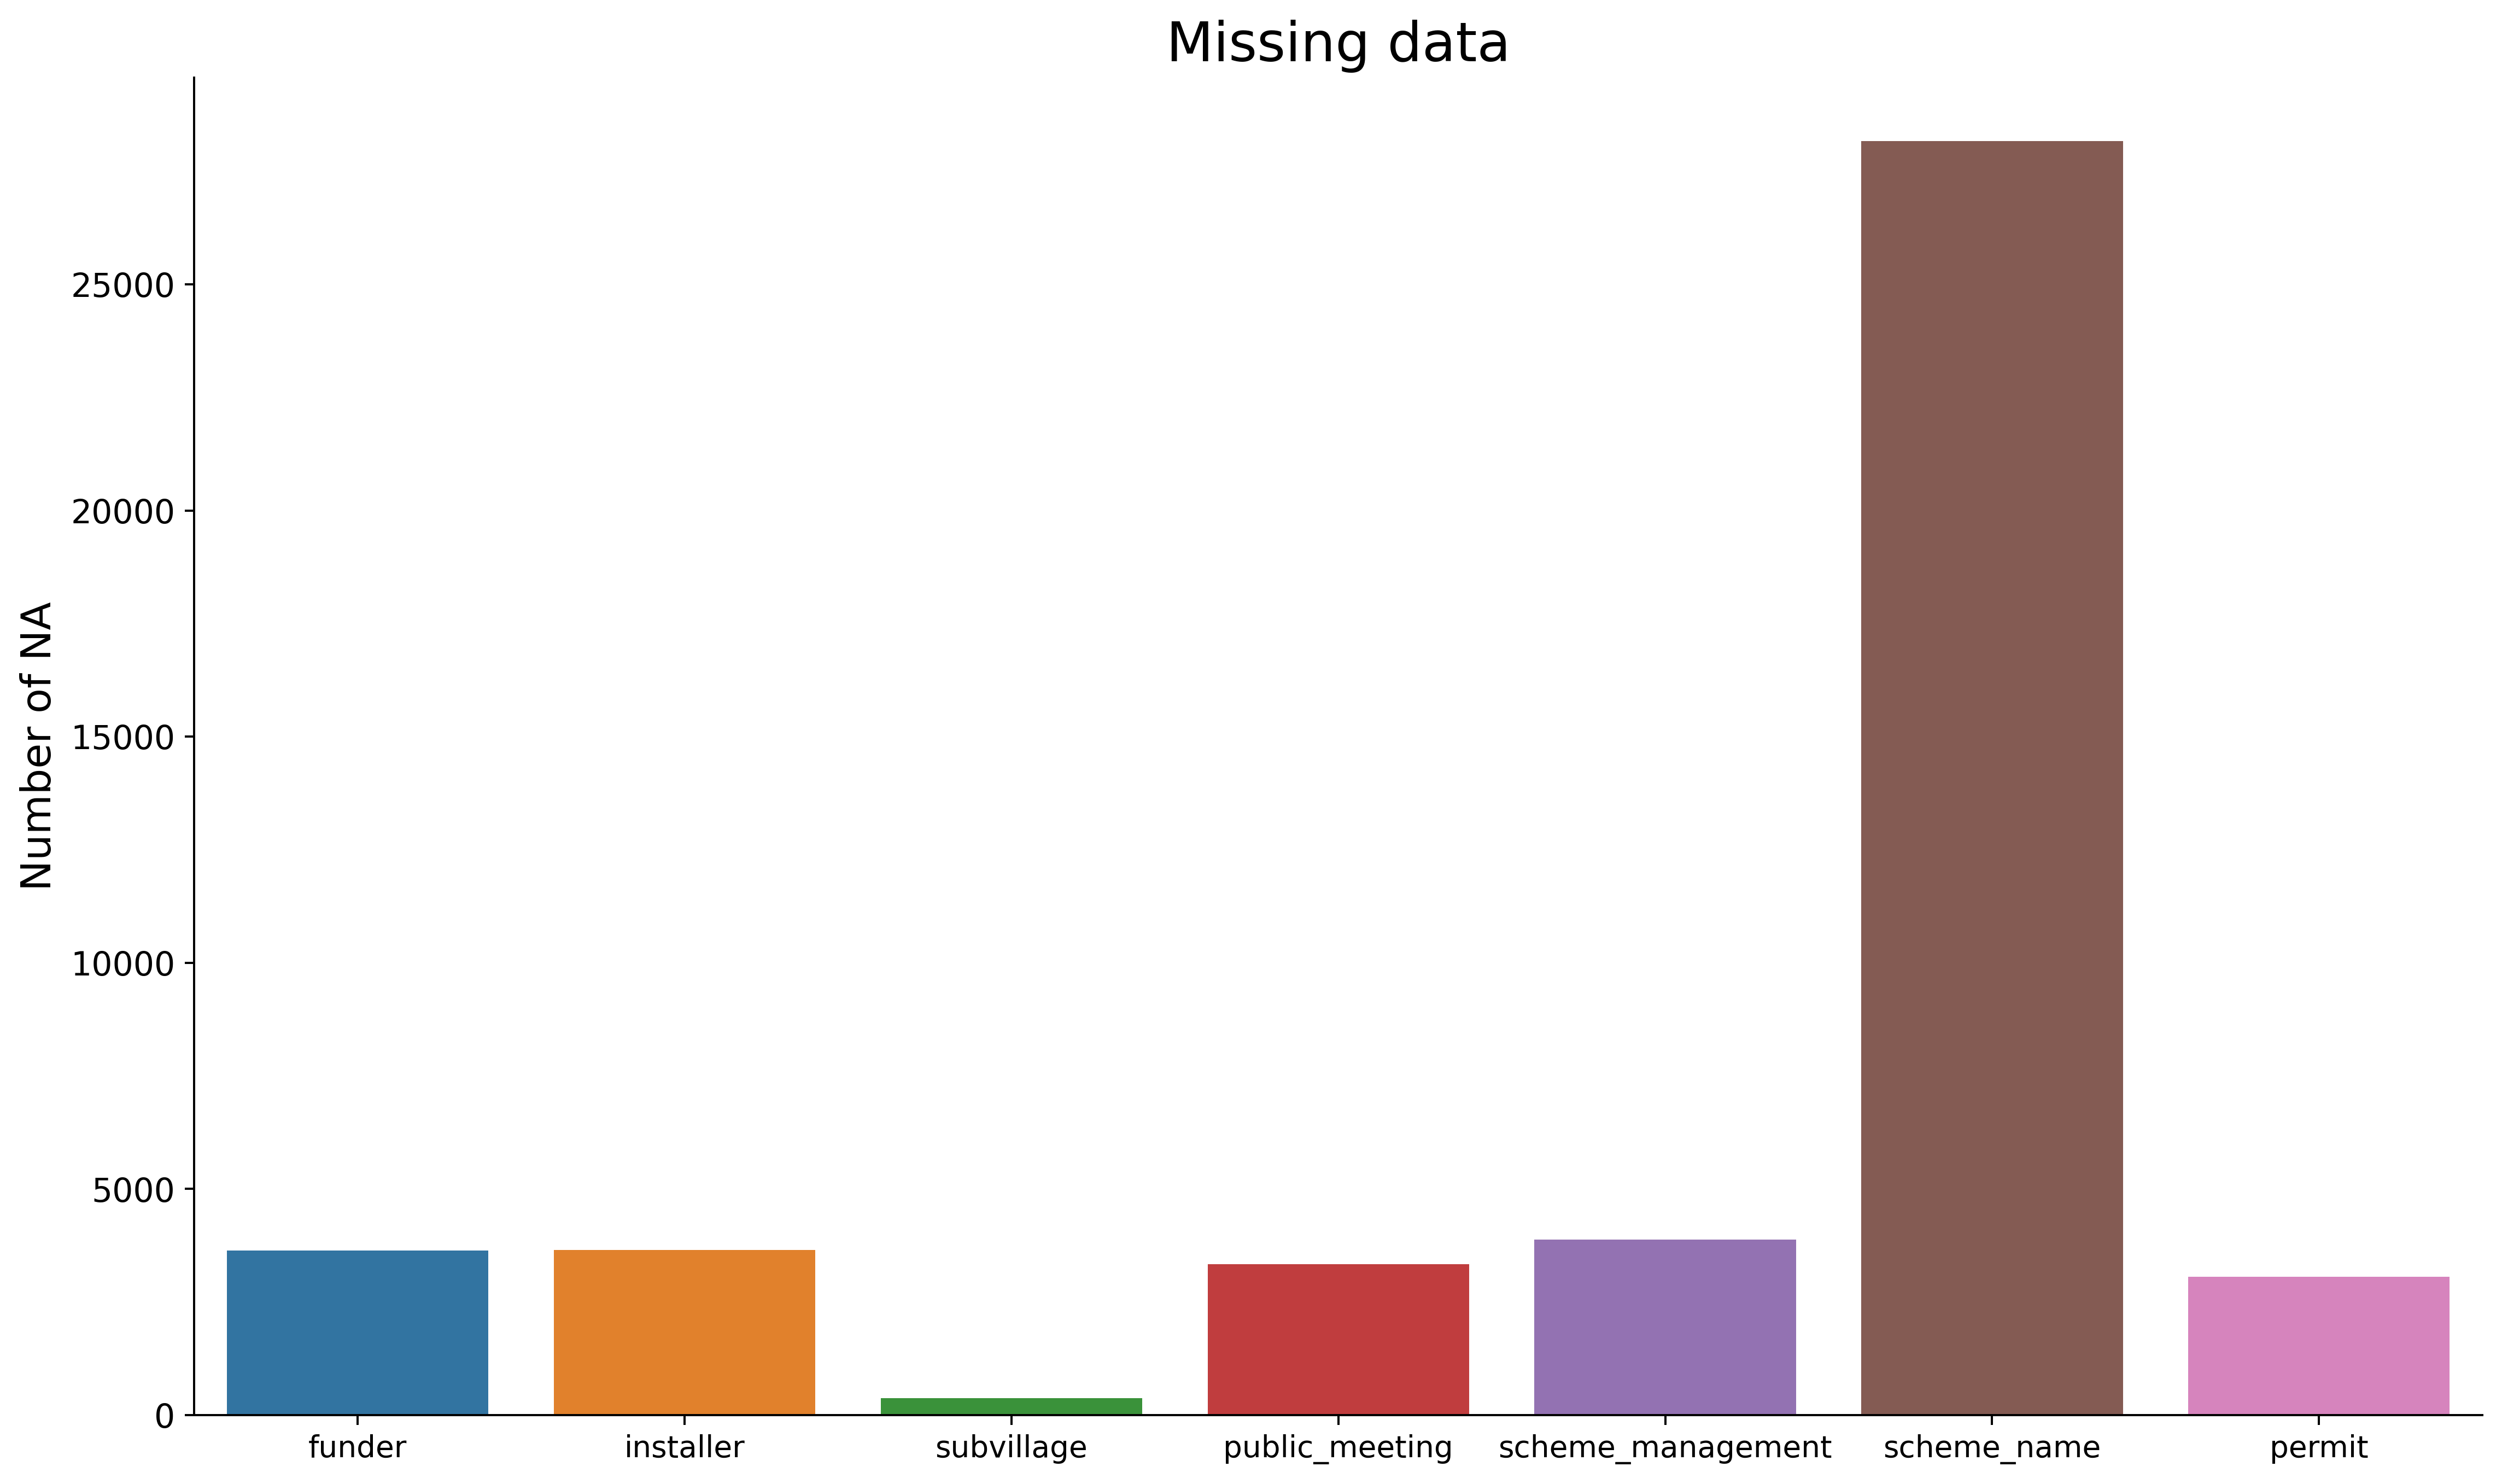

In [26]:
fig, ax = plt.subplots(figsize=(15,9))
sns.barplot(x = columns_with_nans.index, y = columns_with_nans.values, ax=ax)
plt.rcParams['figure.dpi'] = 360
# sns.set(style="whitegrid")
plt.xlabel('')
plt.ylabel('Number of NA', size = 15)
plt.title('Missing data', size = 20)
plt.xticks(size=11)
plt.yticks(size=12)
sns.despine();

Categorical features have NA values. Among all scheme_name has most missing data and consider careful revising.

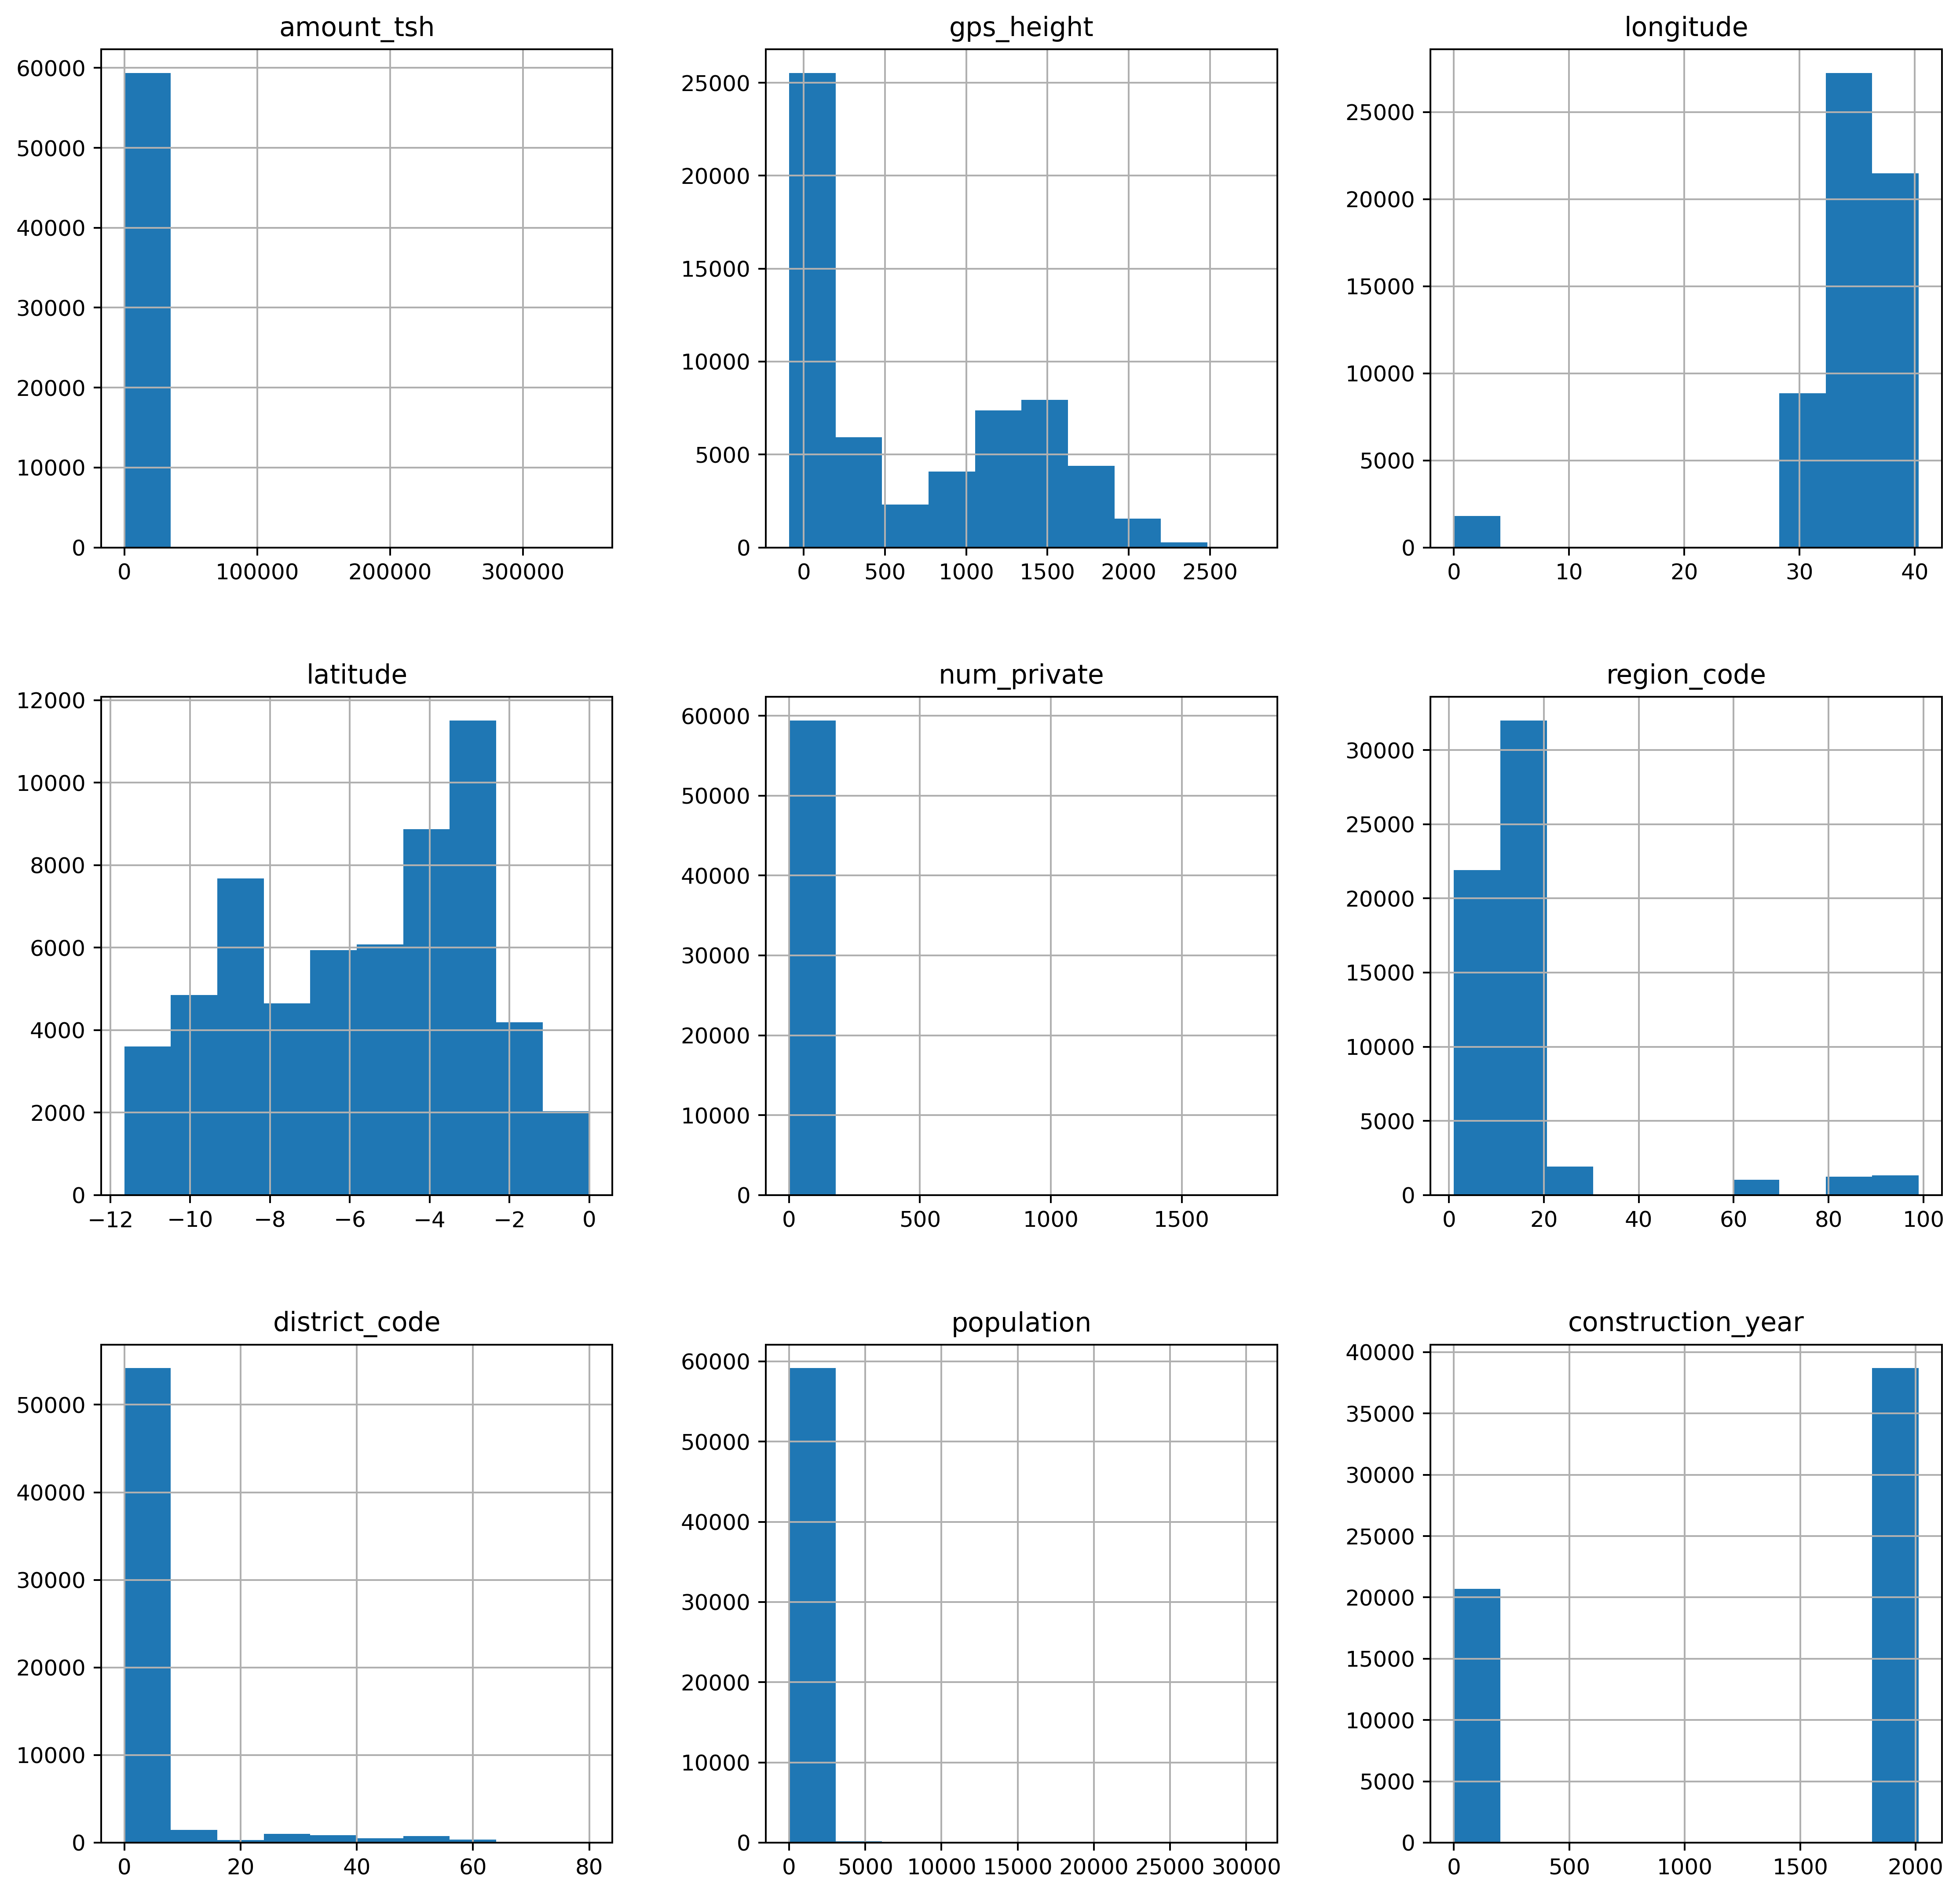

In [27]:
train.hist(figsize=(15,15));

**amount_tsh** and **population** are true numerical features of this dataset. Let's take a closer look on distribution of their values

In [28]:
amount_tsh_vc = train.amount_tsh.value_counts()
amount_tsh_vc

0.0         41639
500.0        3102
50.0         2472
1000.0       1488
20.0         1463
            ...  
8500.0          1
6300.0          1
220.0           1
138000.0        1
12.0            1
Name: amount_tsh, Length: 98, dtype: int64

In [29]:
populatin_vs = train.population.value_counts()
populatin_vs

0       21381
1        7025
200      1940
150      1892
250      1681
        ...  
3241        1
1960        1
1685        1
2248        1
1439        1
Name: population, Length: 1049, dtype: int64

Too many zeros. They can be either real data or missing data.

**contraction_year** has a lot of zeros; this is missing data

In [30]:
train.construction_year.value_counts()

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: construction_year, dtype: int64

### Correlation plot of numerical features

In [31]:
df_corr = train.corr()

Text(0.5, 1.0, 'Corr')

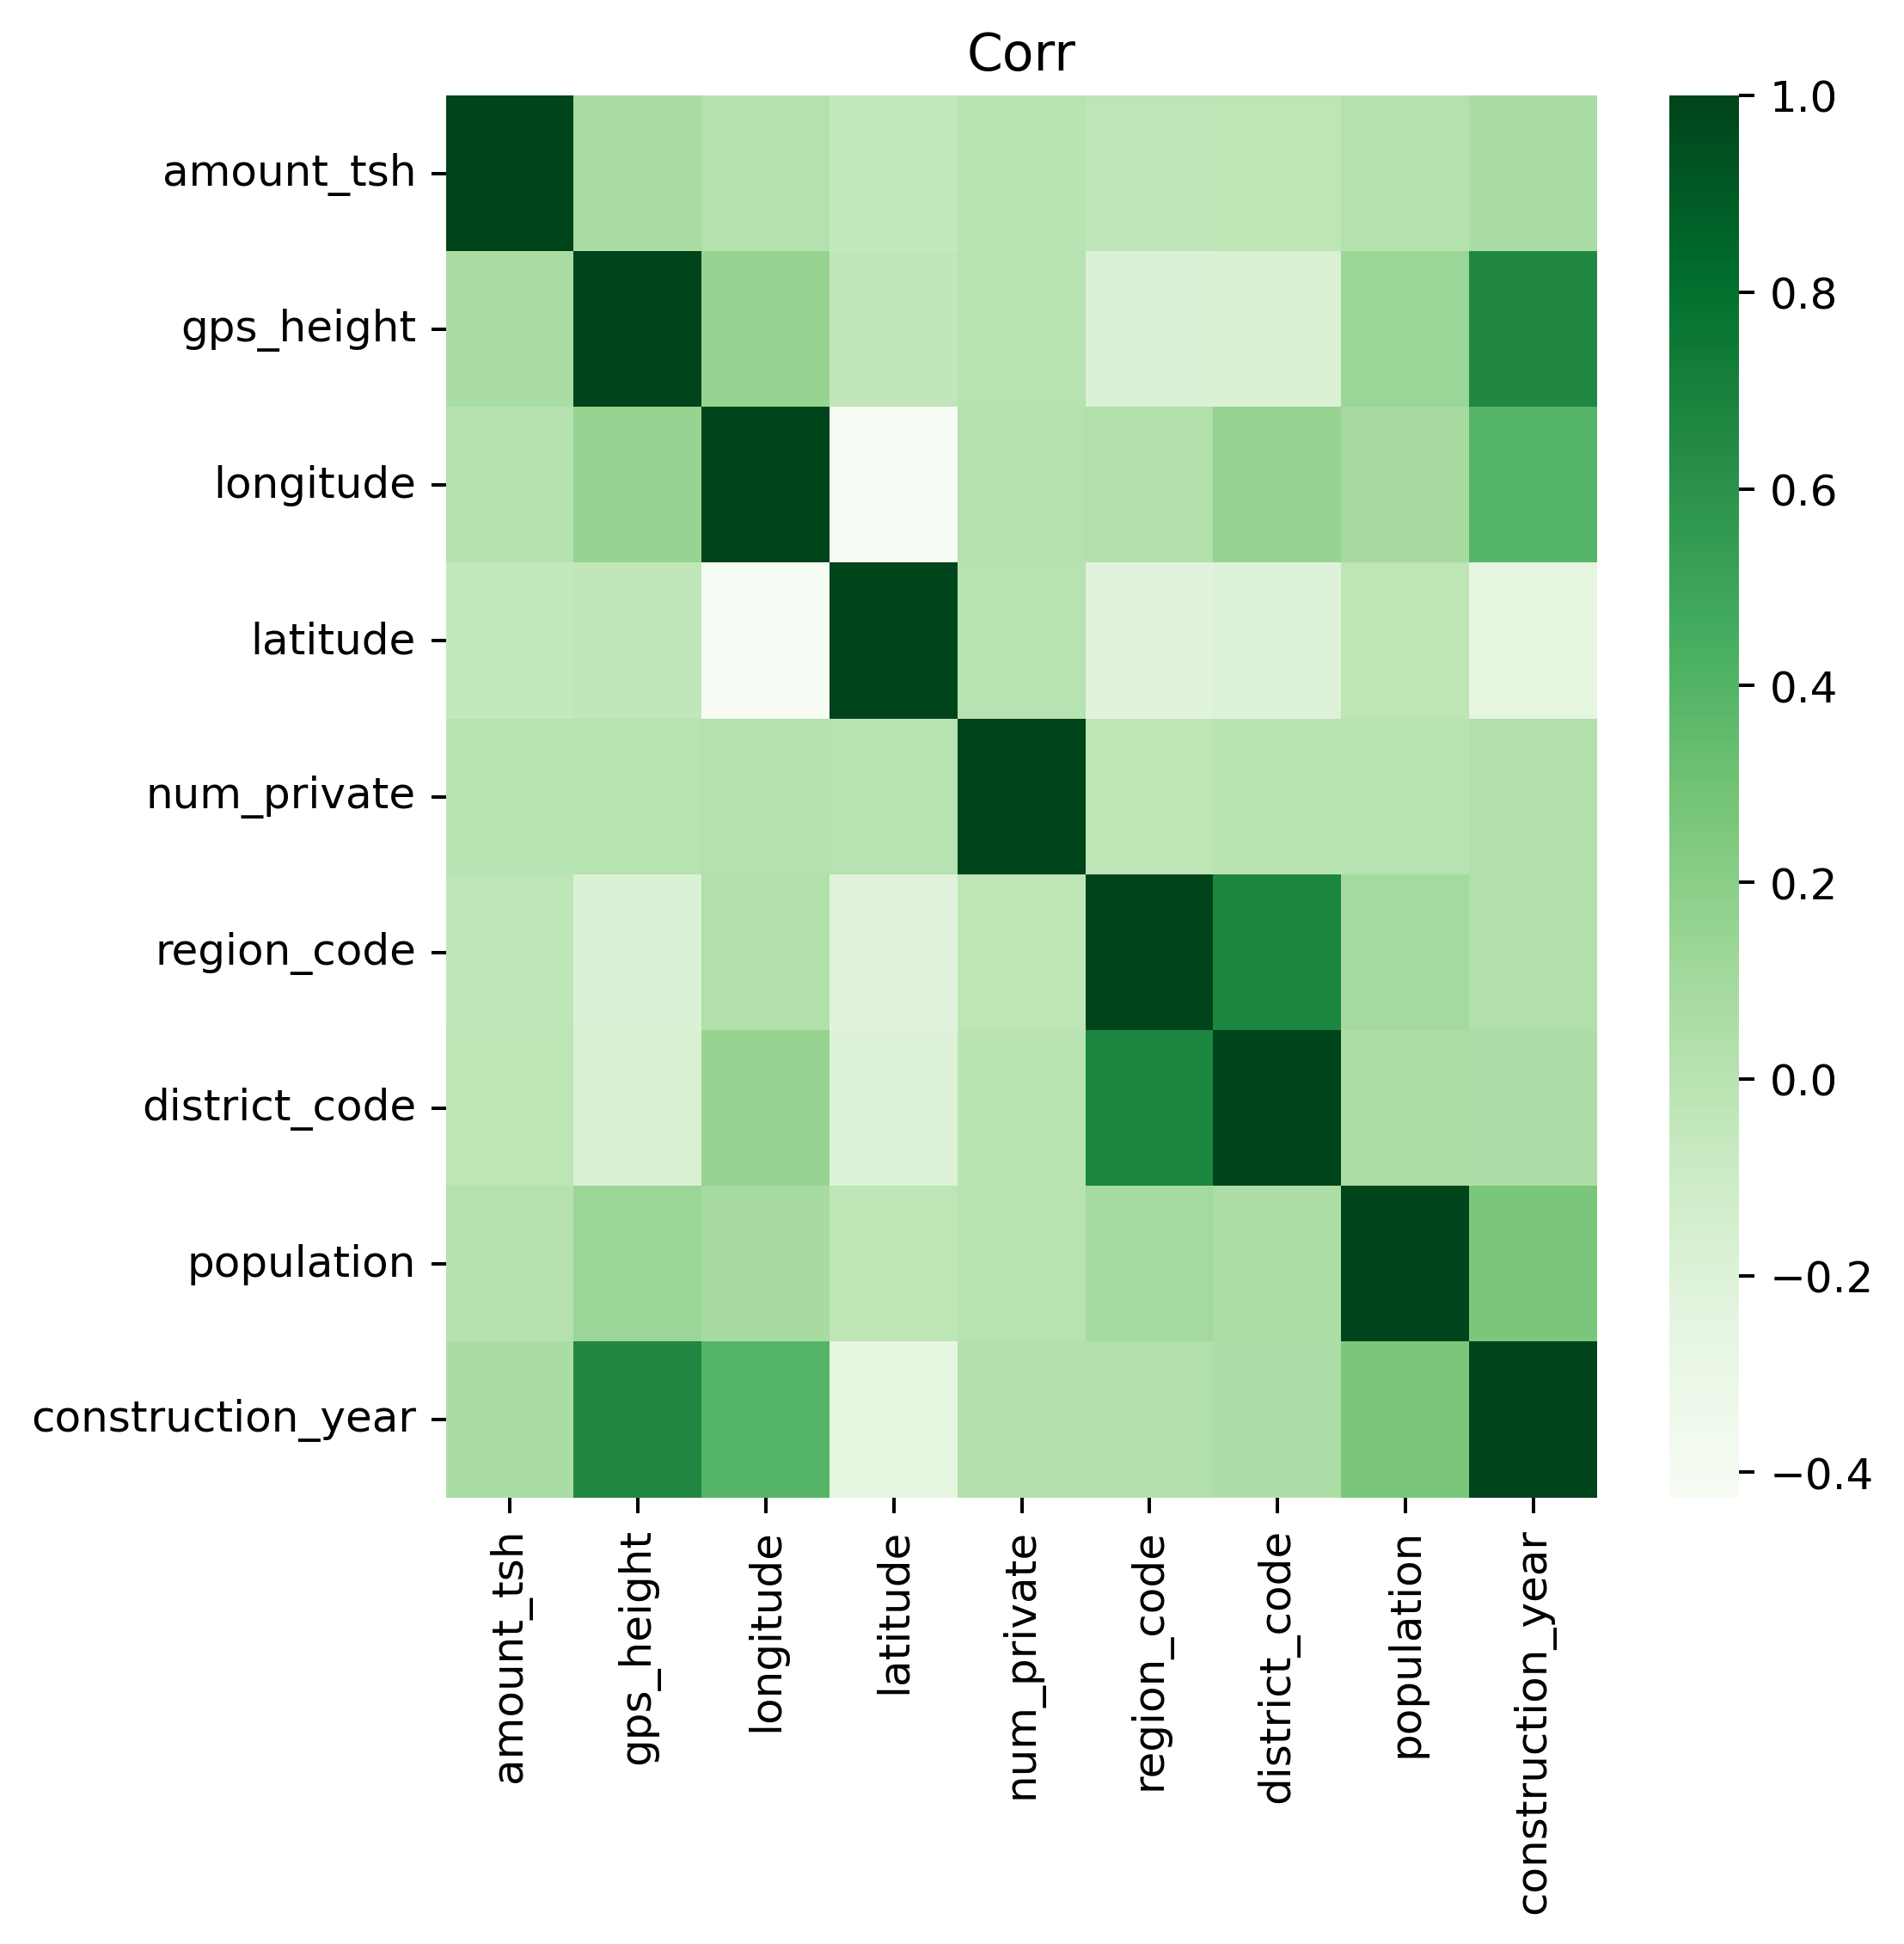

In [32]:
fig = plt.figure(figsize=(6,6))
r = sns.heatmap(df_corr, cmap="Greens")
r.set_title("Corr")

In [33]:
df_corr_cat = train[columns_with_nans.index].isnull().corr()

### Correlation plot of categorical features|

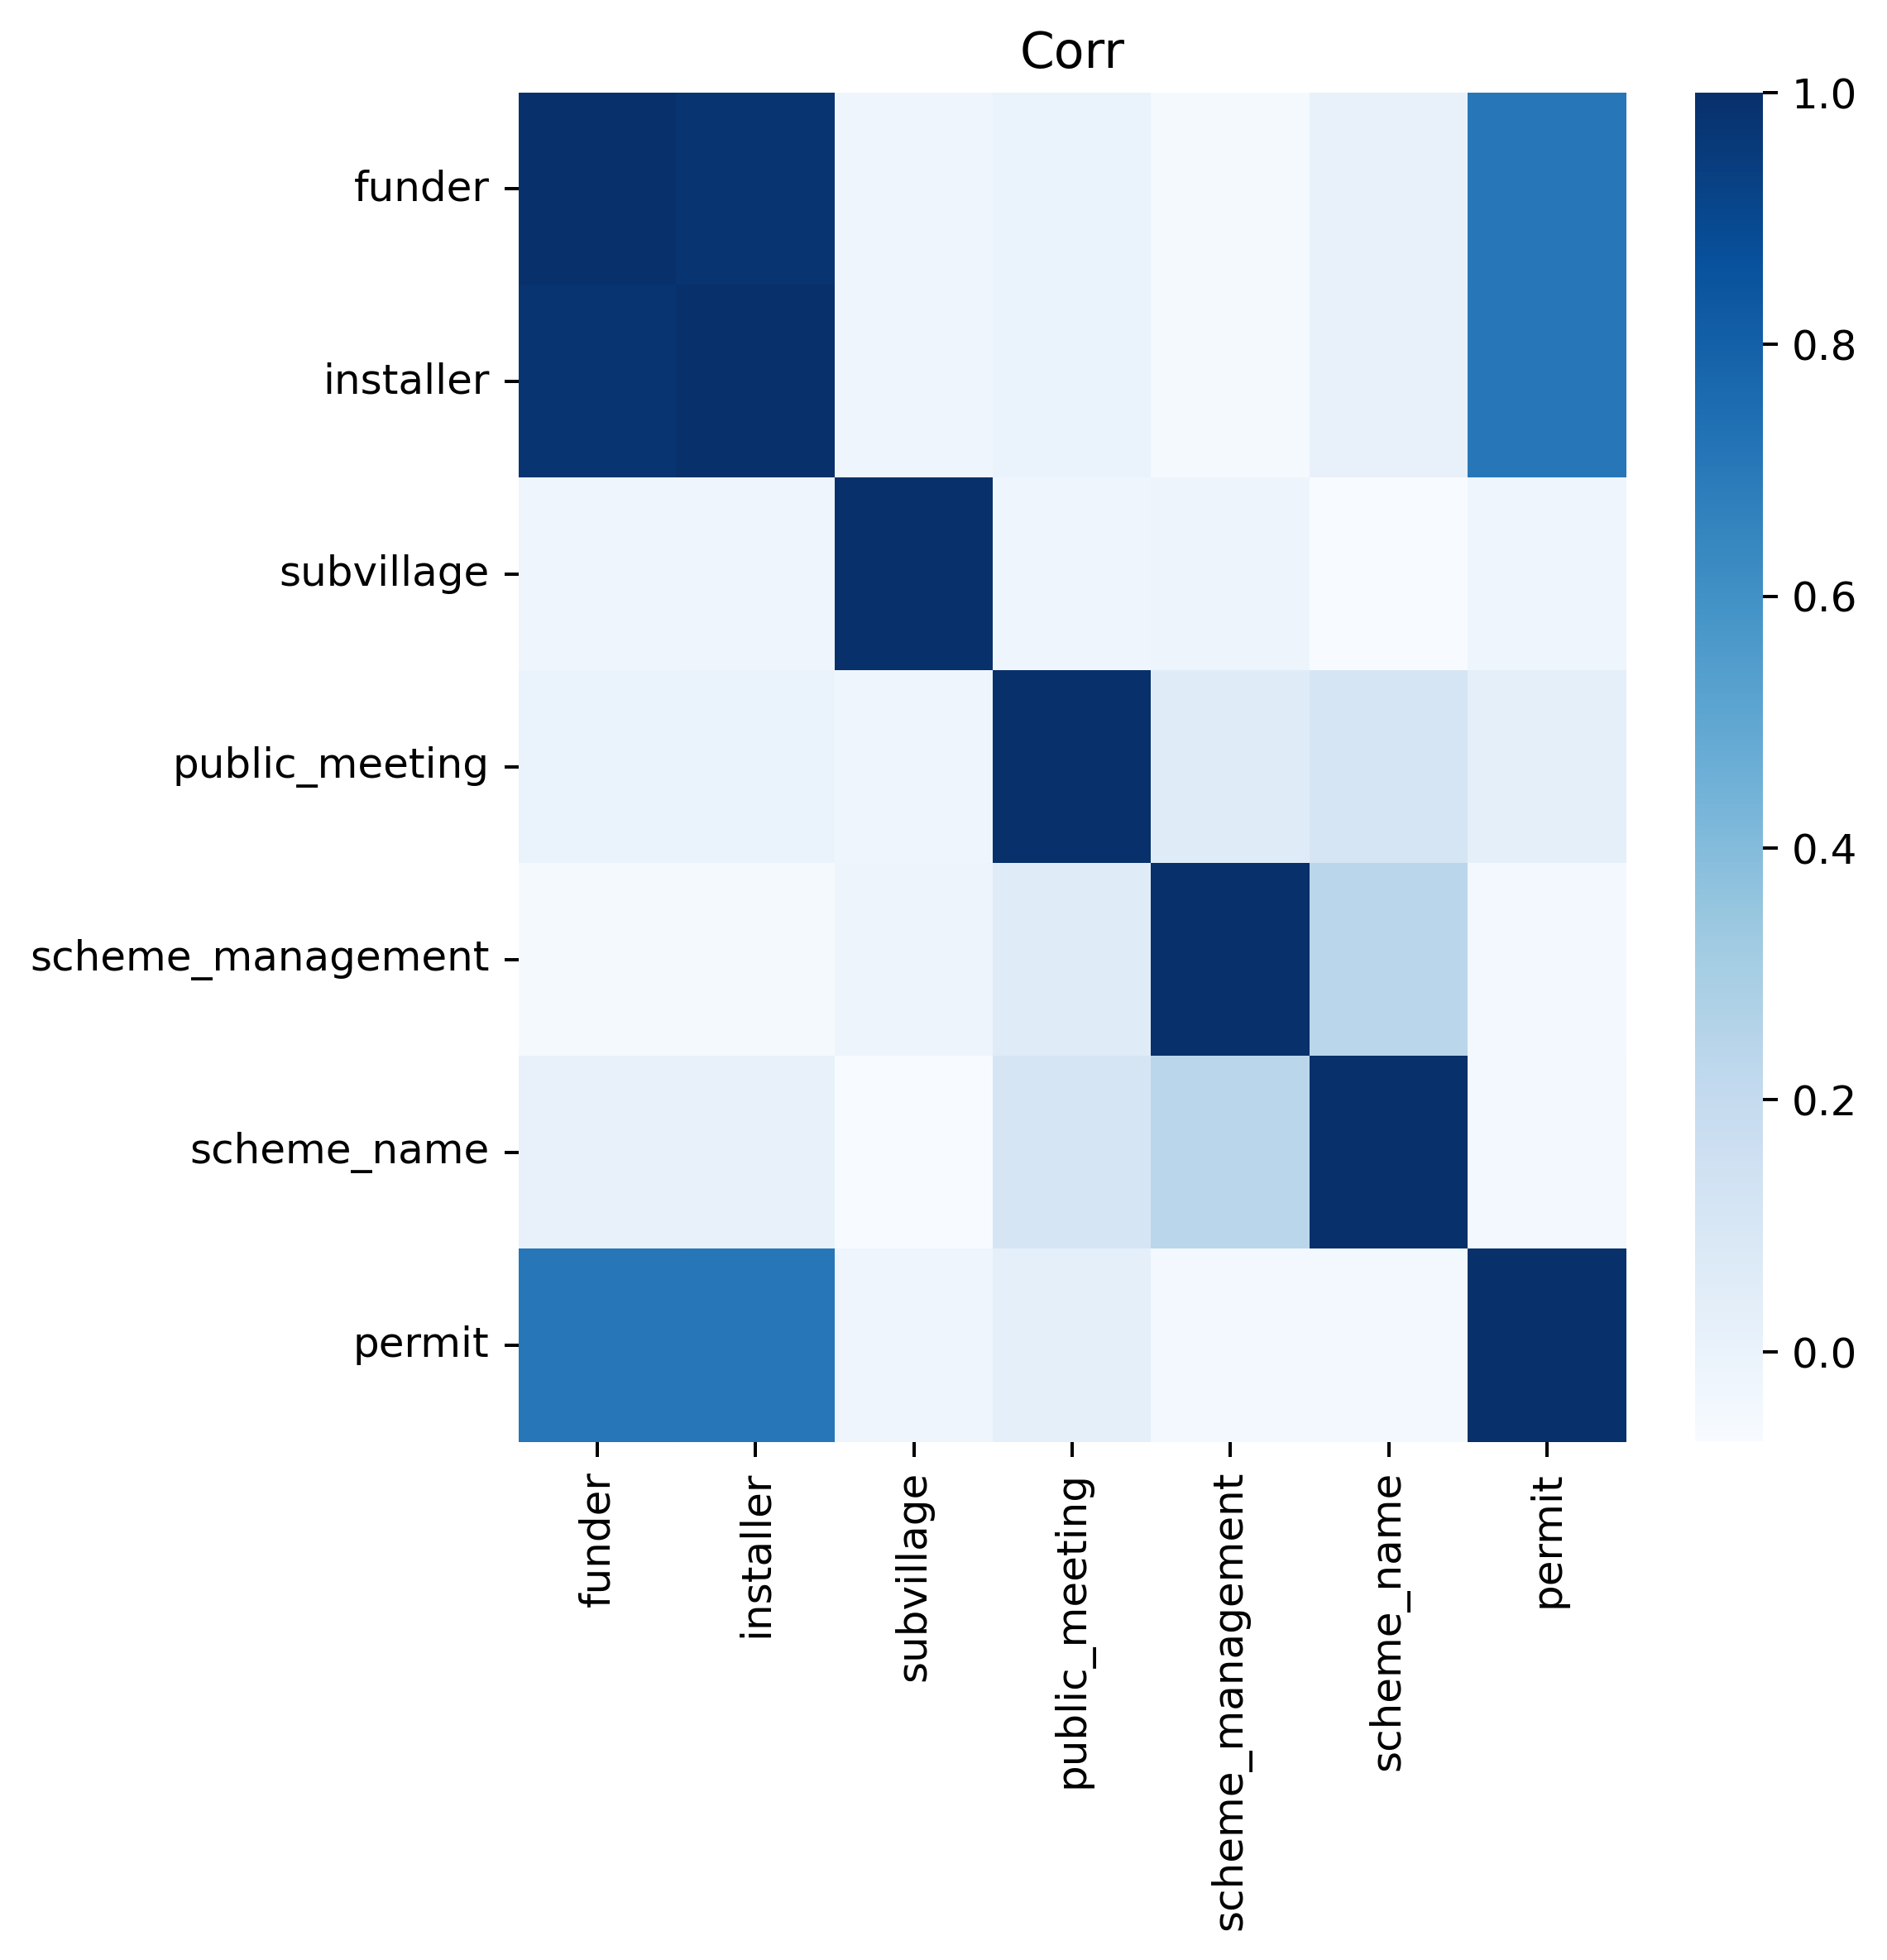

In [34]:
fig = plt.figure(figsize=(6,6))
r = sns.heatmap(df_corr_cat, cmap="Blues")
r.set_title("Corr");

**funder** strongly correlates with **installer**; **permit** correclates with **funder** and **installer**

In [35]:
train.dtypes[train.dtypes == 'object']

date_recorded            object
funder                   object
installer                object
wpt_name                 object
basin                    object
subvillage               object
region                   object
lga                      object
ward                     object
public_meeting           object
recorded_by              object
scheme_management        object
scheme_name              object
permit                   object
extraction_type          object
extraction_type_group    object
extraction_type_class    object
management               object
management_group         object
payment                  object
payment_type             object
water_quality            object
quality_group            object
quantity                 object
quantity_group           object
source                   object
source_type              object
source_class             object
waterpoint_type          object
waterpoint_type_group    object
status_group             object
dtype: o

### Categorical features grouped by class

In [36]:
intresting_features = ['region', 'basin', 
                       'extraction_type_class', 'management_group', 
                       'payment_type', 'quality_group', 'quantity_group',
                       'source', 'source_class', 'waterpoint_type_group']

#### Region

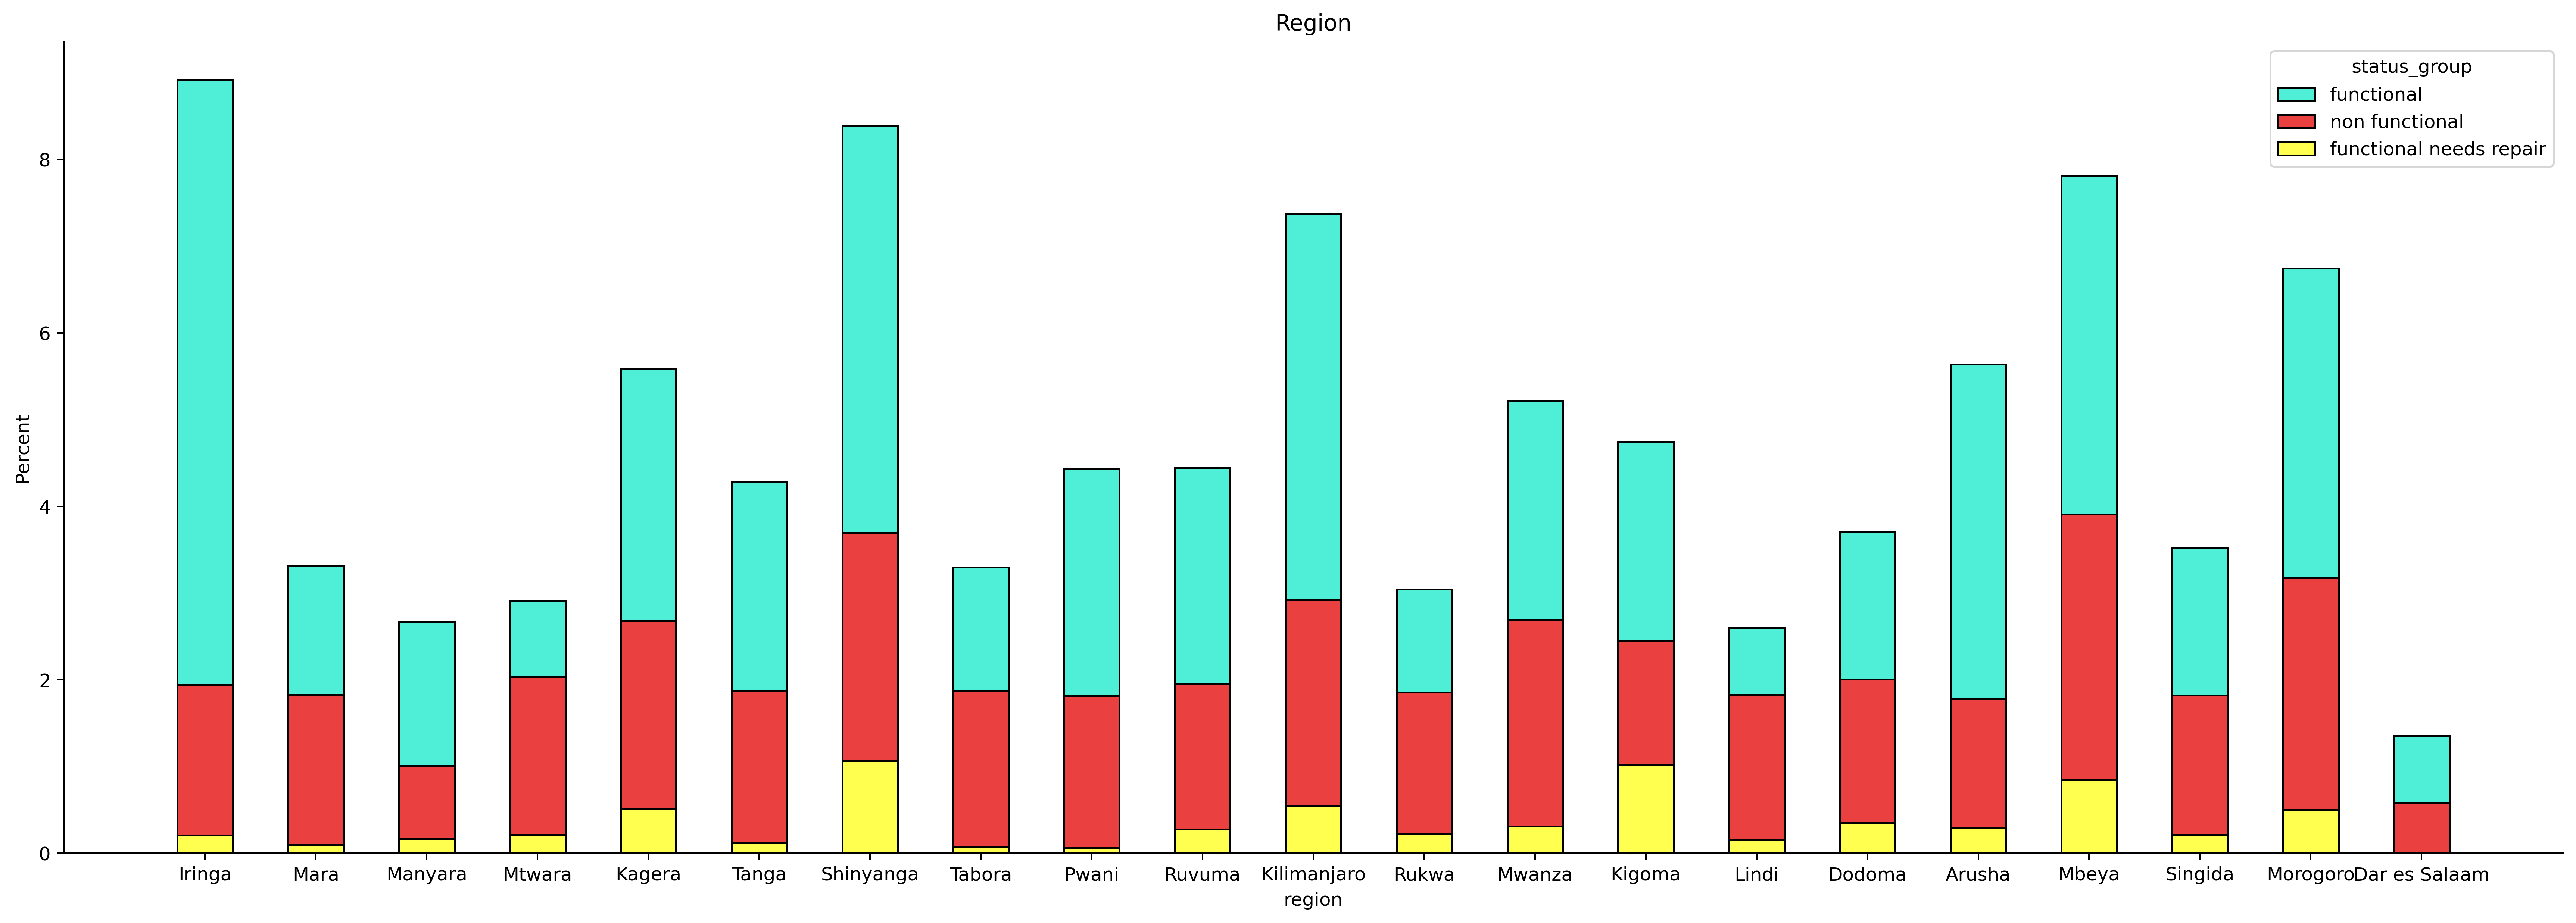

In [37]:
fig, ax = plt.subplots(figsize=(24,8))
sns.histplot(data=train, x='region', hue='status_group', shrink=0.5, multiple="stack", ax=ax, 
             palette=palette, stat='percent')
plt.rcParams['figure.dpi'] = 360
plt.title('Region')
sns.despine();

#### Basin

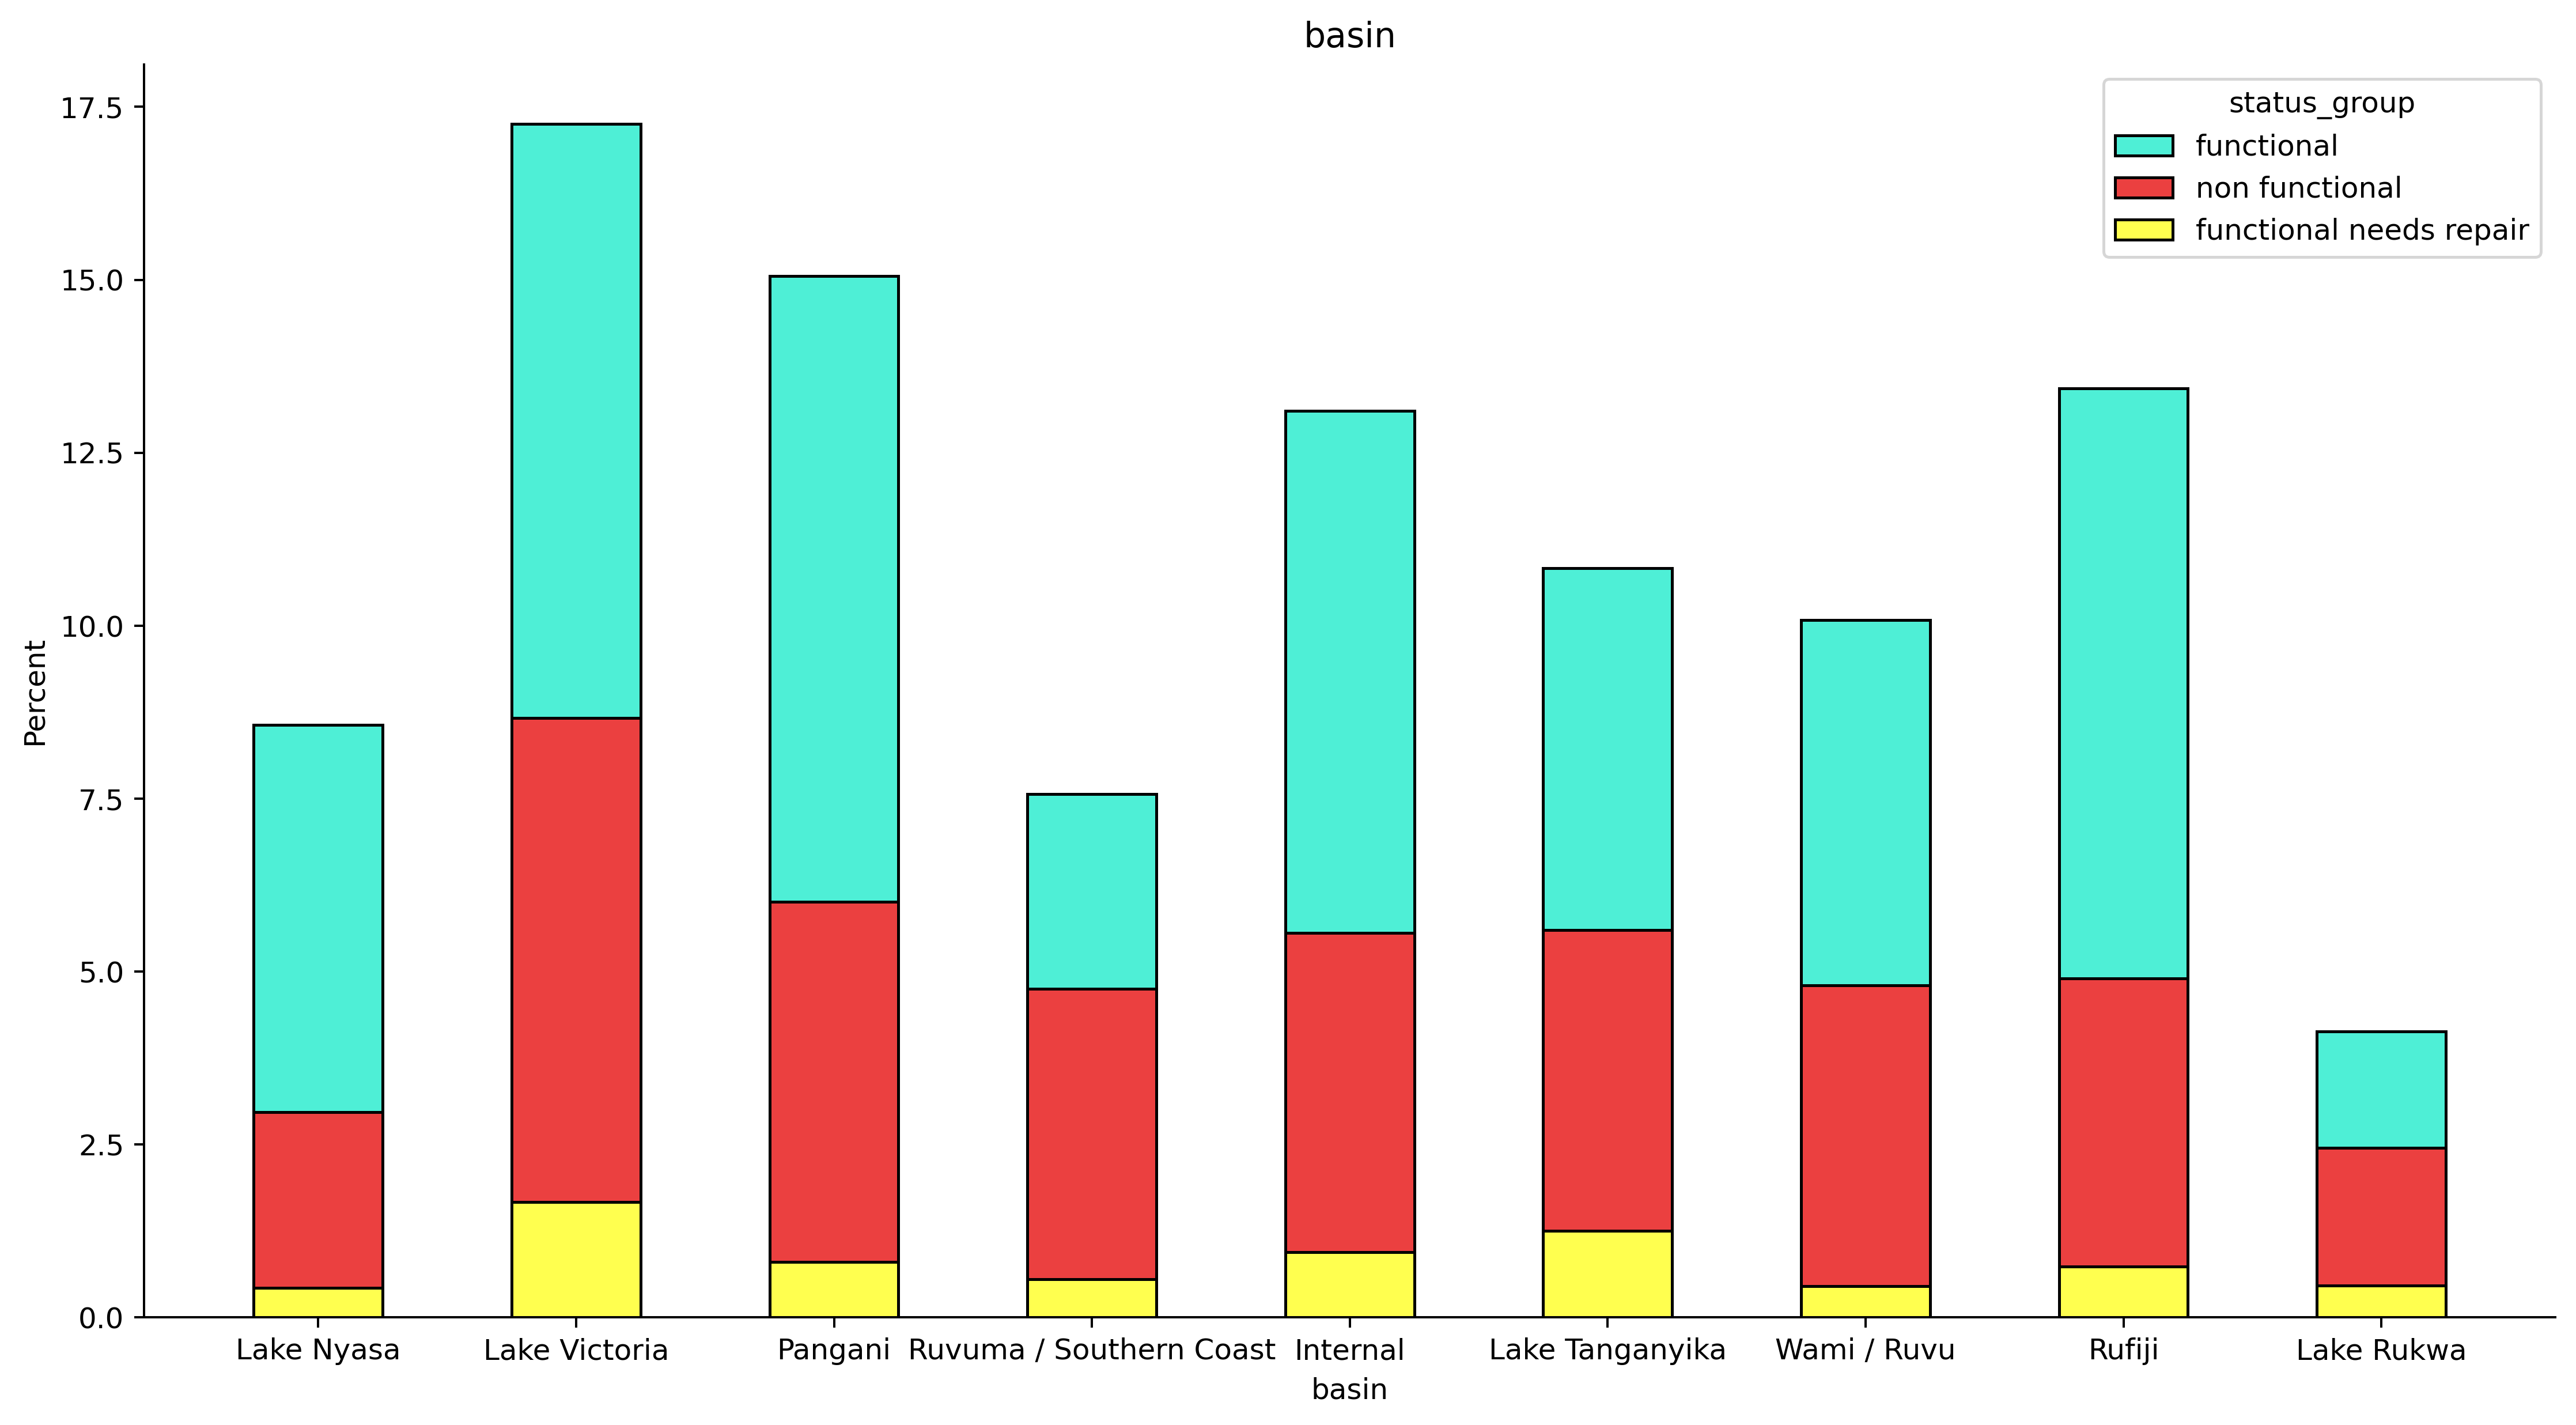

In [38]:
fig, ax = plt.subplots(figsize=(15,8))
sns.histplot(data=train, x='basin', hue='status_group', shrink=0.5, multiple="stack", 
                 ax=ax, 
             palette=palette, stat='percent')
plt.rcParams['figure.dpi'] = 360
sns.despine()
plt.title('basin')
plt.show()

#### Extraction_type

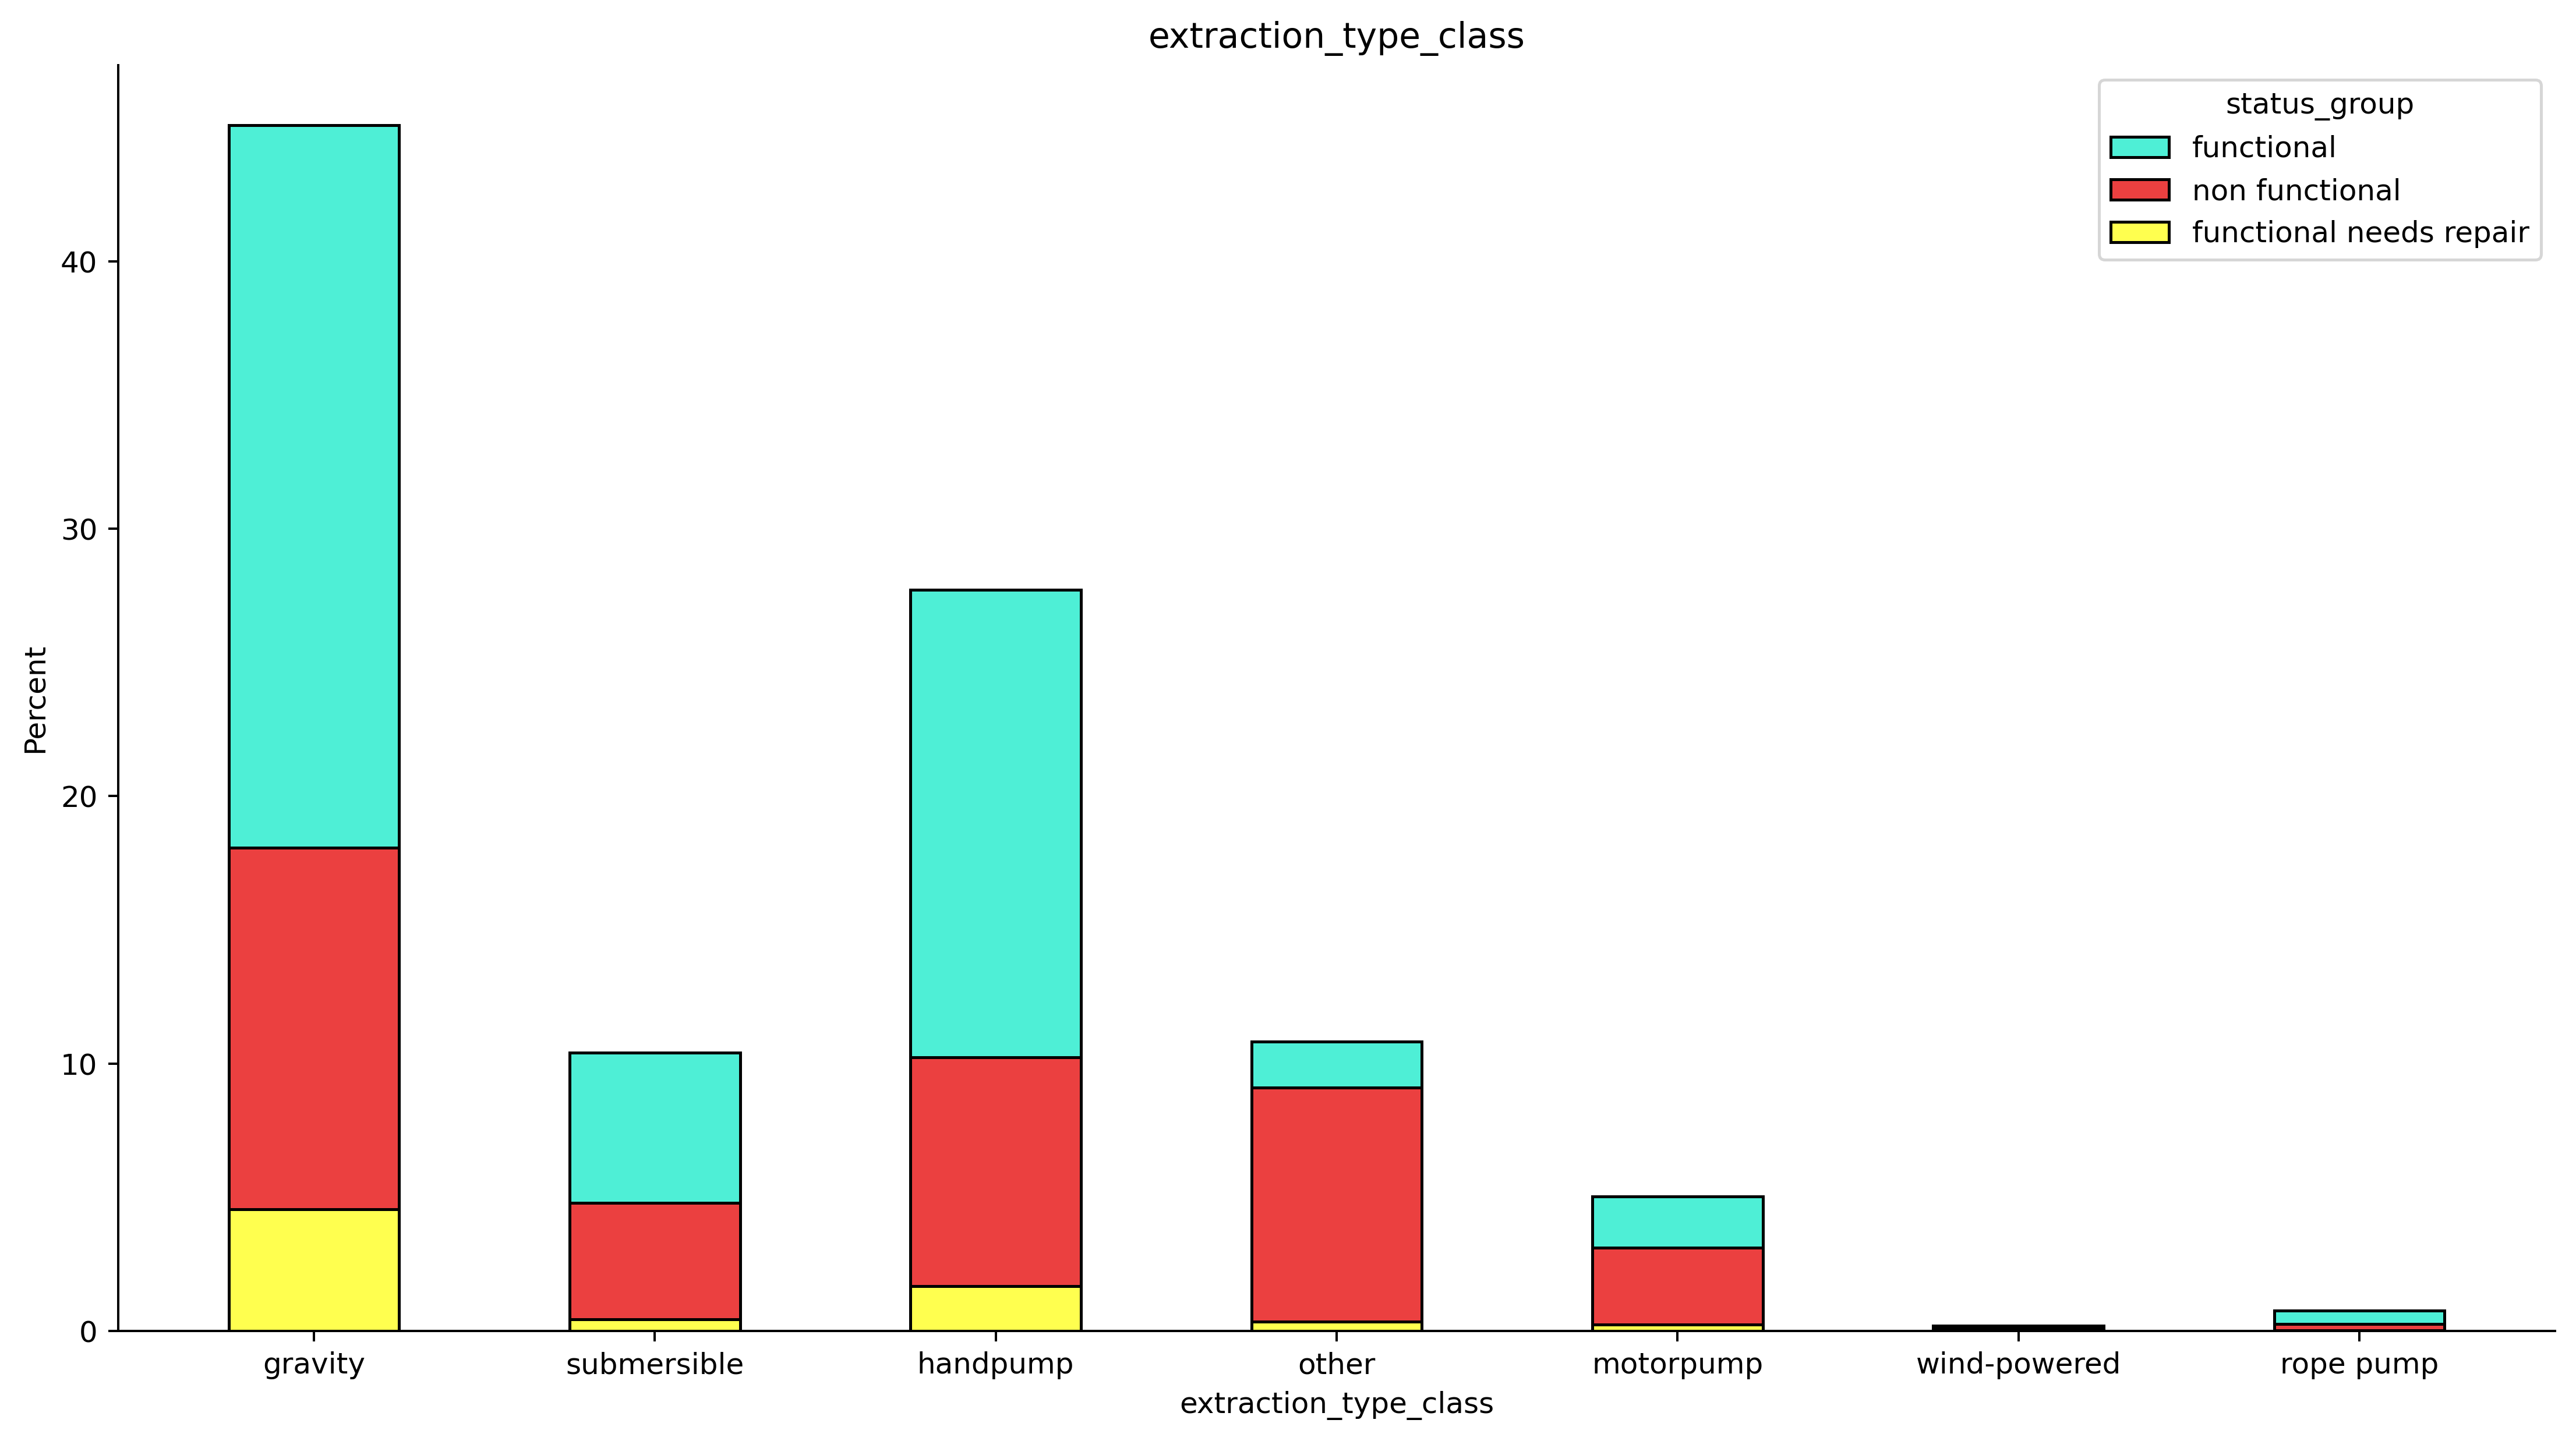

In [39]:
fig, ax = plt.subplots(figsize=(15,8))
sns.histplot(data=train, x='extraction_type_class', hue='status_group', shrink=0.5, multiple="stack", 
                 ax=ax, 
             palette=palette, stat='percent')
plt.rcParams['figure.dpi'] = 360
sns.despine()
plt.title('extraction_type_class')
plt.show()

#### Payment_type

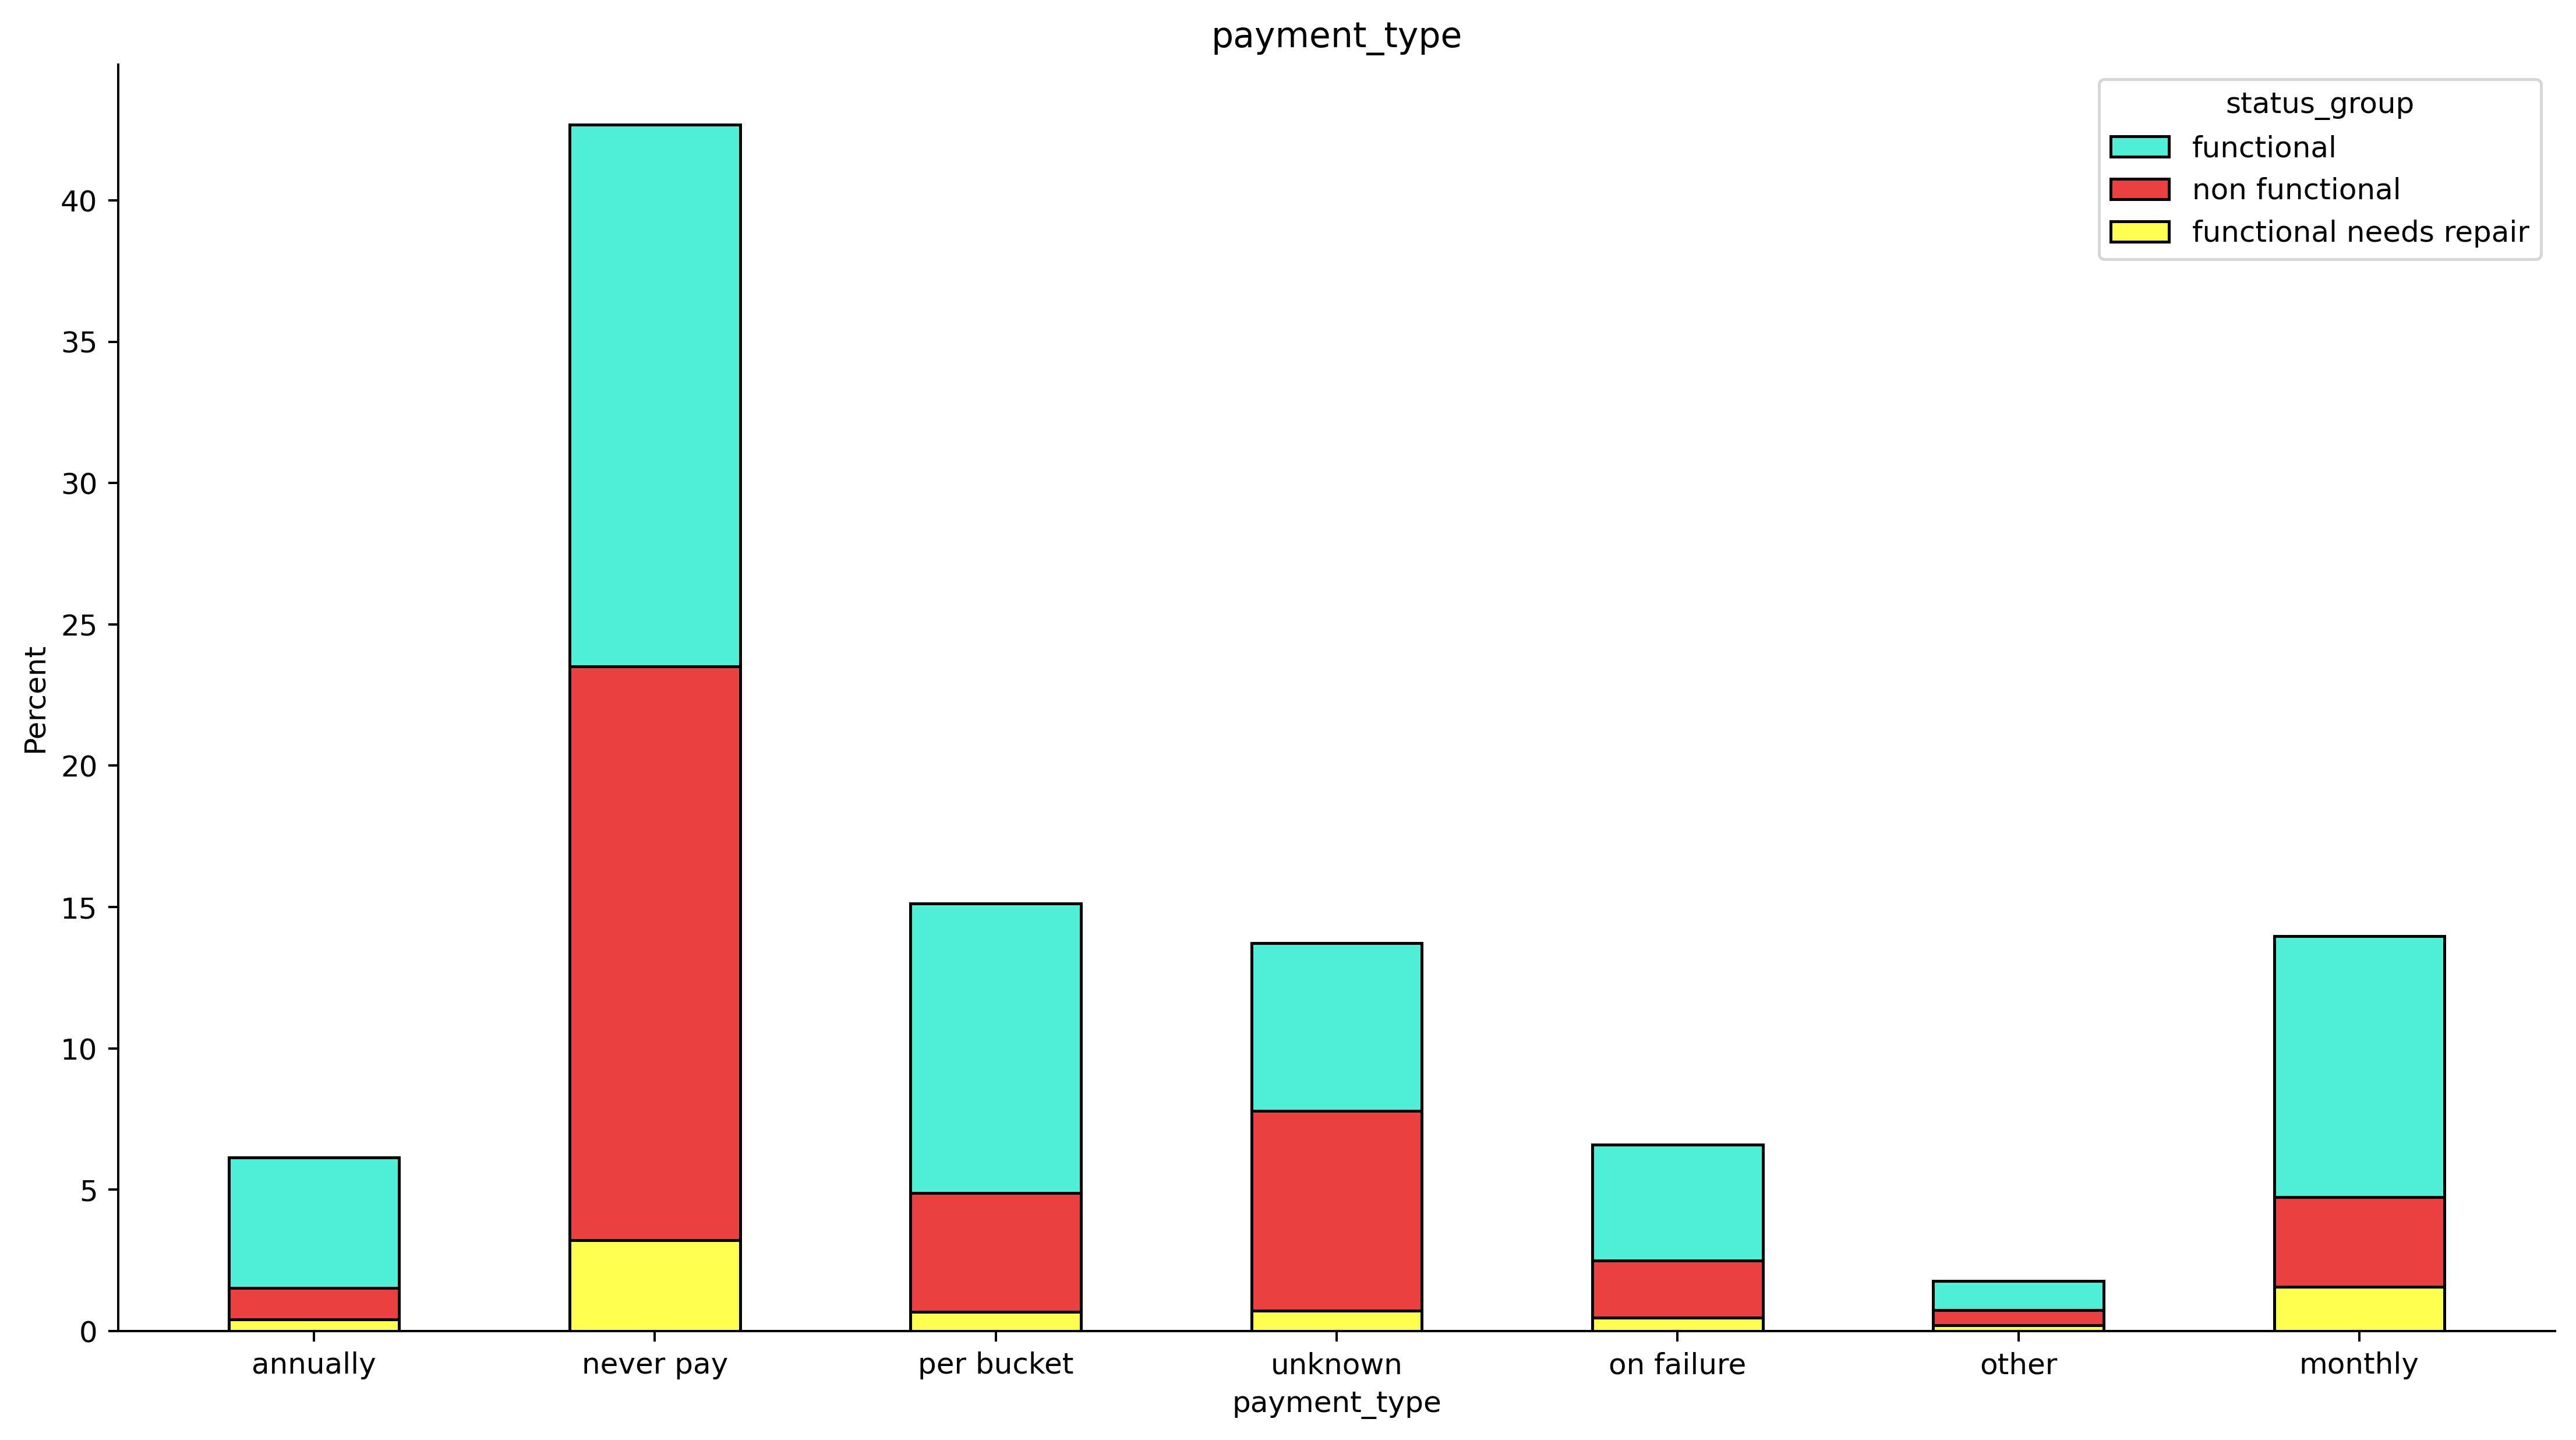

In [40]:
fig, ax = plt.subplots(figsize=(15,8))
sns.histplot(data=train, x='payment_type', hue='status_group', shrink=0.5, multiple="stack", 
                 ax=ax, 
             palette=palette, stat='percent')
plt.rcParams['figure.dpi'] = 360
sns.despine()
plt.title('payment_type')
plt.show()

Free waterpoints have the highest proportion of non-functional 

#### Quality group

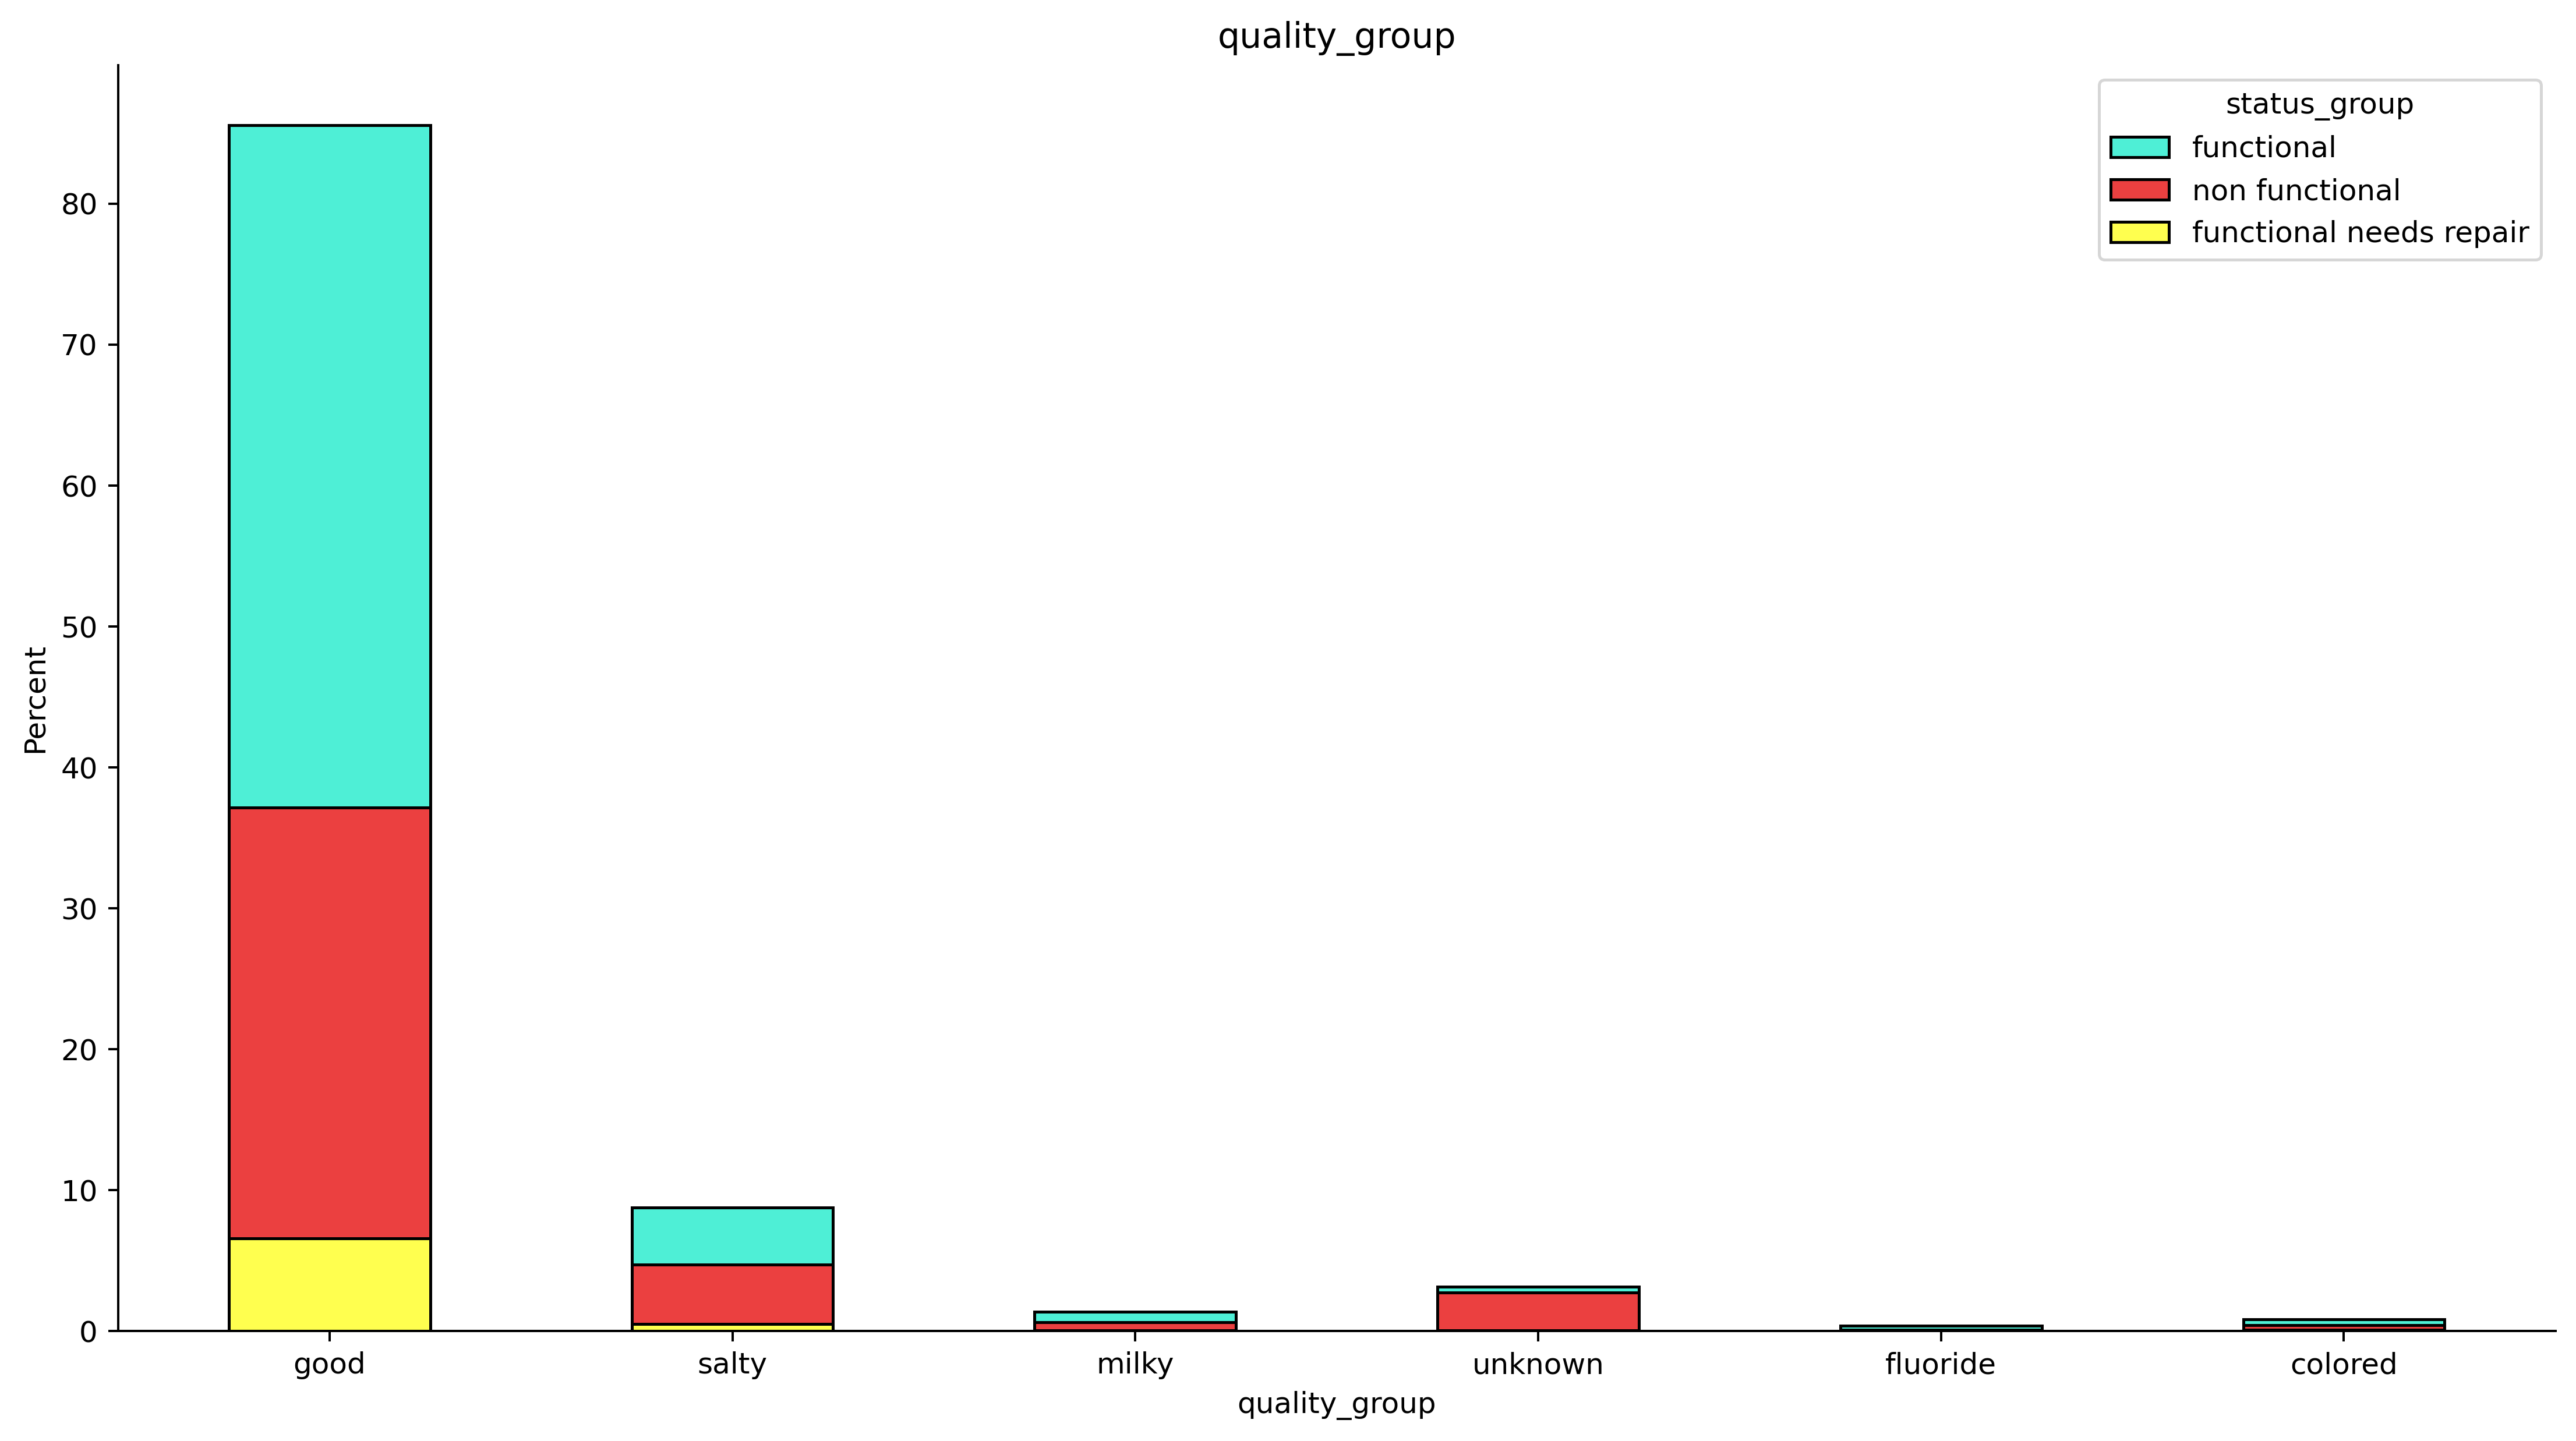

In [41]:
fig, ax = plt.subplots(figsize=(15,8))
sns.histplot(data=train, x='quality_group', hue='status_group', shrink=0.5, multiple="stack", 
                 ax=ax, 
             palette=palette, stat='percent')
plt.rcParams['figure.dpi'] = 360
sns.despine()
plt.title('quality_group')
plt.show()

#### Quantity group

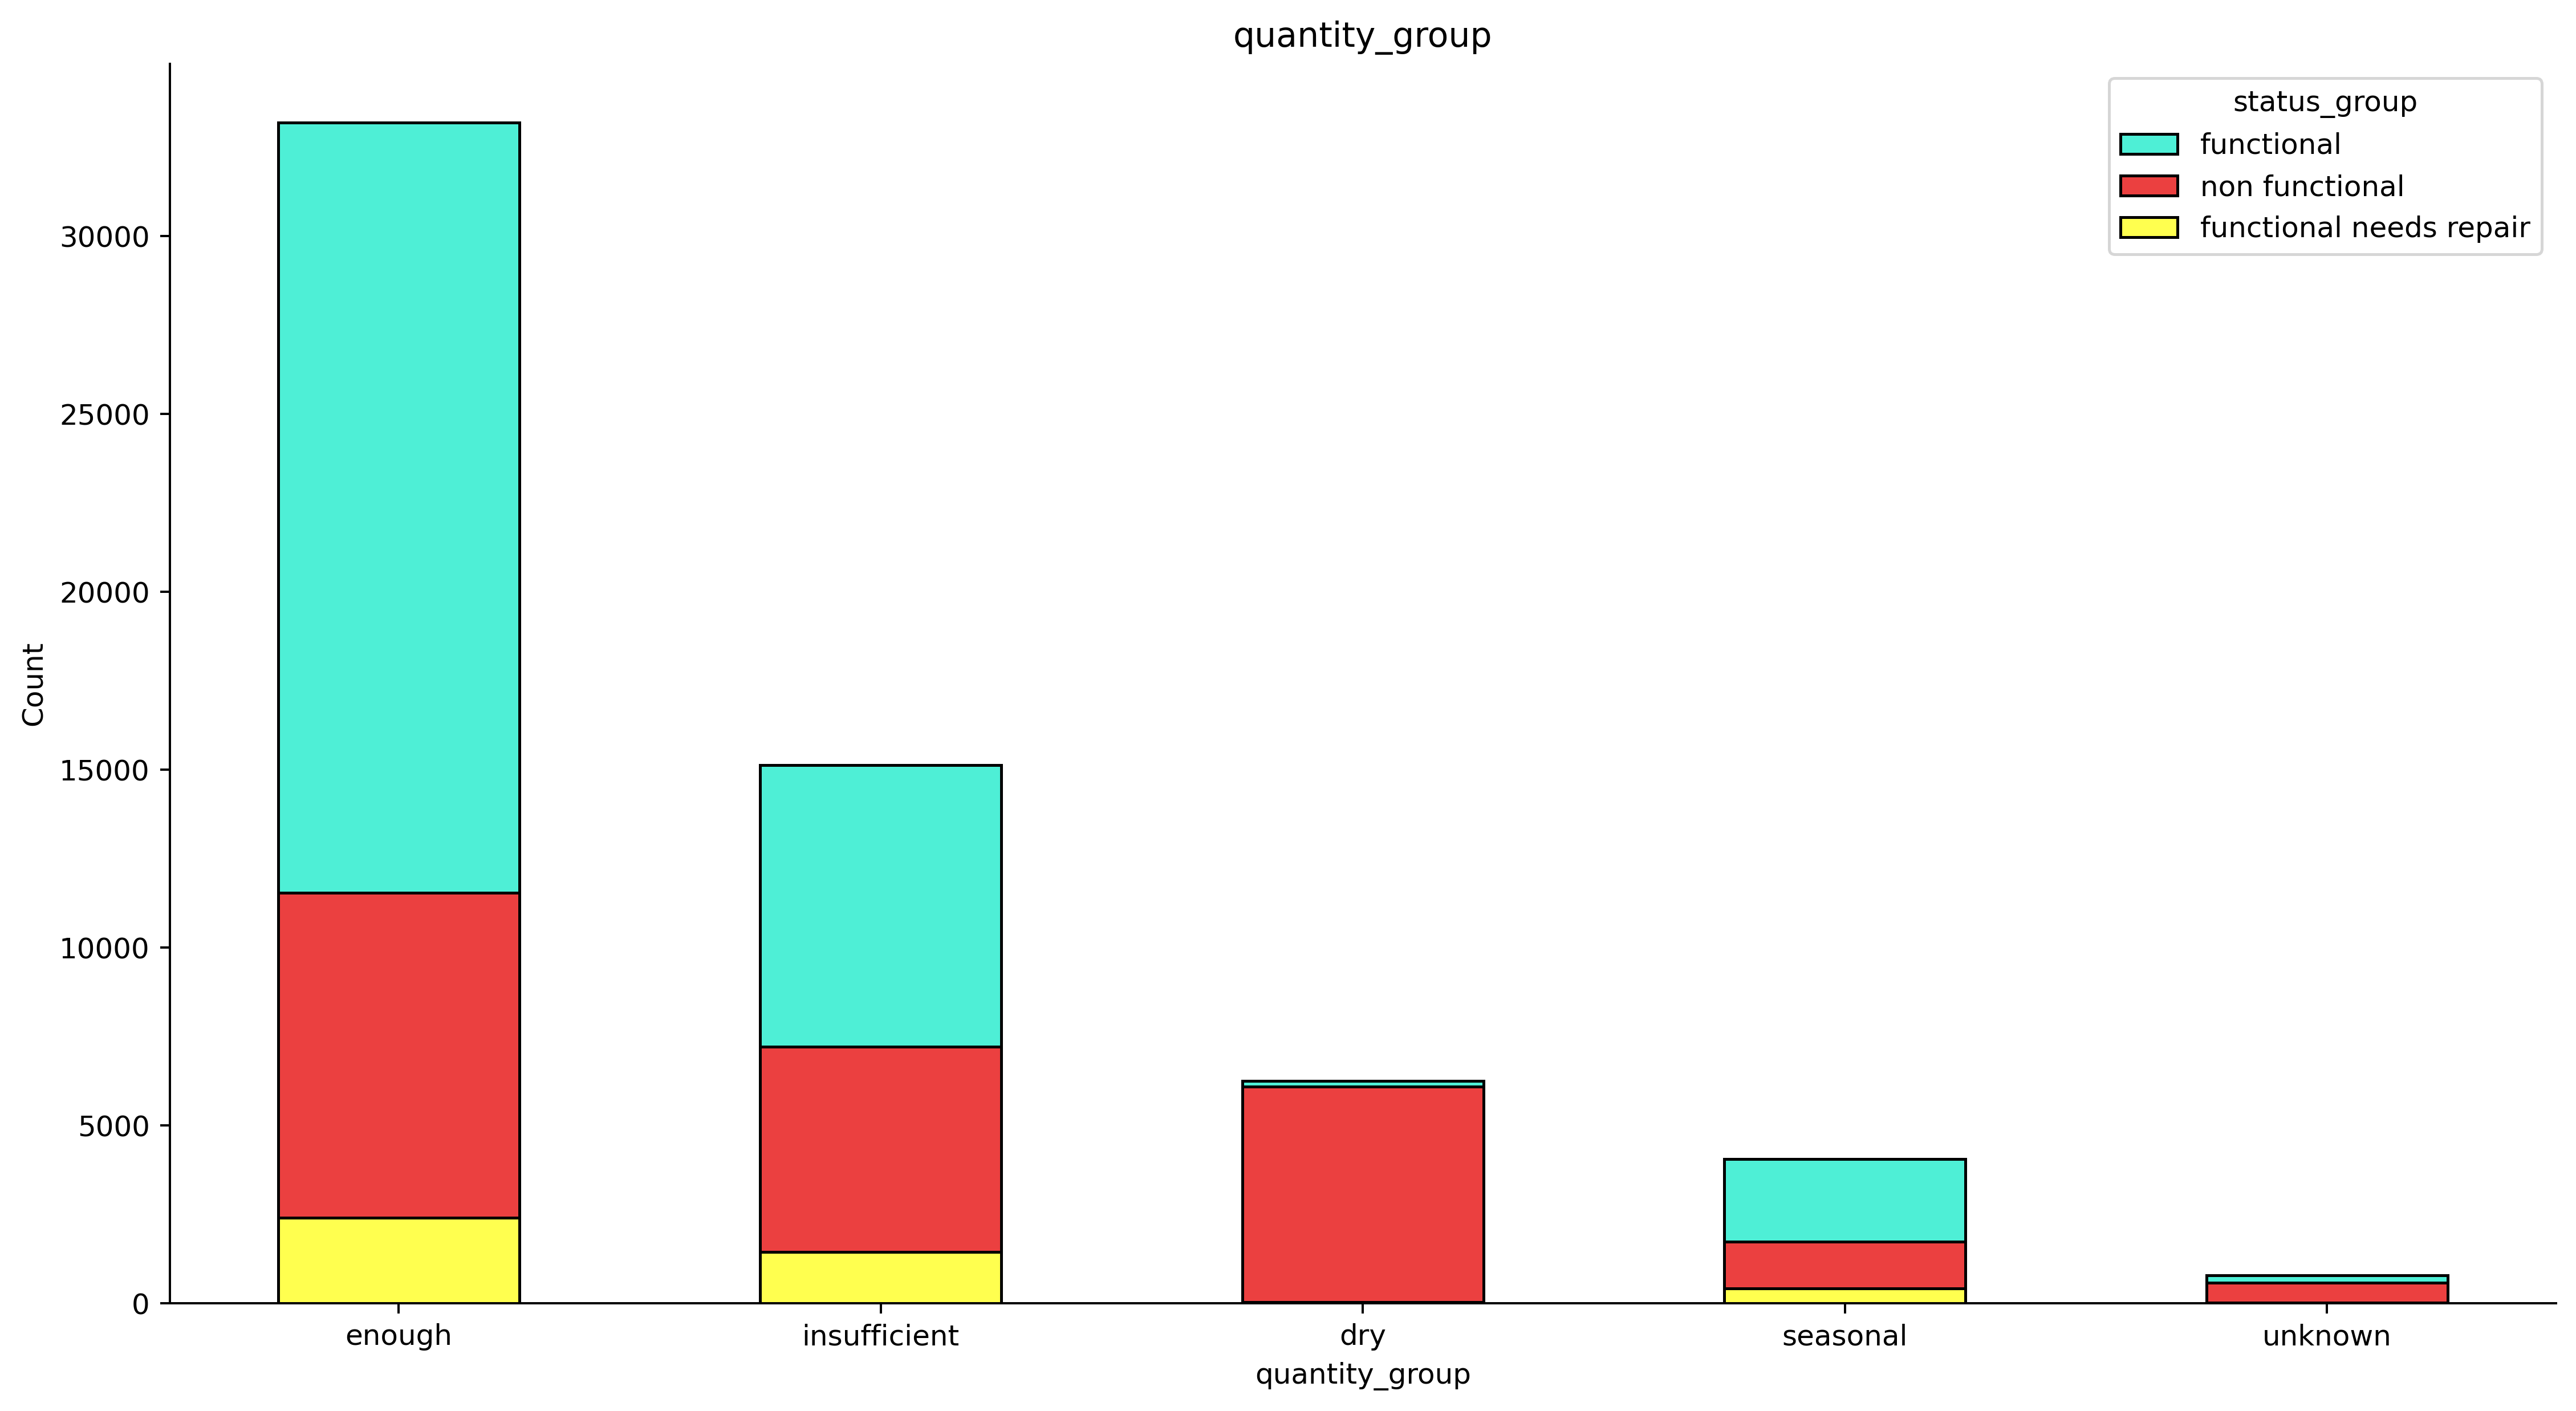

In [42]:
fig, ax = plt.subplots(figsize=(15,8))
sns.histplot(data=train, x='quantity_group', hue='status_group', shrink=0.5, multiple="stack", 
                 ax=ax, 
             palette=palette)
plt.rcParams['figure.dpi'] = 360
sns.despine()
plt.title('quantity_group')
plt.show()

Dry waterpoints has a significant amount of non-functional waterpoints, which makes total sense because they are more likely to be abandoned. 

#### Source

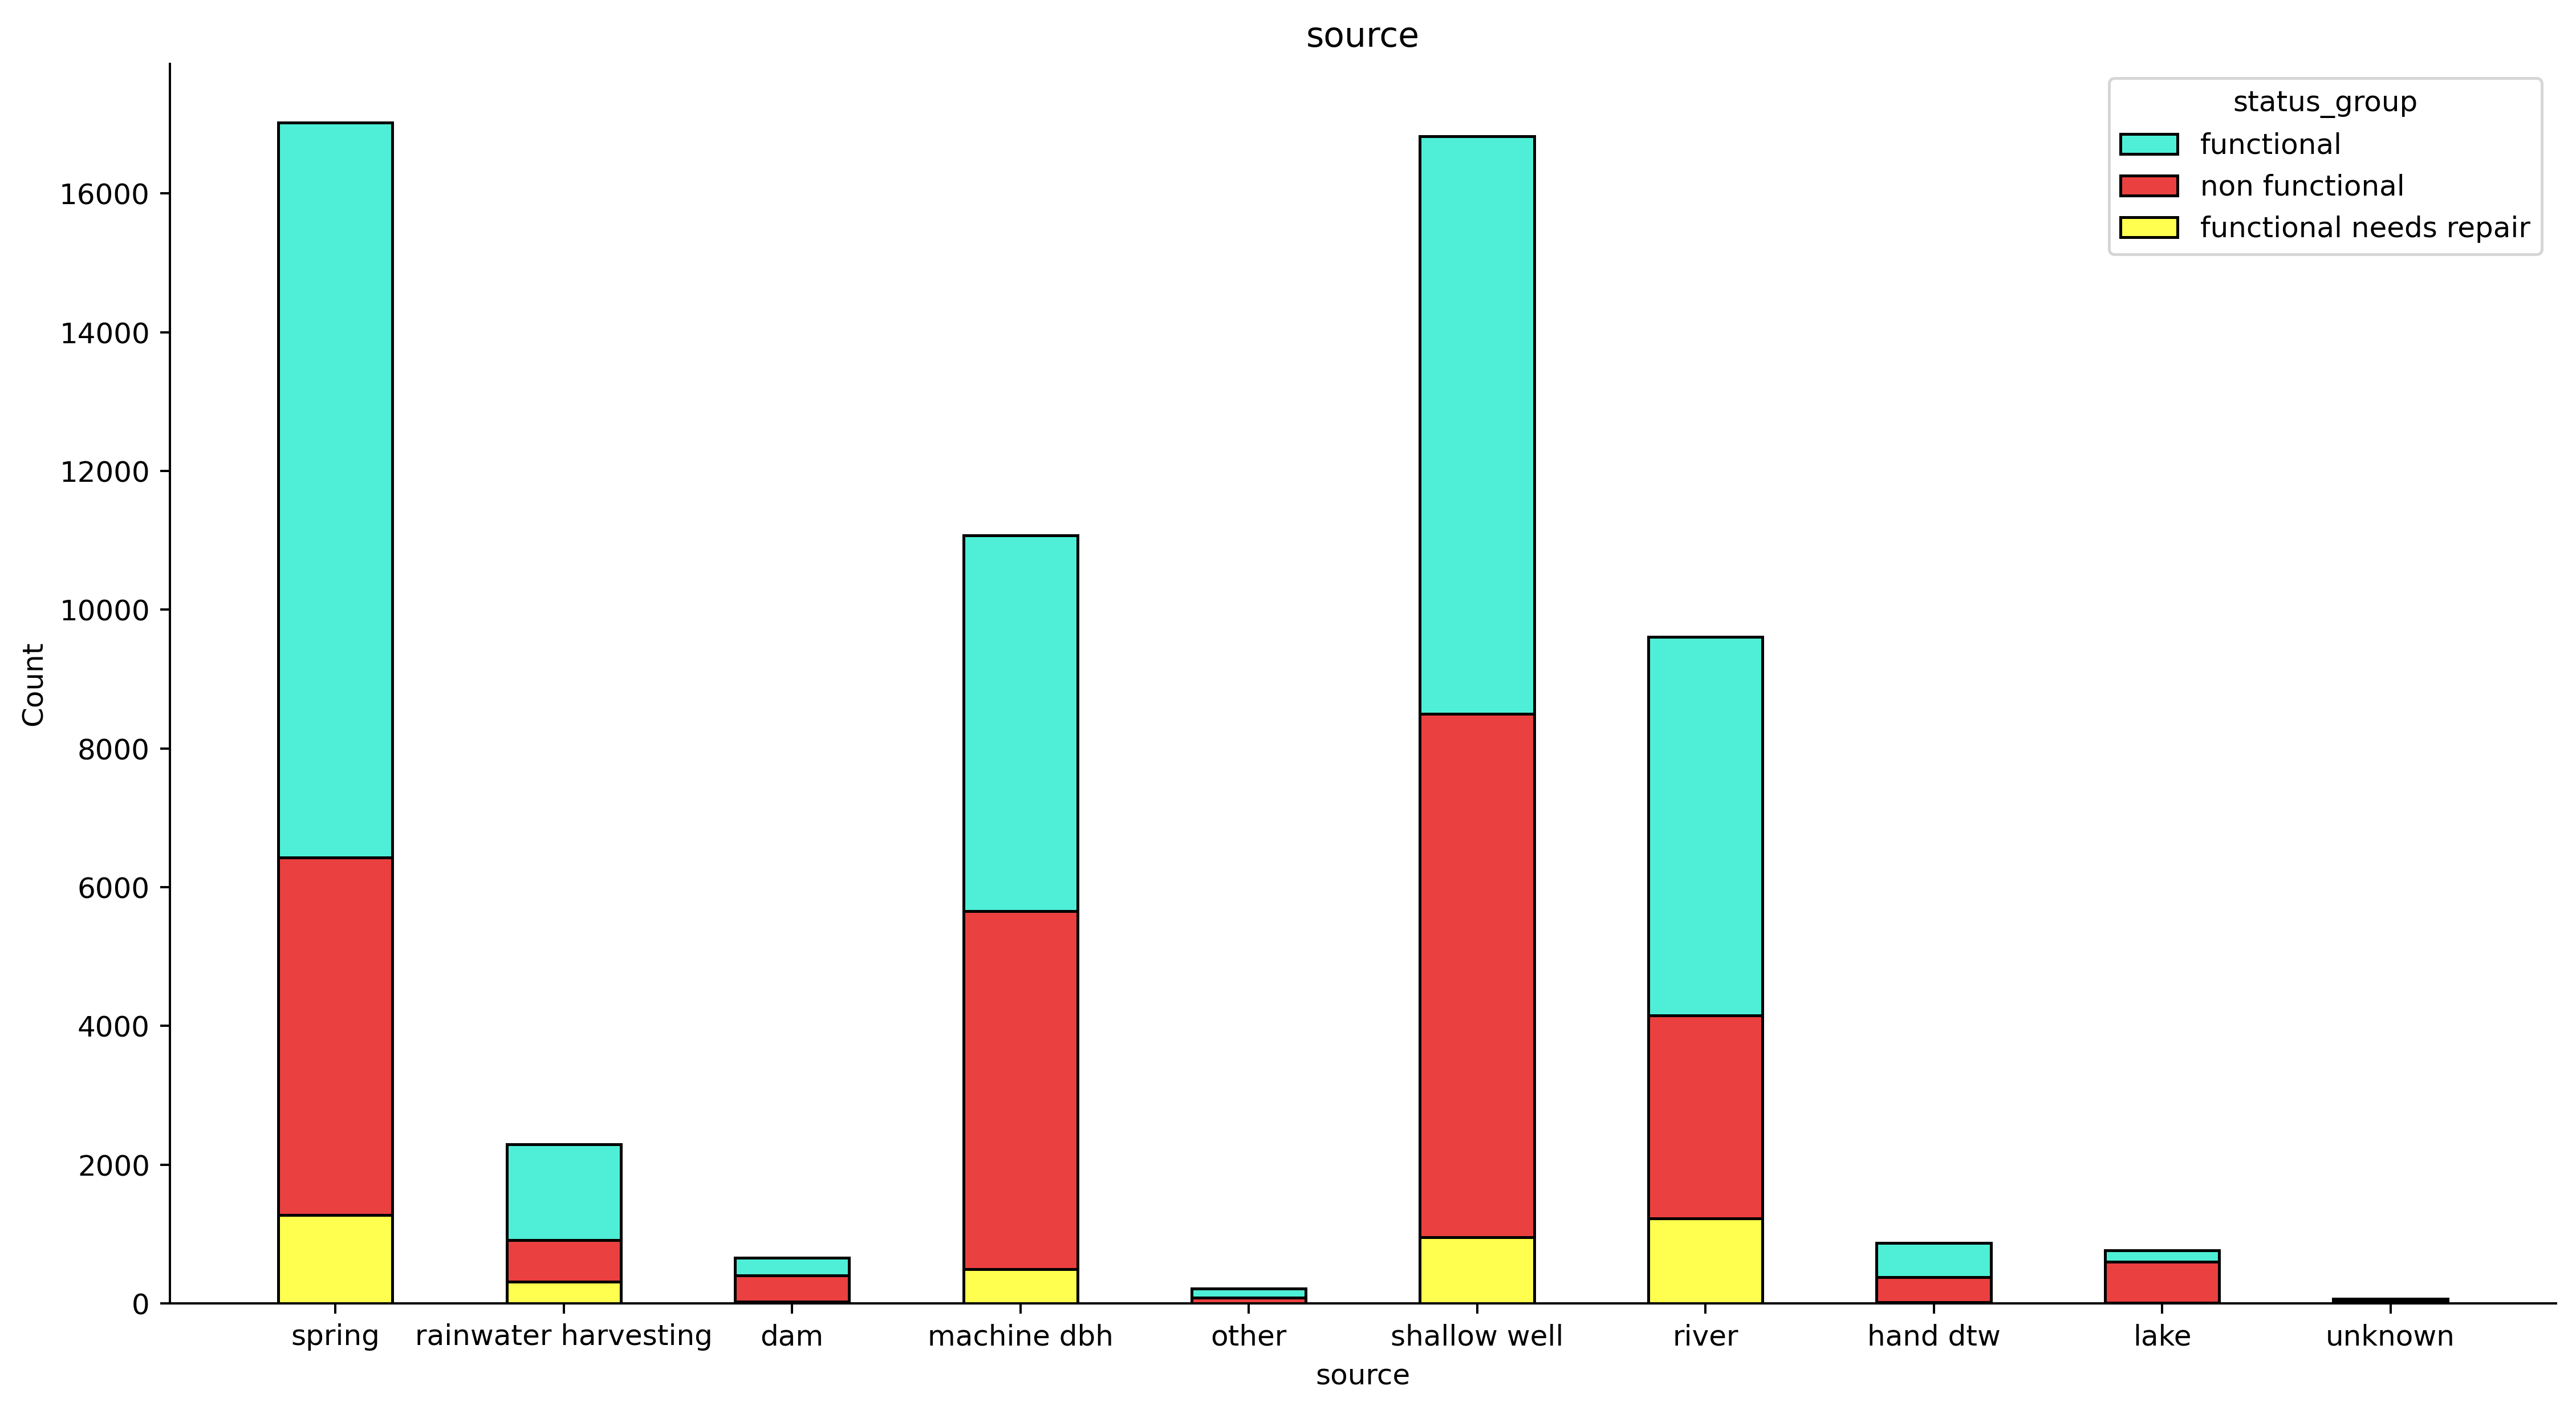

In [43]:
fig, ax = plt.subplots(figsize=(15,8))
sns.histplot(data=train, x='source', hue='status_group', shrink=0.5, multiple="stack", 
                 ax=ax, 
             palette=palette)
plt.rcParams['figure.dpi'] = 360
sns.despine()
plt.title('source')
plt.show()

#### Source class

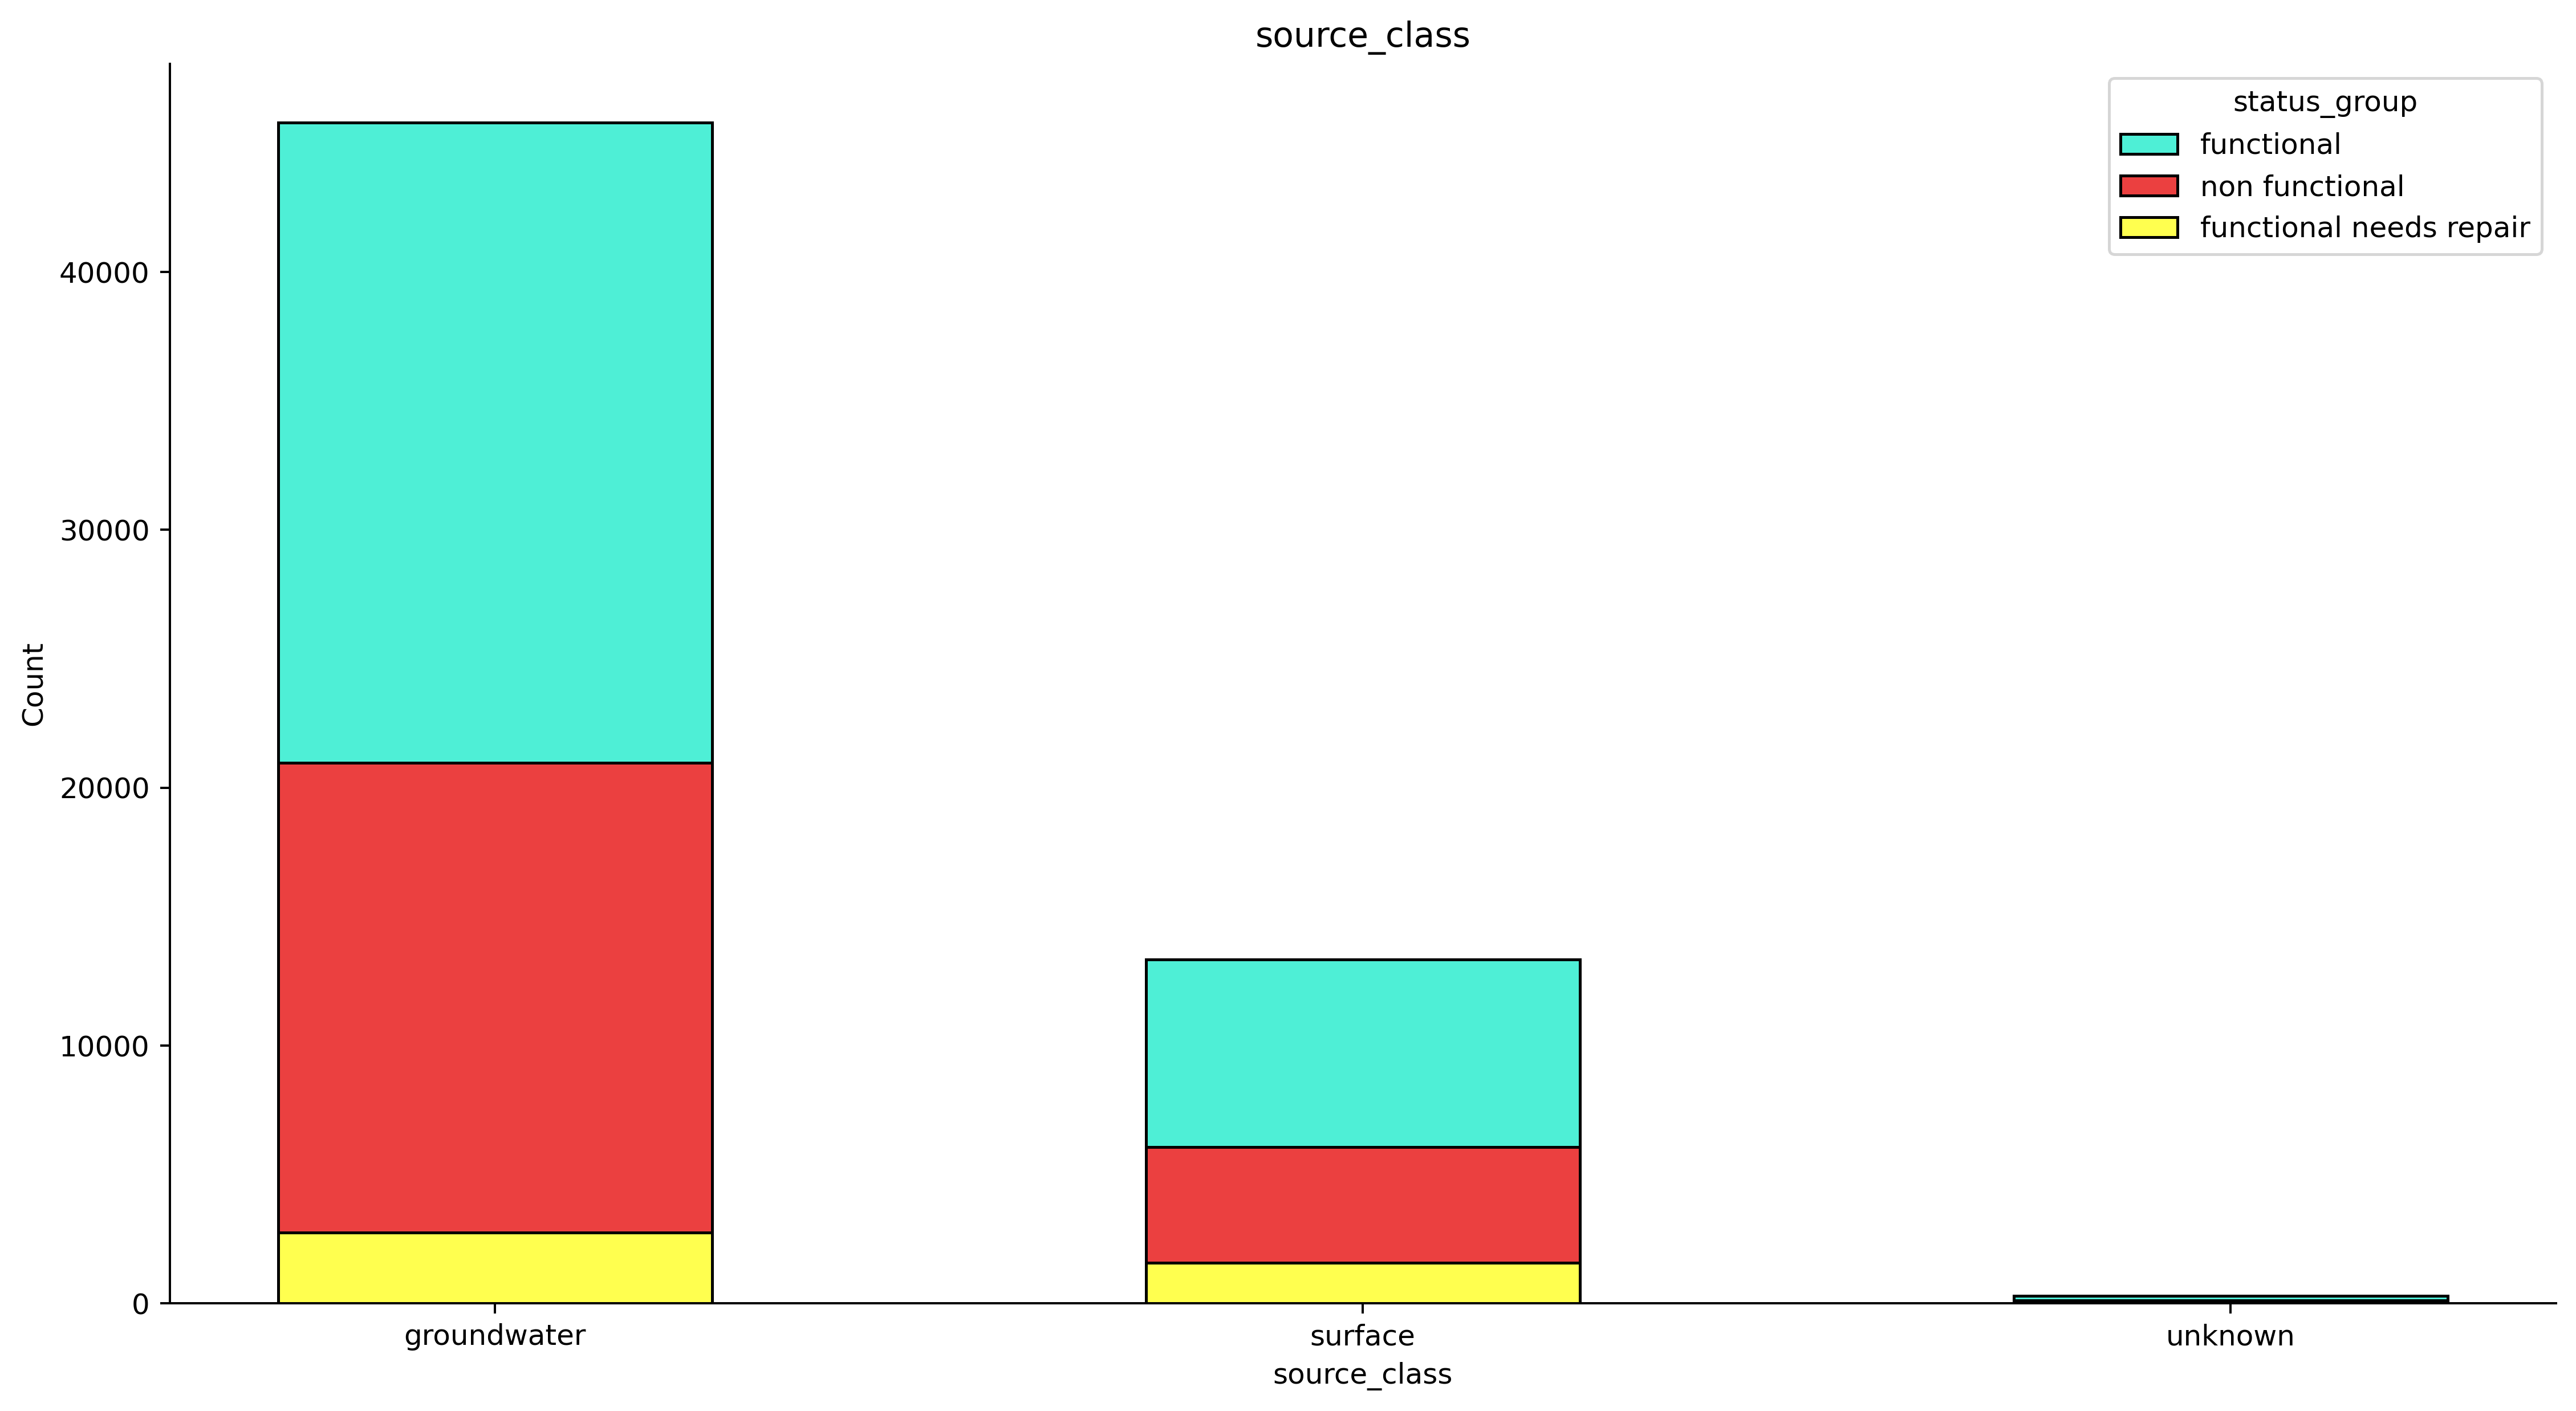

In [44]:
fig, ax = plt.subplots(figsize=(15,8))
sns.histplot(data=train, x='source_class', hue='status_group', shrink=0.5, multiple="stack", 
                 ax=ax, 
             palette=palette)
plt.rcParams['figure.dpi'] = 360
sns.despine()
plt.title('source_class')
plt.show()

#### Water_type_group

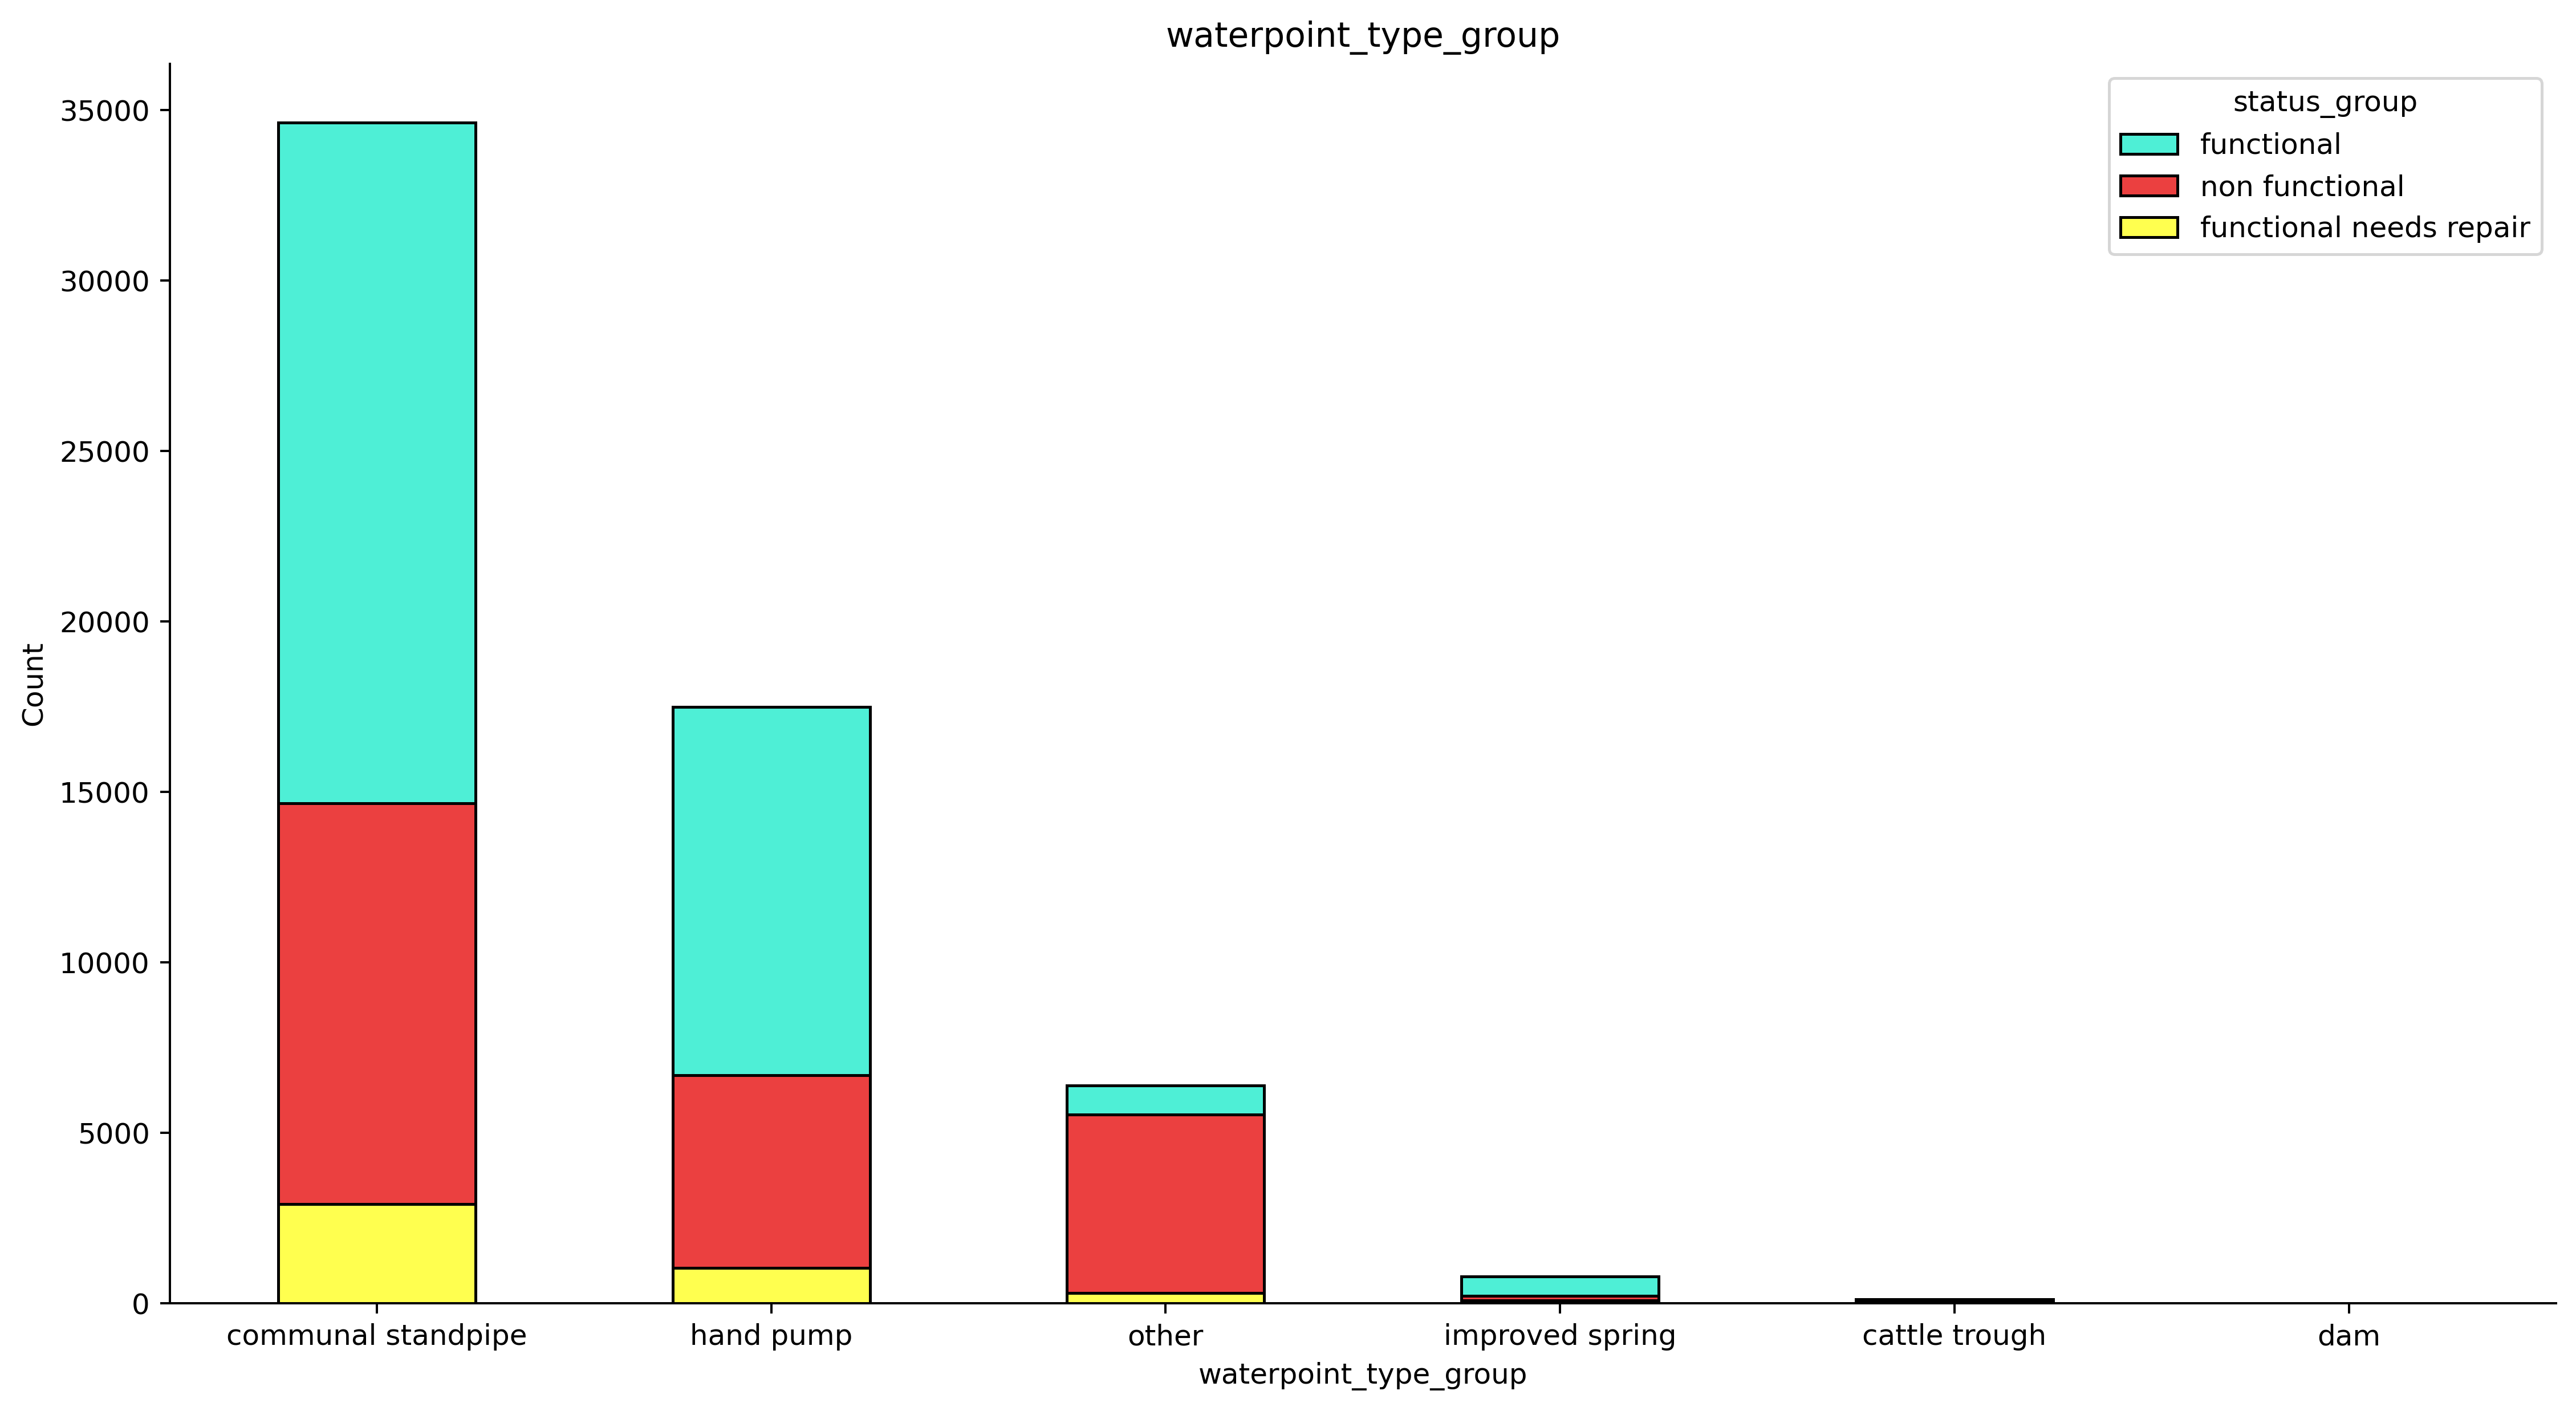

In [45]:
fig, ax = plt.subplots(figsize=(15,8))
sns.histplot(data=train, x='waterpoint_type_group', hue='status_group', shrink=0.5, multiple="stack", 
                 ax=ax, 
             palette=palette)
plt.rcParams['figure.dpi'] = 360
sns.despine()
plt.title('waterpoint_type_group')
plt.show()

Other type has a significant amount of non-functional waterpoints

#### Permit

In [46]:
df = train.copy()

In [47]:
df.permit = df.permit.fillna('unknown')
df.permit = df.permit.astype('str')
df.permit.replace('True', 'Yes', inplace=True)
df.permit.replace('False', 'No', inplace=True)

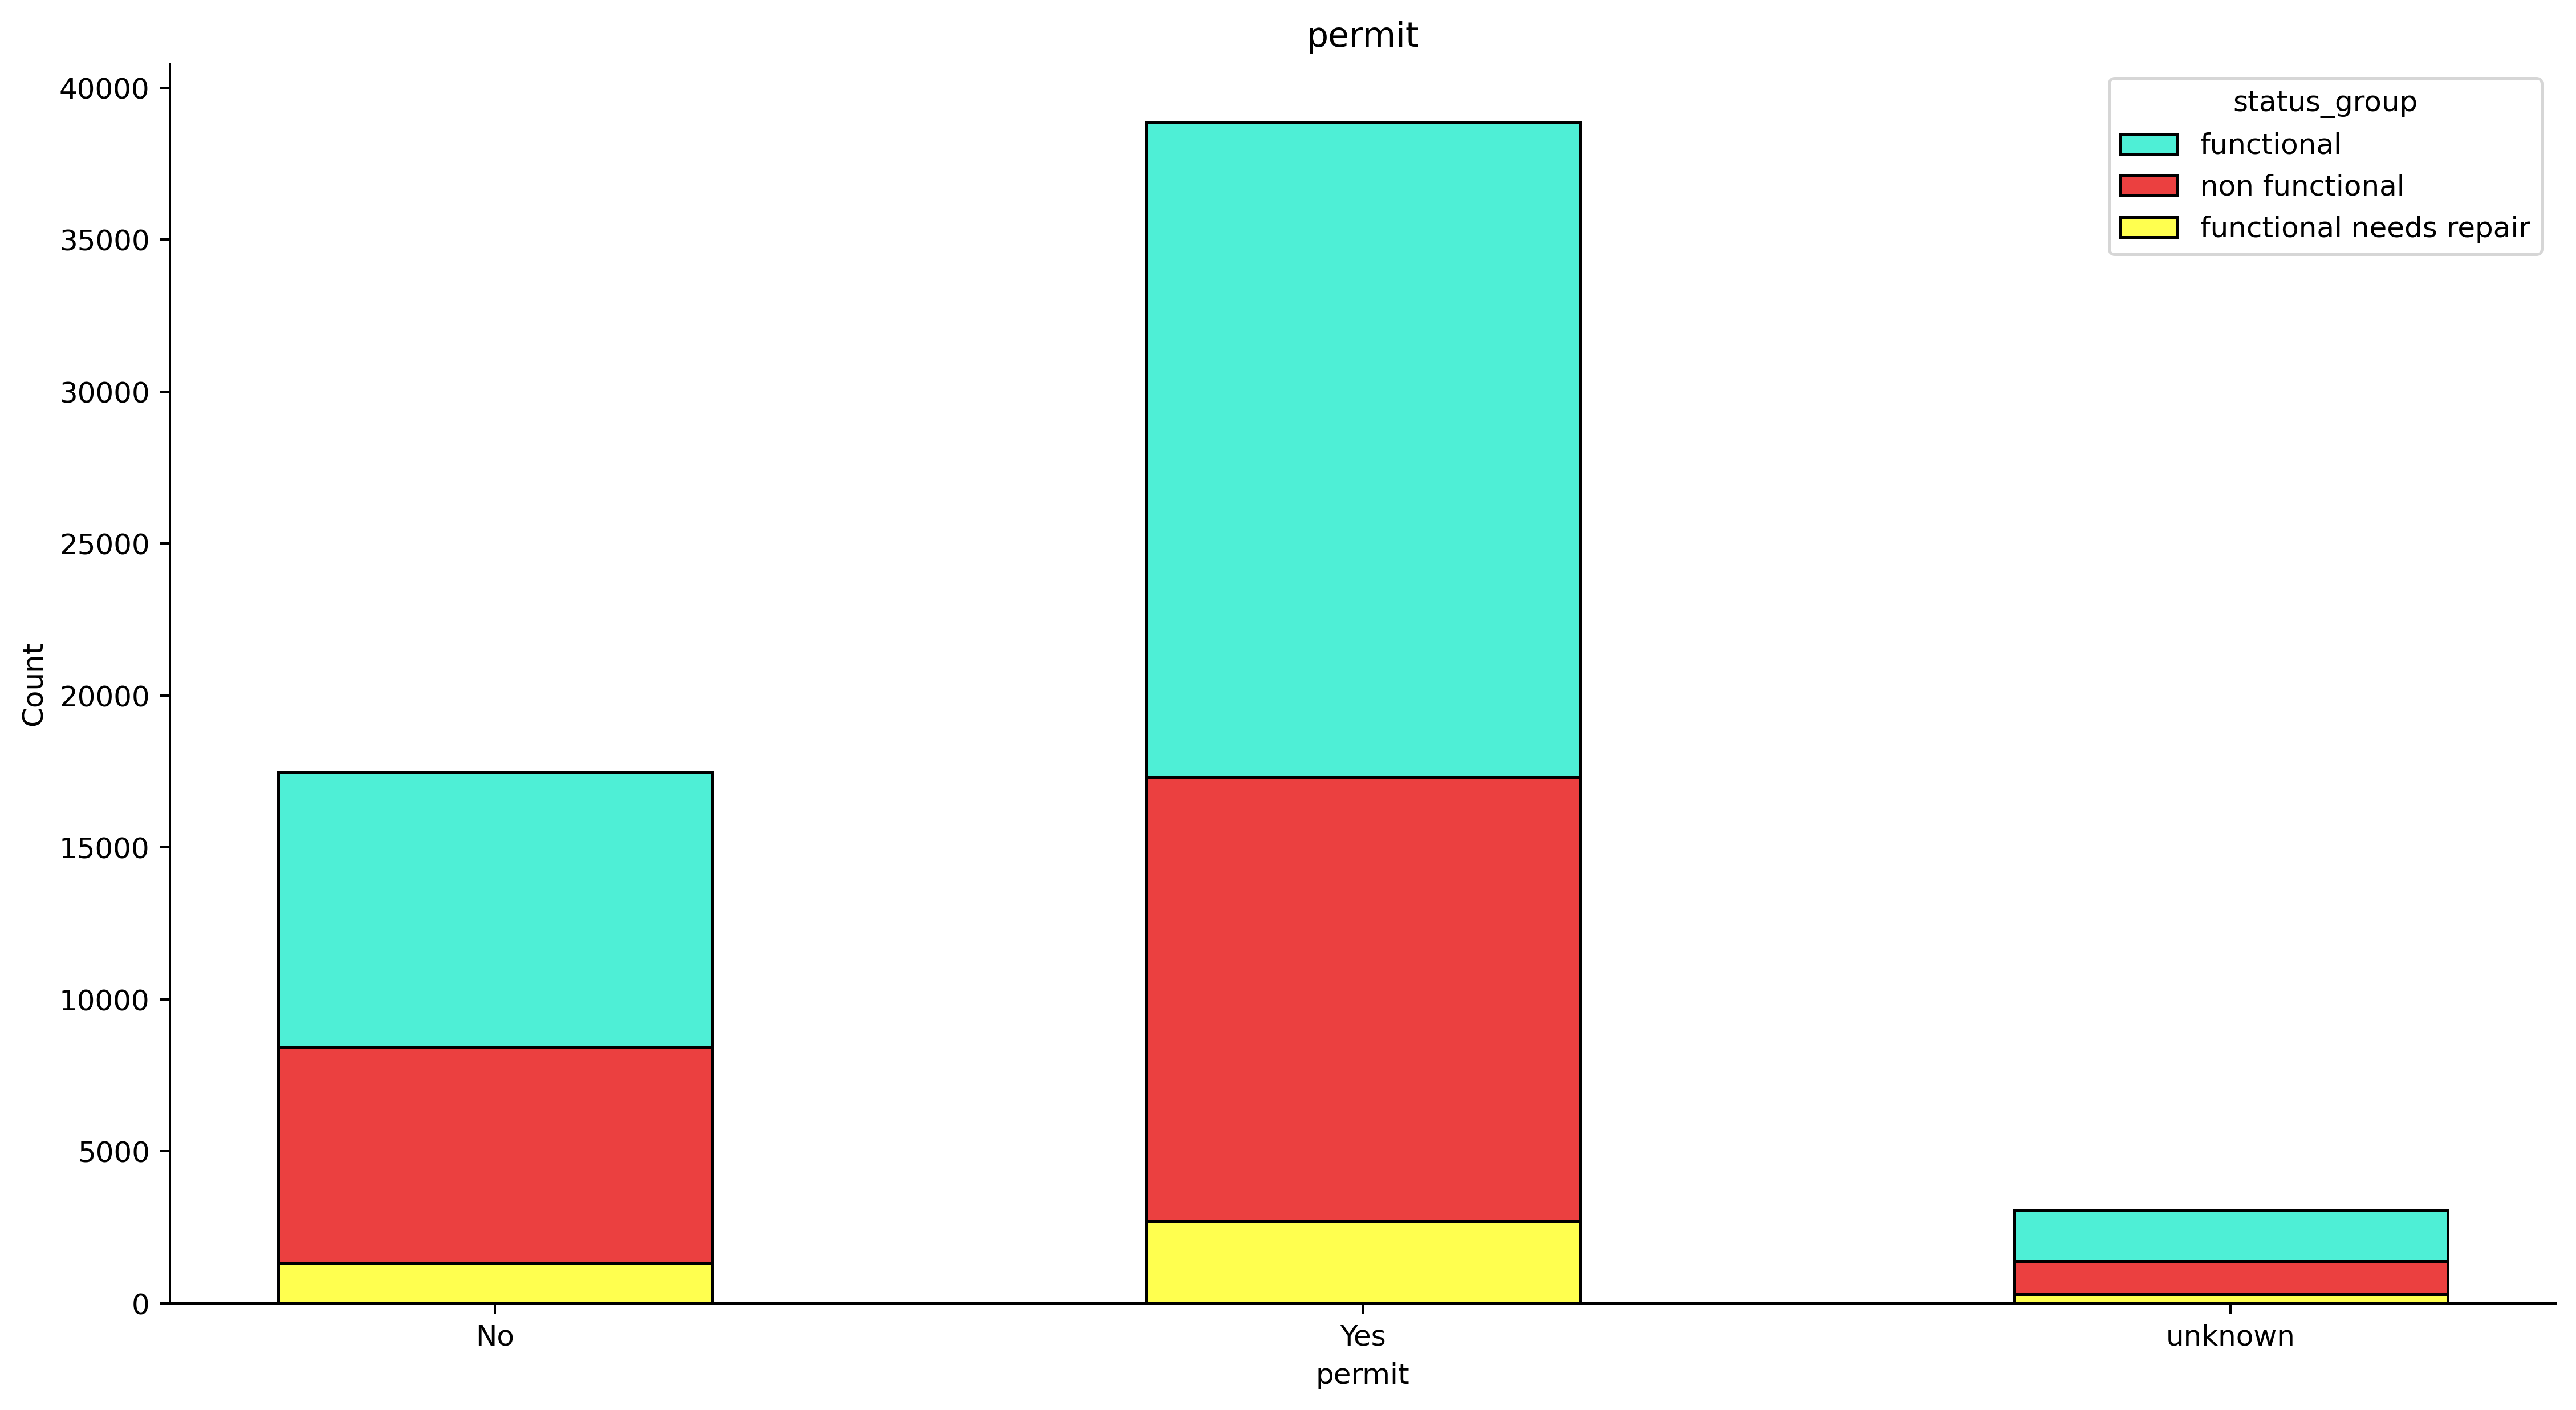

In [48]:
fig, ax = plt.subplots(figsize=(15,8))
sns.histplot(data=df, x='permit', hue='status_group', shrink=0.5, multiple="stack", 
                 ax=ax, 
             palette=palette)
plt.rcParams['figure.dpi'] = 360
sns.despine()
plt.title('permit')
plt.show()

#### Public meeting

In [49]:
train.public_meeting = train.public_meeting.fillna('unknown')
train.public_meeting = train.public_meeting.astype('str')
train.public_meeting.replace('True', 'Yes', inplace=True)
train.public_meeting.replace('False', 'No', inplace=True)

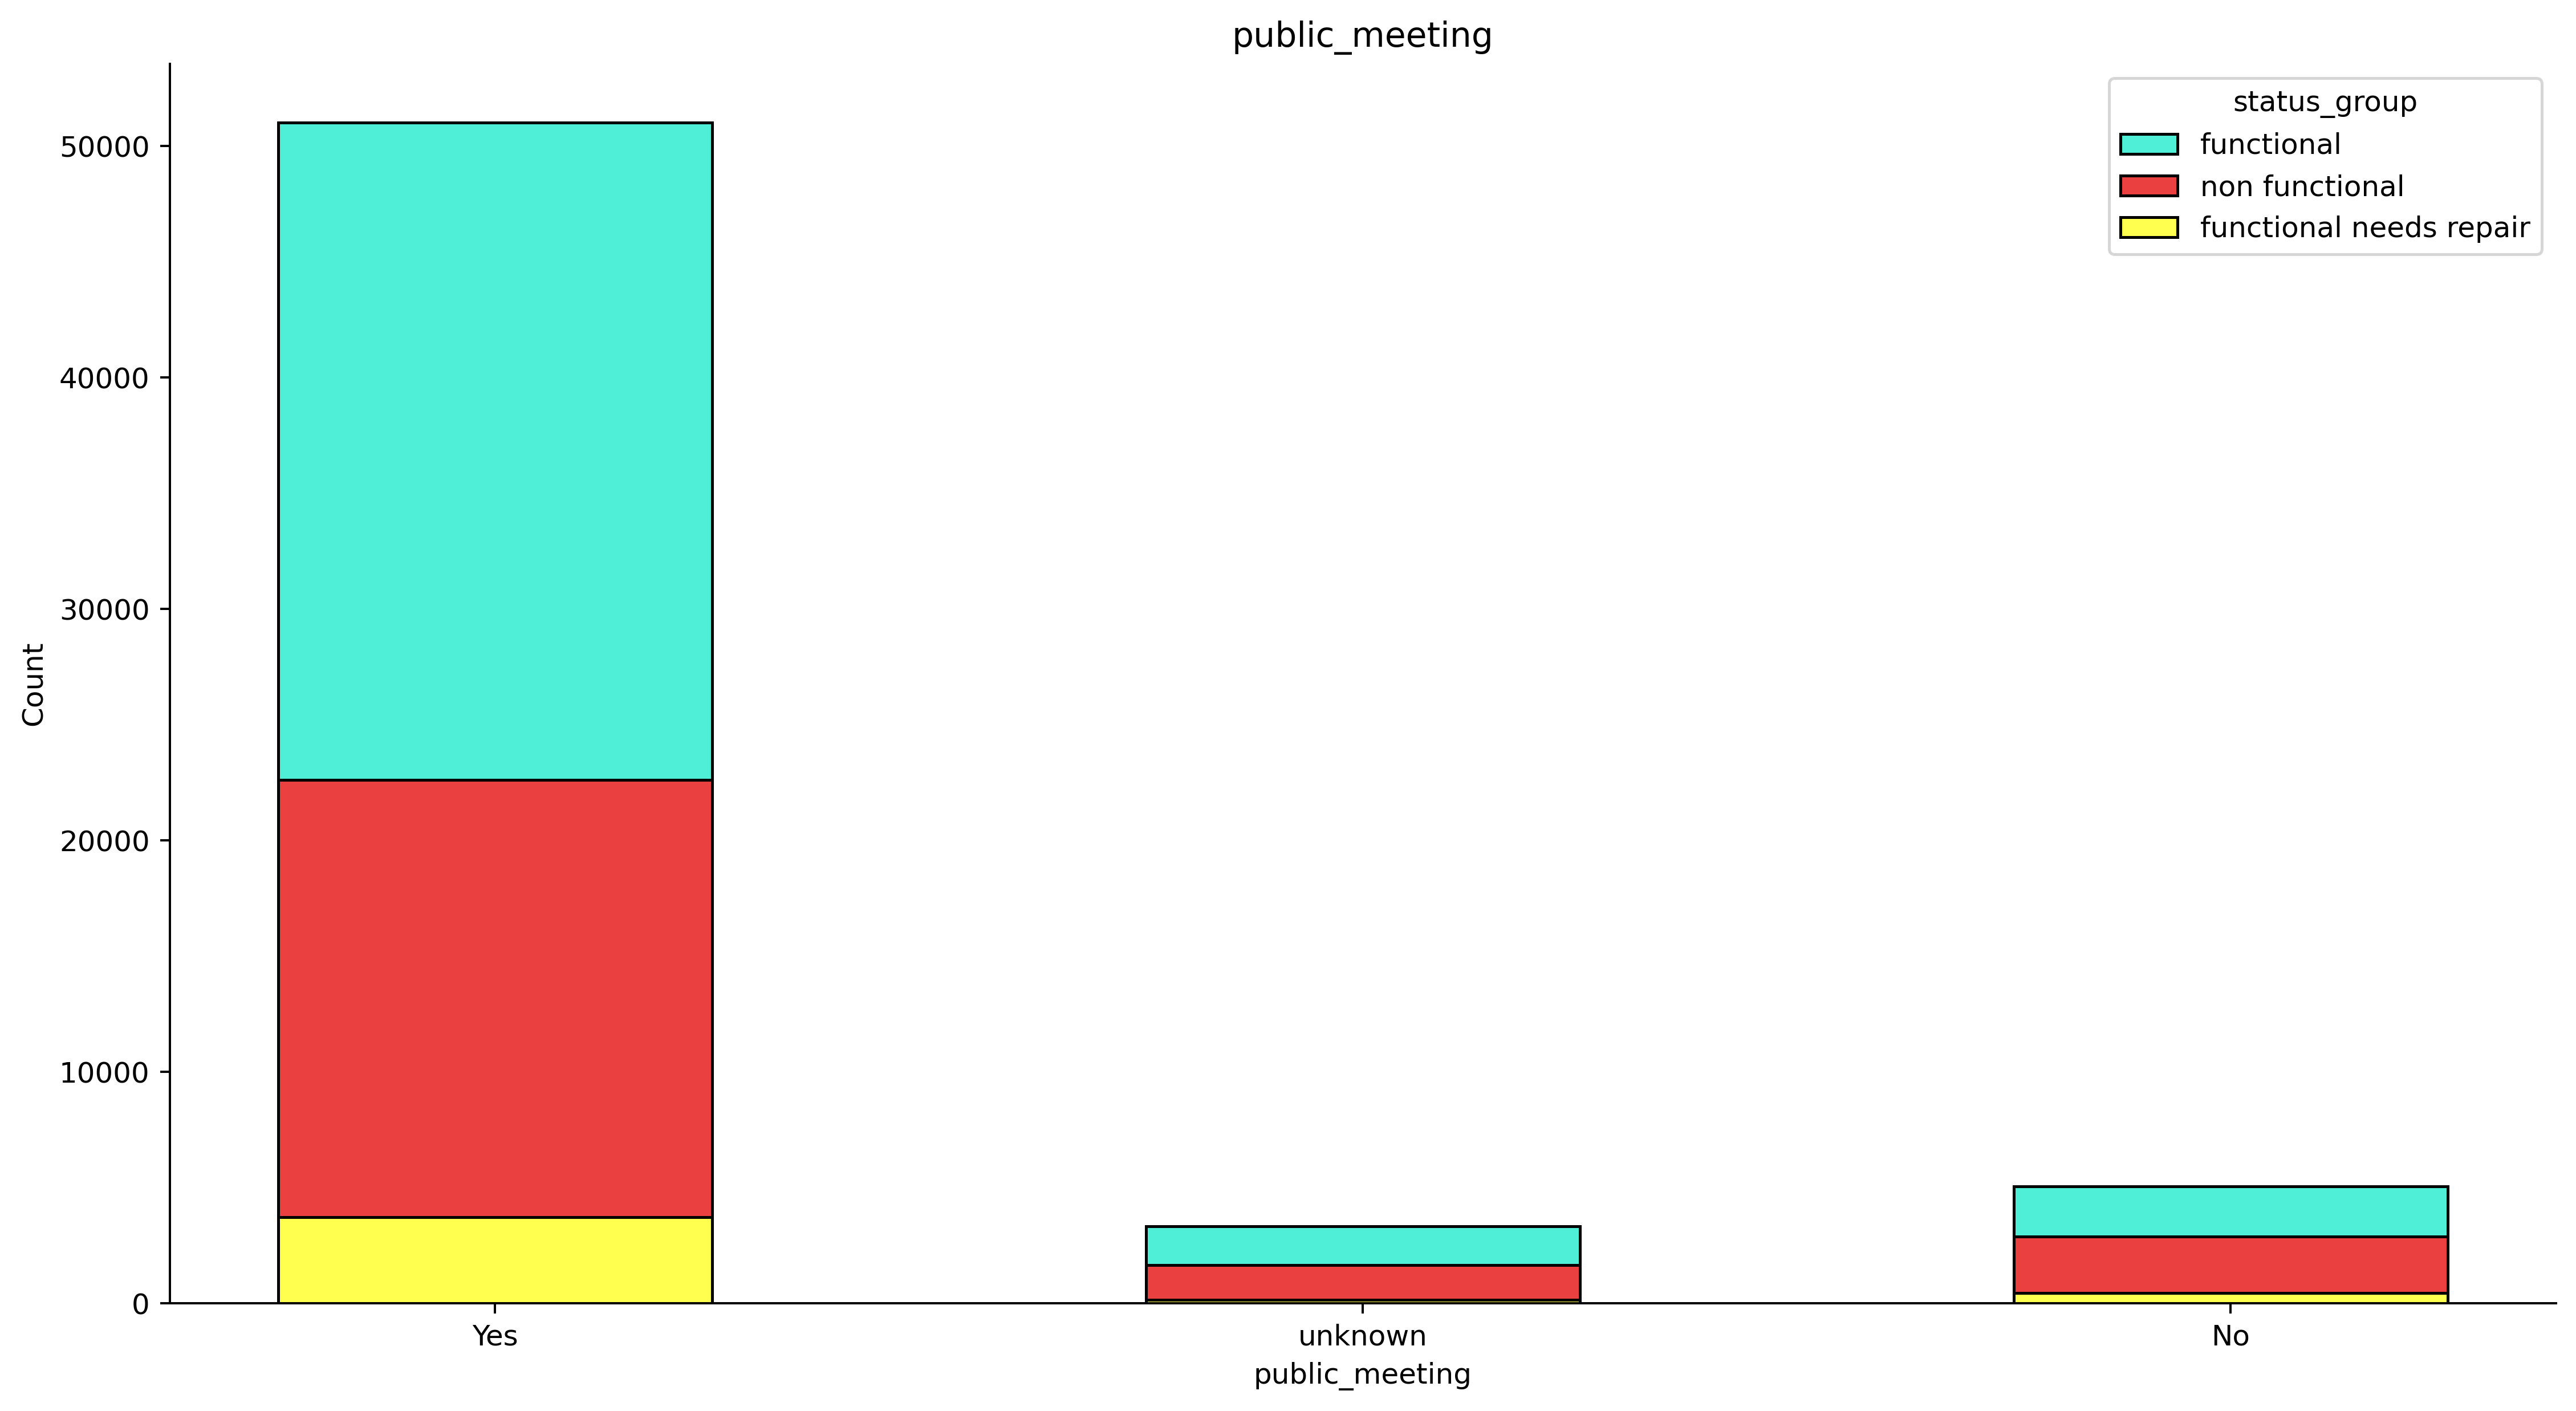

In [50]:
fig, ax = plt.subplots(figsize=(15,8))
sns.histplot(data=train, x='public_meeting', hue='status_group', shrink=0.5, multiple="stack", 
                 ax=ax, 
             palette=palette)
plt.rcParams['figure.dpi'] = 360
sns.despine()
plt.title('public_meeting')
plt.show()

### Waterpoint status according to construction year

In [51]:
df = train.copy()

In [52]:
df = df.sort_values(by='construction_year', ascending=False)
df = df[df.construction_year != 0]
df.construction_year = df.construction_year.astype('str')


In [53]:
construction_year_order = list(df.construction_year.value_counts().sort_index(ascending=True).index)

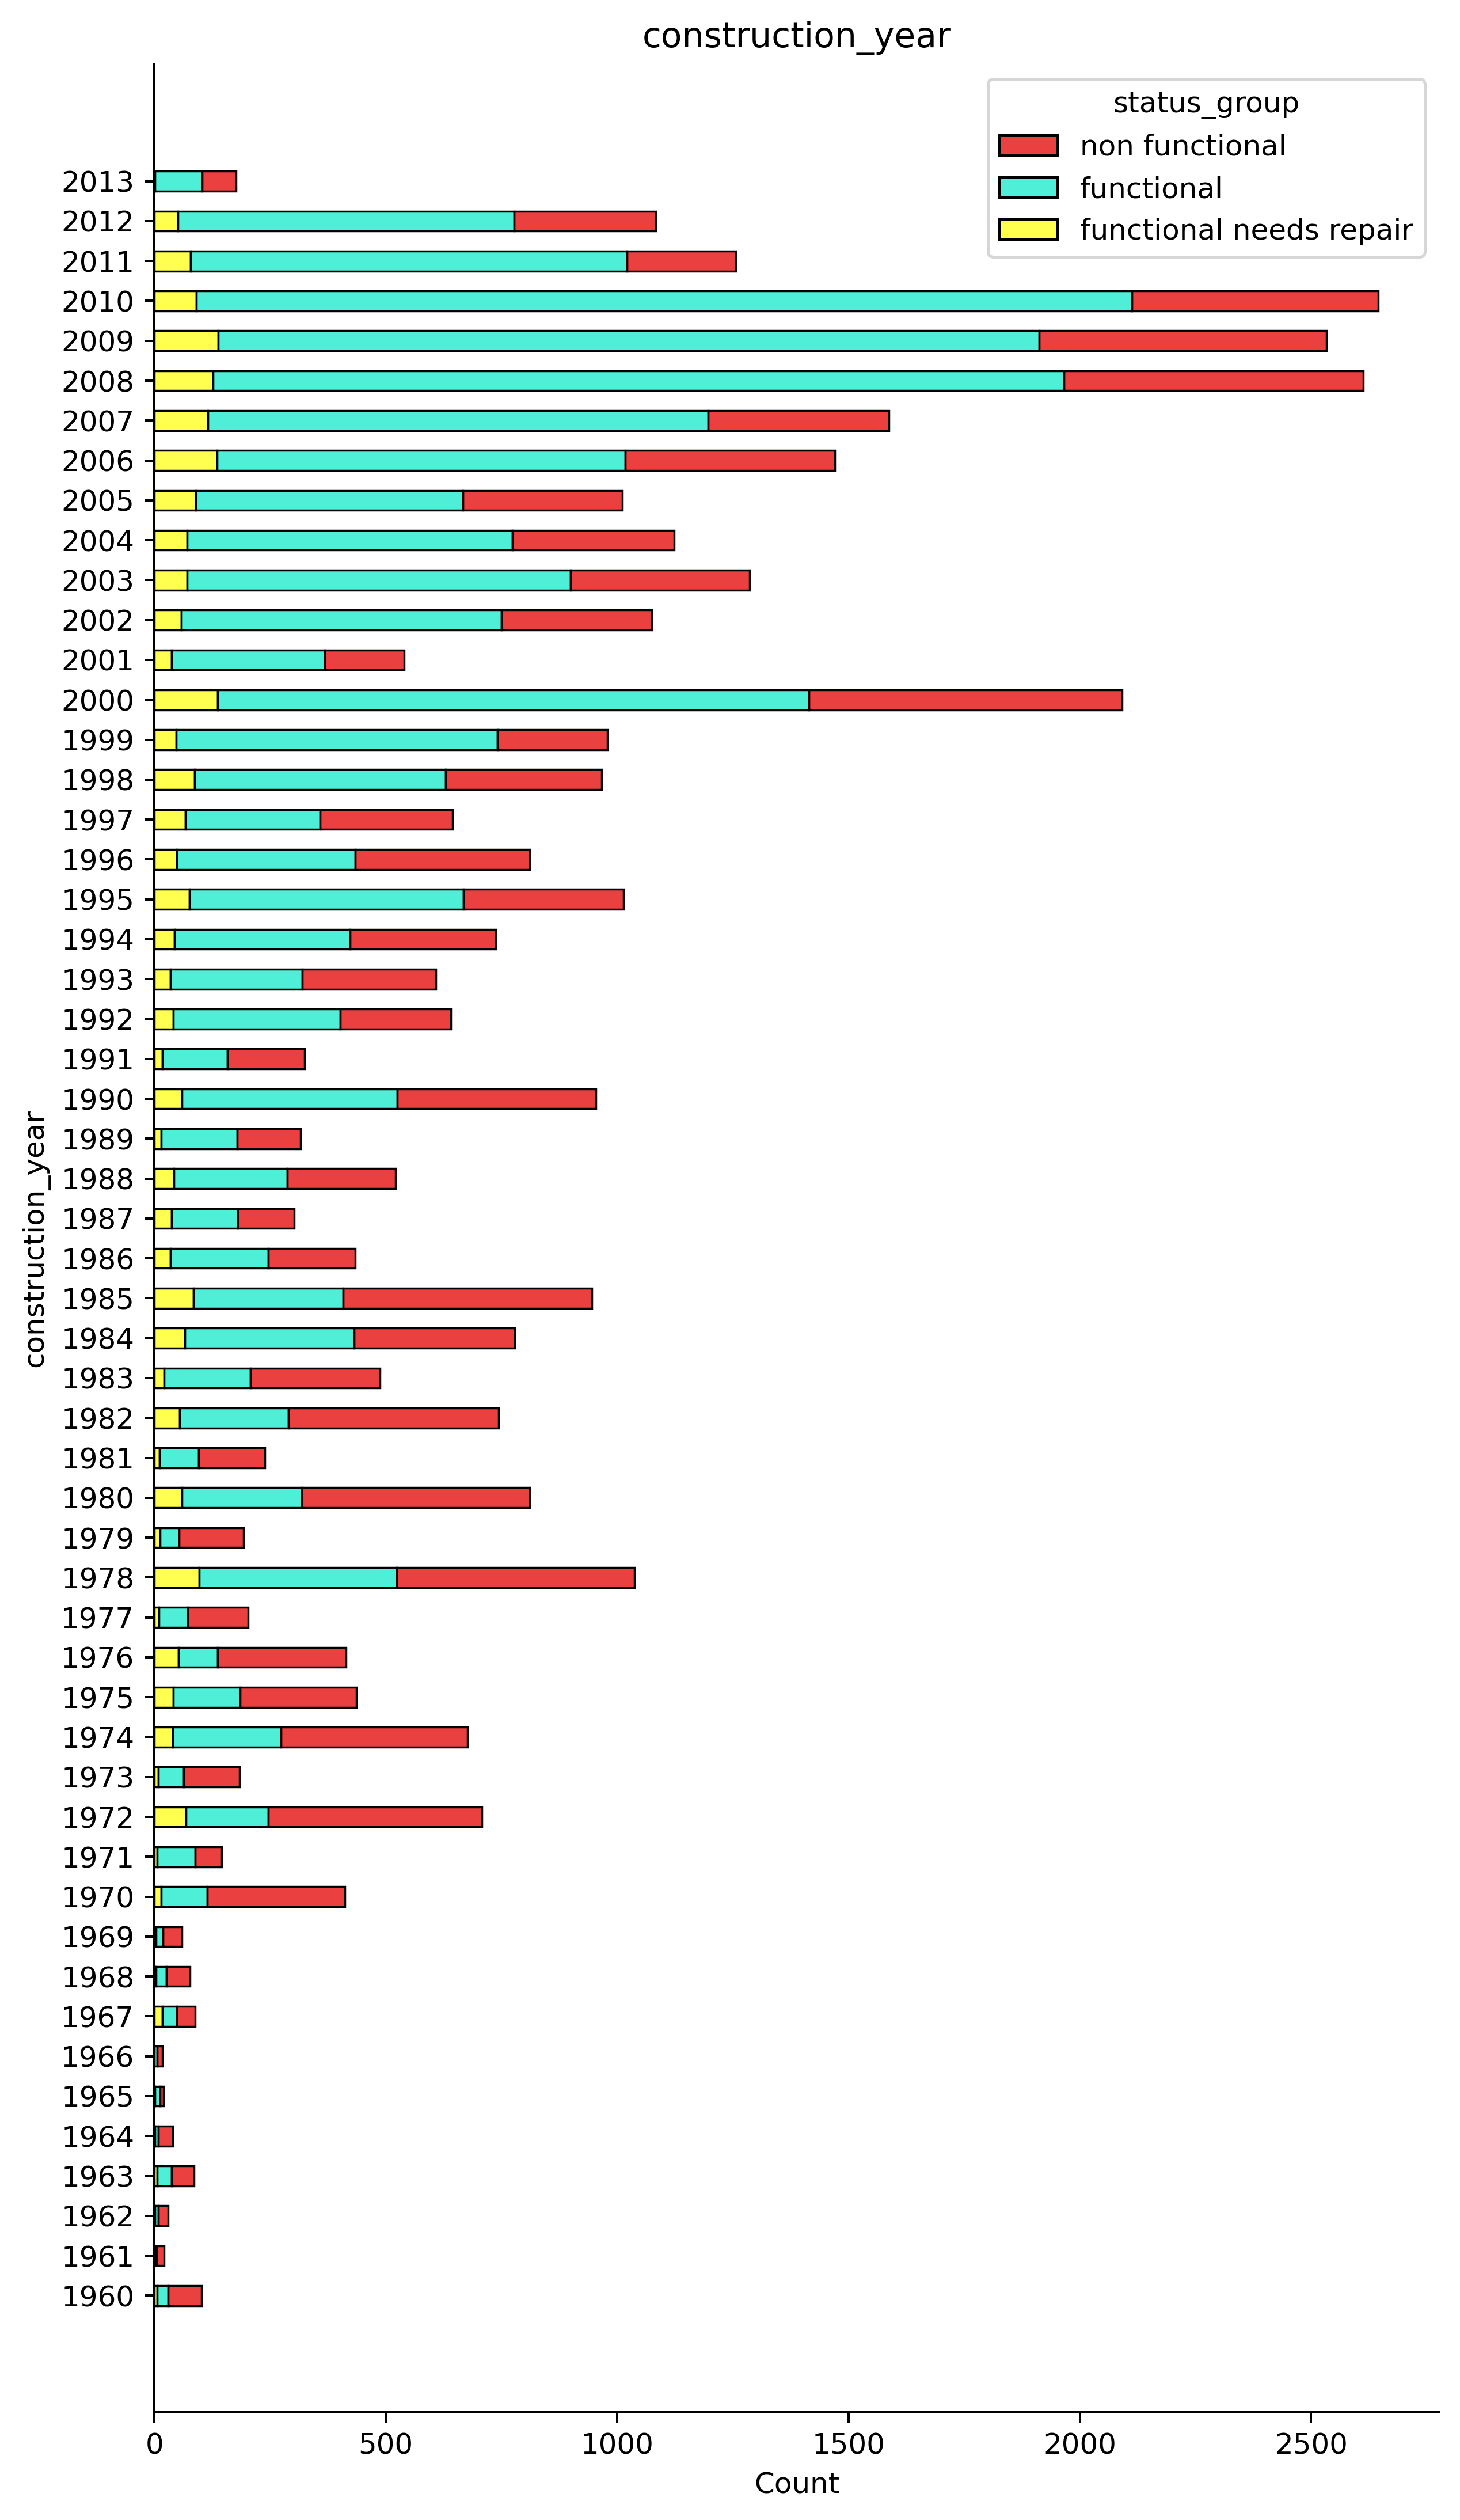

In [54]:
fig, ax = plt.subplots(figsize=(8,15))
sns.histplot(data=df, y='construction_year', hue='status_group', shrink=0.5, multiple="stack", 
                 ax=ax, 
             palette=palette)
plt.rcParams['figure.dpi'] = 360
sns.despine()
plt.title('construction_year')
plt.show()

Older waterpoints are more likely to be broken 

# Data cleaning

We gathered some information about our dataset and its features. Now, let's remove unnecessary features

In [55]:
for i in list(train.dtypes[train.dtypes == 'object'].index):
    print('====================================')
    print(i)
    print('====================================')
    print(train[i].value_counts())

date_recorded
2011-03-15    572
2011-03-17    558
2013-02-03    546
2011-03-14    520
2011-03-16    513
             ... 
2002-10-14      1
2013-01-06      1
2011-09-17      1
2011-09-20      1
2011-09-11      1
Name: date_recorded, Length: 356, dtype: int64
funder
Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
Mrtc                         1
Eco Lodge                    1
Mzee Lesilali                1
Ruangwa Lga                  1
Padri K                      1
Name: funder, Length: 1897, dtype: int64
installer
DWE                             17402
Government                       1825
RWE                              1206
Commu                            1060
DANIDA                           1050
                                ...  
Tanz/Egypt technical coopera        1
VICF                                1
Paskali                             1


## Removal of useless features

In [56]:
columns_to_exclude = ['date_recorded', 'waterpoint_type', 'source_class', 'source', 'quantity', 'water_quality', 
                      'payment', 'management', 'extraction_type', 'extraction_type_group', 'scheme_management',
                      'wpt_name', 'recorded_by', 'lga', 'subvillage', 'public_meeting', 'installer', 'num_private']

-**date_recorded** - we are interested in the year of building, but not in the date of recording


---


-**waterpoint_type** contains the same information as waterpoint_type_group but less structured


---


-**source** contains the same information as source_type but less structured


---


-**source_class** has three categories: groundwater, surface and unknown, all of which can be obtained from source_type categories

---


-**quantity** is the same as quantity_group


---



-**water quality** is the same as quality_group and contains some strange categories like salty abandoned and fluoride abandoned

---



-**payment** and payment_type are the same


---



-**management** and management_group are the same; management contains too many categories which seem not to add any value


---



-**extraction_type, extraction_type_group** and extraction_type_class are the same; extraction_type and extraction_type_group contain too many senseless categories




---


-**wpt_name** contains names of waterpoints; pretty much pointless 


---


-**public_meeting**  it is not clear from description what this feature means

---


-**recorded_by** contains information about the group that added the row; all rows were added by 1 group - GeoData Consultants Ltd. 


---


-**installer** too many categories; also, it contains 0 which is missing data


---


-**ward, lga, region, subvillage**

ward - an administrative division of a city or borough that typically elects and is represented by a councillor or councillors.

lga - Local Government Areas.

Let's just keep region for now


---


-**num_private** it is not stated in feature description what num_private is, so, we removed it

---


In [57]:
train_2 = train.drop(columns_to_exclude, axis=1)

## Filling NA in permit

In [58]:
train_2.permit = train_2.permit.fillna('unknown')
train_2.permit = train_2.permit.astype('str')
train_2.permit.replace('True', 'Yes', inplace=True)
train_2.permit.replace('False', 'No', inplace=True)

## Filling NA in scheme_name

In [59]:
df_scheme = dict(train_2.groupby(['region'])['scheme_name'].agg(pd.Series.mode))
df_scheme

{'Arusha': 'Machumba estate pipe line',
 'Dar es Salaam': 'J',
 'Dodoma': 'Ntom',
 'Iringa': "wanging'ombe water supply s",
 'Kagera': 'Kaisho/Isingiro w',
 'Kigoma': 'Mkongoro Two',
 'Kilimanjaro': "Uroki-Bomang'ombe water sup",
 'Lindi': 'GEN Borehole Scheme',
 'Manyara': 'Kijiji',
 'Mara': 'Mradi wa maji Komuge',
 'Mbeya': 'K',
 'Morogoro': 'Ki',
 'Mtwara': 'Borehole',
 'Mwanza': 'None',
 'Pwani': 'Chalinze wate',
 'Rukwa': 'K',
 'Ruvuma': 'DANIDA',
 'Shinyanga': 'None',
 'Singida': 'M',
 'Tabora': 'World Bank',
 'Tanga': 'Handeni Trunk Main(H'}

In [60]:
train_2.scheme_name = train_2.scheme_name.fillna(train_2.region.map(df_scheme))
train_2.scheme_name = train_2.scheme_name.replace('None', 'unknown')

## Filling NA in constraction_year

In [61]:
construction_year = pd.DataFrame(index=train_2.index, data=train_2.construction_year)
construction_year = construction_year.replace(0, np.nan)
construction_year = construction_year.interpolate()

In [62]:
train_2['construction_year'] = [round(x) for x in construction_year.construction_year.values]

## Adding Age and removing construction_year

In [63]:
train_2['age'] = 2021 - train_2['construction_year']
train_2 = train_2.drop('construction_year', axis=1)

## Funder cleaning

**funder** contains simillar names in different formats. Let's try to clean them. 

In [64]:
train_2['funder'] = train_2['funder'].astype(str).str.lower()
train_2['funder'].replace(to_replace=r'[a-z]*kkkt.*', value='kkkt', regex=True, inplace=True)
train_2['funder'].replace(to_replace=r'.*german|british|japan|china|finland|belgia|italy|irish|iran|swedi|egypt|netherlands|canada|swiss|internatio.*', value='foreign', regex=True, inplace=True)
train_2['funder'].replace(to_replace=r'.*forei.*', value='foreign', regex=True, inplace=True)
train_2['funder'].replace(to_replace=r'.*afr.*', value='africa', regex=True, inplace=True)
train_2['funder'].replace(to_replace=r'.*gov.*', value='government', regex=True, inplace=True)
train_2['funder'].replace(to_replace=r'.*church.*', value='church', regex=True, inplace=True)
train_2['funder'].replace(to_replace=r'.*churc.*', value='church', regex=True, inplace=True)
train_2['funder'].replace(to_replace=r'.*missi.*', value='church', regex=True, inplace=True)
train_2['funder'].replace(to_replace=r'.*luth|catho[r|l]ic|cristian.*', value='church', regex=True, inplace=True)
train_2['funder'].replace(to_replace=r'.*commu.*', value='community', regex=True, inplace=True)
train_2['funder'].replace(to_replace=r'.*distric.*', value='council', regex=True, inplace=True)
train_2['funder'].replace(to_replace=r'.*counci.*', value='council', regex=True, inplace=True)
train_2['funder'].replace(to_replace=r'.*tcrs.*', value='tcrs', regex=True, inplace=True)
train_2['funder'].replace(to_replace=r'.*fin.*', value='fini', regex=True, inplace=True)
train_2['funder'].replace(to_replace=r'.*isla.*', value='islam', regex=True, inplace=True)
train_2['funder'].replace(to_replace=r'.*muslim.*', value='islam', regex=True, inplace=True)
train_2['funder'].replace(to_replace=r'.*danida.*', value='danida', regex=True, inplace=True)
train_2['funder'].replace(to_replace=r'.*hesaw.*', value='hesawa', regex=True, inplace=True)
train_2['funder'].replace(to_replace=r'.*vision.*', value='vision', regex=True, inplace=True)
train_2['funder'].replace(to_replace=r'.*water.*', value='water', regex=True, inplace=True)
train_2['funder'].replace(to_replace=('0', 'nan', '-'), value='other', inplace=True)

In [65]:
thresh = train_2.funder.value_counts().quantile(0.9)
count_dict = dict(train_2.funder.value_counts())
train_2.funder = train_2.funder.apply(lambda x: x if count_dict[x] >= thresh else 'other')

# Pairplot

In [66]:
df = train_2.copy()

In [67]:
list(df.dtypes[df.dtypes != object].index)

['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'region_code',
 'district_code',
 'population',
 'age']

In [68]:
num_cols = ['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'population',
 'age']

In [69]:
df_num = df[num_cols]
df_num['status_group'] = df.status_group


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [70]:
sns.pairplot(data=df_num, hue='status_group', kind='scatter', plot_kws=dict(alpha=0.2), palette=palette)
plt.rcParams['figure.dpi'] = 360;

Output hidden; open in https://colab.research.google.com to view.

# Data Encoding

In [71]:
train_3 = train_2.copy()
train_3 = train_3.drop('status_group', axis=1)

In [72]:
from sklearn.preprocessing import LabelEncoder


encoded_columns = ['funder',
                   'basin',
                   'region',
                   'ward',
                   'scheme_name',
                   'permit',
                   'extraction_type_class',
                   'management_group',
                   'payment_type',
                   'quality_group',
                   'quantity_group',
                   'source_type',
                   'waterpoint_type_group',
                   ]

for col in encoded_columns:
  le = LabelEncoder()
  encoded = le.fit_transform(np.ravel(train_3[col]))
  train_3[col] = encoded

# Chosing the best model to work with

In [77]:
target_2 = target.drop('labels', axis=1)
target_2 = target_2.status_group
target_2 = target_2.replace(['functional', 'non functional', 'functional needs repair'], [0,1,2])

In [83]:
X = train_3
Y = target_2

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.33, stratify=Y, random_state=42)
print(f'Train_data : {X_train.shape}, {y_train.shape}')
print(f'Test_data : {X_test.shape}, {y_test.shape}')

Train_data : (39798, 21), (39798,)
Test_data : (19602, 21), (19602,)


## Logistic Regression

In [86]:
lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [87]:
y_pred = lr.predict(X_test)

In [89]:
print(classification_report(y_pred, y_test))
print(f'Classification rate: {classification_rate(y = y_test, y_pred = y_pred)}')

              precision    recall  f1-score   support

           0       0.80      0.60      0.68     14152
           1       0.37      0.52      0.43      5450
           2       0.00      0.00      0.00         0

    accuracy                           0.58     19602
   macro avg       0.39      0.37      0.37     19602
weighted avg       0.68      0.58      0.61     19602

Classification rate: 0.5760636669727579


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## KNNClasifier

In [91]:
kn = KNeighborsClassifier()
kn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [92]:
y_pred = kn.predict(X_test)

In [94]:
print(classification_report(y_pred, y_test))
print(f'Classification rate: {classification_rate(y = y_test, y_pred = y_pred)}')

              precision    recall  f1-score   support

           0       0.79      0.70      0.74     11963
           1       0.62      0.66      0.64      7016
           2       0.22      0.50      0.30       623

    accuracy                           0.68     19602
   macro avg       0.54      0.62      0.56     19602
weighted avg       0.71      0.68      0.69     19602

Classification rate: 0.68156310580553


## Random forest

In [95]:
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [96]:
y_pred = rf.predict(X_test)
print(classification_report(y_pred, y_test))
print(f'Classification rate: {classification_rate(y = y_test, y_pred = y_pred)}')

              precision    recall  f1-score   support

           0       0.88      0.80      0.84     11720
           1       0.78      0.84      0.81      7000
           2       0.33      0.54      0.41       882

    accuracy                           0.80     19602
   macro avg       0.67      0.73      0.69     19602
weighted avg       0.82      0.80      0.81     19602

Classification rate: 0.803030303030303


## Feature importance check

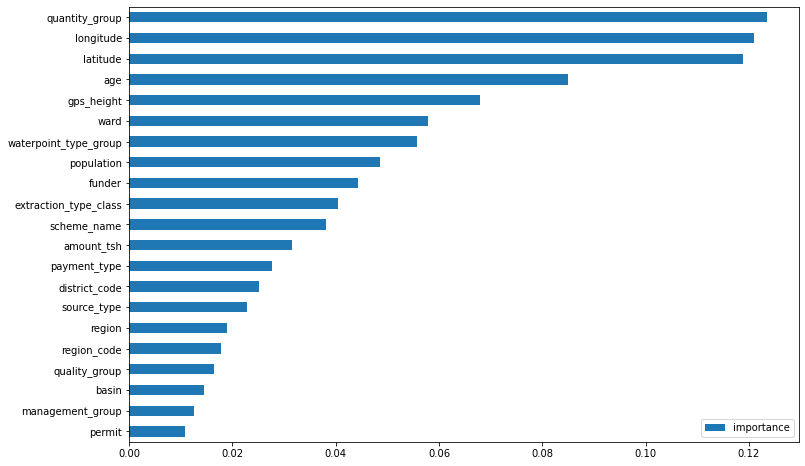

In [97]:
np.random.seed(0)
imp = pd.DataFrame(rf.feature_importances_, index=X_train.columns, columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(12, 8))

# Models

## LightGBM

In [76]:
# %pip install lightgbm

In [100]:
clf = LGBMClassifier(objective='multiclass', n_jobs=8)

In [101]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [103]:
# from sklearn.metrics import accuracy_score, f1_score
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'LightGBM Model accuracy score: {acc}')
print(f'LightGBM Model f1-score: {f1}')

LightGBM Model accuracy score: 0.7785430058157331
LightGBM Model f1-score: 0.7627640643996914


In [106]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
# Parameters that we are going to tune.
# param_grid = {  'n_estimators': [100, 200],
#   'max_depth': [10, 15, 20],
#    'num_leaves': [31, 127],
#     'reg_alpha': [0.1, 0.5],
#     'lambda_l1': [0, 1, 1.5],
#     'lambda_l2': [0, 1] }

In [107]:
#clf = LGBMClassifier(objective='multiclass', n_jobs=8)
#gs = GridSearchCV(clf, param_grid=param_grid, cv=cv, verbose=4)
#gs.fit(X_train, y_train)

In [108]:
best_params = {'n_estimators': 200,
'max_depth': 20,
'num_leaves': 127,
'reg_alpha': 0.1,
'lambda_l1': 1 ,
'lambda_l2': 1 }

clf = LGBMClassifier(**best_params, objective='multiclass', n_jobs=8)

In [109]:
clf.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', lambda_l1=1, lambda_l2=1,
               learning_rate=0.1, max_depth=20, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=200,
               n_jobs=8, num_leaves=127, objective='multiclass',
               random_state=None, reg_alpha=0.1, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [110]:
y_pred_test = clf.predict(X_test)

In [113]:
print(classification_report(y_test, y_pred_test))
rate = classification_rate(y_test, y_pred_test)
print(f'classification_rate: {rate}')

              precision    recall  f1-score   support

           0       0.79      0.90      0.84     10645
           1       0.84      0.76      0.80      7532
           2       0.59      0.31      0.41      1425

    accuracy                           0.80     19602
   macro avg       0.74      0.66      0.68     19602
weighted avg       0.80      0.80      0.80     19602

classification_rate: 0.8033874094480155


## Xgboost

In [114]:
weights = {                   
    0: 0.2,                        
    1: 0.3,
    2: 0.5 }

weight = pd.Series(y_train)
weight_array = weight.replace(weights).values

In [118]:
dtrain = xgb.DMatrix(X_train, label=y_train, weight=weight_array)
dtest = xgb.DMatrix(X_test, label=y_test)

In [115]:

# gridsearch_params = [
#     (max_depth, min_child_weight, eta, subsample, colsample_bytree)
#     for max_depth in range(7,15, 1)
#     for min_child_weight in range(1,5,1)
#     for eta in [.3, .2, .1, .05, .01, .005]
#     for subsample in [i/10. for i in range(7,11)]
#     for colsample in [i/10. for i in range(7,11)]
# ]


# min_mlogloss = float("Inf")
# best_params = None
# for max_depth, min_child_weight in gridsearch_params:
#     print("CV with max_depth={}, min_child_weight={}, eta={}, subsample={}, colsample={}".format(
#                              max_depth,
#                              min_child_weight,
#                                eta,
#                                subsample,
#                                colsample))
#     params['max_depth'] = max_depth
#     params['min_child_weight'] = min_child_weight
#       params['eta'] = eta
#       params['subsample']
#       params['colsample']
#     cv_results = xgb.cv(
#         params,
#         dtrain,
#         num_boost_round=num_boost_round,
#         seed=42,
#         nfold=5,
#         metrics={'mlogloss'},
#         early_stopping_rounds=10,
#         verbose_eval = True
#     )

#     mean_mlogloss = cv_results['test-mlogloss-mean'].min()
#     boost_rounds = cv_results['test-mlogloss-mean'].argmin()
#     print("\tmlogloss {} for {} rounds".format(mean_mlogloss, boost_rounds))
#     if mean_mlogloss < min_mlogloss:
#         min_mlogloss = mean_mlogloss
#         best_params = (max_depth,min_child_weight)
# print("Best params: {}, {}, {}, {}, {}, mlogloss: {}".format(best_params[0], best_params[1], best_params[2], best_params[3], best_params[4], min_mlogloss))

In [119]:
# Best parametrs for model


params = {
    # Parameters that we are going to tune.
    'max_depth': 12,
    'min_child_weight': 1,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    # Other parameters
    'objective':'multi:softprob',
    'eval_metric': 'mlogloss',
    'num_class': 3,
    # 'seed': 27
}

num_boost_round = 1000
early_stopping_rounds = 10

In [120]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=early_stopping_rounds
)


[0]	Test-mlogloss:1.03691
Will train until Test-mlogloss hasn't improved in 10 rounds.
[1]	Test-mlogloss:0.993444
[2]	Test-mlogloss:0.946389
[3]	Test-mlogloss:0.908076
[4]	Test-mlogloss:0.877296
[5]	Test-mlogloss:0.846134
[6]	Test-mlogloss:0.819216
[7]	Test-mlogloss:0.792679
[8]	Test-mlogloss:0.769865
[9]	Test-mlogloss:0.751497
[10]	Test-mlogloss:0.73159
[11]	Test-mlogloss:0.713746
[12]	Test-mlogloss:0.698404
[13]	Test-mlogloss:0.682871
[14]	Test-mlogloss:0.668797
[15]	Test-mlogloss:0.657145
[16]	Test-mlogloss:0.646089
[17]	Test-mlogloss:0.636152
[18]	Test-mlogloss:0.627387
[19]	Test-mlogloss:0.618458
[20]	Test-mlogloss:0.610839
[21]	Test-mlogloss:0.603291
[22]	Test-mlogloss:0.596956
[23]	Test-mlogloss:0.59102
[24]	Test-mlogloss:0.585123
[25]	Test-mlogloss:0.579109
[26]	Test-mlogloss:0.574515
[27]	Test-mlogloss:0.57124
[28]	Test-mlogloss:0.566568
[29]	Test-mlogloss:0.562837
[30]	Test-mlogloss:0.559303
[31]	Test-mlogloss:0.555635
[32]	Test-mlogloss:0.552729
[33]	Test-mlogloss:0.55024
[3

In [121]:
preds = model.predict(dtest)

best_preds = np.asarray([np.argmax(line) for line in preds])

print(classification_report(y_test, best_preds))
print(f'Classification rate: {classification_rate(y_test, best_preds)}')
# print(log_loss(y_test, best_preds,))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83     10645
           1       0.82      0.80      0.81      7532
           2       0.47      0.43      0.45      1425

    accuracy                           0.80     19602
   macro avg       0.70      0.69      0.70     19602
weighted avg       0.79      0.80      0.79     19602

Classification rate: 0.7960412202836445


## Catboost

In [156]:

from catboost import CatBoostClassifier,  Pool


In [125]:
# %pip install catboost

     |████████████████████████████████| 76.4 MB 24 kB/s 


Catboost can work without encoding cathegorical variables

In [157]:
X = train_2.drop('status_group', axis=1)
Y = target_2


X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0, test_size = 0.33, stratify=Y)

In [160]:
cat_features = [1, 5,6,9, 11, 12,13, 14, 15, 16, 17, 18, 19, 20]
cat_features

[1, 5, 6, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [161]:
data_train = Pool(X_train, label=y_train,cat_features=cat_features)

data_eval = Pool(X_test, 
                 label=y_test,
                 cat_features=cat_features)

In [162]:
ctb_params = {
    'max_ctr_complexity': 5,
        'task_type':'CPU',
        'iterations' :10000,
        'eval_metric' :'AUC',
        'od_type':'Iter',
        'od_wait' : 500,
    'learning_rate': .33,
    'loss_function': 'MultiClass',
    'thread_count': 12,
}

In [168]:
model = CatBoostClassifier(**ctb_params)
model.fit(X = data_train, silent=False, eval_set=data_eval)

0:	test: 0.7434485	best: 0.7434485 (0)	total: 603ms	remaining: 1h 40m 25s
1:	test: 0.7787969	best: 0.7787969 (1)	total: 1.04s	remaining: 1h 27m 2s
2:	test: 0.7897768	best: 0.7897768 (2)	total: 1.5s	remaining: 1h 23m 18s
3:	test: 0.8168819	best: 0.8168819 (3)	total: 1.92s	remaining: 1h 19m 48s
4:	test: 0.8335684	best: 0.8335684 (4)	total: 2.31s	remaining: 1h 16m 57s
5:	test: 0.8473425	best: 0.8473425 (5)	total: 2.76s	remaining: 1h 16m 31s
6:	test: 0.8591529	best: 0.8591529 (6)	total: 3.2s	remaining: 1h 16m 6s
7:	test: 0.8627911	best: 0.8627911 (7)	total: 3.63s	remaining: 1h 15m 34s
8:	test: 0.8651471	best: 0.8651471 (8)	total: 4.03s	remaining: 1h 14m 30s
9:	test: 0.8699274	best: 0.8699274 (9)	total: 4.42s	remaining: 1h 13m 36s
10:	test: 0.8738501	best: 0.8738501 (10)	total: 4.93s	remaining: 1h 14m 41s
11:	test: 0.8751927	best: 0.8751927 (11)	total: 5.32s	remaining: 1h 13m 49s
12:	test: 0.8772758	best: 0.8772758 (12)	total: 5.79s	remaining: 1h 14m 6s
13:	test: 0.8779995	best: 0.8779995 (

In [169]:
import json
model.save_model('catboost_1')
feature_importance = dict(zip(model.feature_names_, model.get_feature_importance()))
with open('feature_importance_cb.json', 'w') as f:
  json.dump(feature_importance, f)

In [170]:
model = CatBoostClassifier()
model = model.load_model('catboost_1')

In [171]:
log_loss(y_train, model.predict_proba(data_train))

0.373992219740535

In [172]:
log_loss(y_test, model.predict_proba(data_eval))

0.4997645608737761

In [179]:
y_pred = model.predict(data_eval)

In [180]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84     10645
           1       0.84      0.75      0.79      7532
           2       0.56      0.29      0.38      1425

    accuracy                           0.80     19602
   macro avg       0.73      0.65      0.67     19602
weighted avg       0.79      0.80      0.79     19602



In [ ]:
y_pred_2 = [x[0] for x in y_pred]


In [187]:
classification_rate(y_test, y_pred_2)

0.7983879196000409

## RandomForestClassifier


In [ ]:
#rf = RandomForestClassifier(random_state=0, n_jobs=-1)
#parametrs = {'criterion':['entropy', 'gini'], 'n_estimators': range(10, 101), 'class_weight': ['balanced',{0: 0.2, 1: 0.3, 2: 0.9}]}
#grid_search_cv = GridSearchCV(rf, parametrs, cv=5, scoring = "neg_log_loss")
#grid_search_cv.fit(X_train, y_train)
#best_clf= grid_search_cv.best_estimator_
#best_clf

In [122]:
rf = RandomForestClassifier(random_state=0, n_jobs=-1, n_estimators=64, criterion = 'gini', class_weight={0: 0.2, 1: 0.3, 2: 0.9})
rf.fit(X_train, y_train)
y_pred_1 = rf.predict(X_test)

In [123]:
print(classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84     10645
           1       0.84      0.77      0.80      7532
           2       0.54      0.32      0.40      1425

    accuracy                           0.80     19602
   macro avg       0.73      0.66      0.68     19602
weighted avg       0.80      0.80      0.80     19602



In [124]:
classification_rate(y_test, y_pred_1)

0.8024691358024691

# Final Metrics

Logistic Regression: 0.5760636669727579

KNN classifier: 0.68156310580553

RandomForest (default): 0.803030303030303

LightGBM: 0.8033874094480155

XGBoost: 0.7960412202836445

RandomForest (tuned): 0.8024691358024691

Catboost: 0.7983879196000409